# Context

This notebook continues from the separate [intro_eda](intro_eda.ipynb) notebook. Data scrubbing and exploration is done in that notebook.

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt
import matplotlib as mat
import seaborn as sns
import joblib
import hashlib
import json
import pickle
import gzip
import re
from ml_tools import model_eval, nlp_prep, eda

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import TweetTokenizer, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tag import StanfordPOSTagger

from wordcloud import WordCloud

import spacy

from sklearn import metrics
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV, \
            cross_val_score, cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [13]:
# Load in data that was previously dumped from intro_eda notebook
f = gzip.open('data/cleaned_data.pickle.gz','rb')
df = pickle.load(f)
f.close()

f = gzip.open('data/cleaned_article_data.pickle.gz','rb')
df_articles = pickle.load(f)
f.close()

# Model Facebook Posts Only

Initially, I used a target consisting of outliers, and gridsearched for the best hyperparameters using Multinomial Bayes and Logistic Regression without lemmatization. Logistic Regression slightly outperformed Multinomial Bayes.

I took the best params from the LR model using outlier-based target, and experimented with lemmas as well as modeling only text or only metadata. I then applied the best model so far (with lemmatization and text only) to the target using over 75th percentile and it performed better.

Performance didn't get much above 60% for the target class, so I decided to adjust the binary percentile target to use the mean percentile across all categories instead of the max. I also decided to create a multi-class target to see how that performed.

Generally, the best parameters for Logistic Regression were:
- using Tfidf normalization for the text 
- (1,2) ngrams
- 10,000 max features
- C = 0.1 (1.0 might get slightly better recall but is more overfit)
- saga solver
- fit_intercept = False

Text vectorization tended to take quite a while with lemmatization, which made the gridsearching too time-consuming if I wanted to experiment with vectorization parameters such as different stopwords lists, using/not using Tfidf normalization, using/not using lemmatization, and using different numbers of max features. Ultimately, since the best parameters for both the full set of Facebook posts and the text of the matched articles were the same, I decided to apply those up front. I  considered these my baseline models.

I then ran gridsearching using the text vectorization parameters with the model parameters held constant. I compared the results of the best gridsearch params to the baseline models. Ultimately, I wasn't able to find better parameters, so the original models were kept as the best performing.

In [14]:
df.columns

Index(['id', 'name', 'message', 'description', 'caption', 'post_type',
       'status_type', 'comments_count', 'shares_count', 'link', 'posted_at',
       'print_section', 'print_page', 'snippet', 'lead_paragraph',
       'main_headline', 'news_desk', 'section_name', 'type_of_material',
       'word_count', 'glocations', 'subject', 'persons', 'organizations',
       'creative_works', 'is_matched', 'all_text', 'likes_loves',
       'shares_outliers', 'comments_outliers', 'likelove_outliers',
       'comments_pct', 'shares_pct', 'likesloves_pct', 'max_pct', 'mean_pct',
       'all_binary', 'all_multi', 'comments_pct_m', 'shares_pct_m',
       'likesloves_pct_m', 'max_pct_m', 'mean_pct_m', 'm_binary', 'm_multi',
       'is_interactive', 'is_video', 'is_slideshow', 'word_count_cat',
       'has_person', 'has_org', 'has_geo', 'is_multimedia', 'day_name',
       'month', 'hour', 'year', 'hour_cat', 'on_weekend', 'text_hash',
       'cleaned', 'article_text'],
      dtype='object')

## Different stopwords and punc

I noticed that many of the posts I couldn't match to articles included questions to readers, and asked them to give their opinion in comments. I'm going to remove the question mark and the you/your permutations from the stopwords list to see whether keeping these in affect model performance.

In [15]:
nltk_stopwords = stopwords.words('english')
nltk_stopwords.sort()

import string
punc = list(string.punctuation)

you_list = ['you', "you'd", "you'll", "you're", "you've", 'your', 'yours',
            'yourself', 'yourselves']
custom_stopwords = [word for word in nltk_stopwords if word not in you_list]

custom_punc = punc.copy()
custom_punc.remove('?')

## Preprocessing

In [16]:
# constants for column names involved
text_col = 'cleaned'
cat_cols = ['post_type', 'hour_cat', 'on_weekend']

In [17]:
# initial X and y set for all posts
X = df[[text_col] + cat_cols]
y = df['all_binary']

In [18]:
# 0 is low, 1 is high engagement
class_labels = ['Low', 'High']

# 0 is low, 1 is moderate, 2 is high
mclass_labels = ['Low', 'Moderate', 'High']

In [19]:
# train test split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, 
                                            test_size=0.2, stratify=y)
print(len(X_train_all))
print(len(y_train_all))
print(len(X_test_all))
print(len(y_test_all))

38292
38292
9574
9574


I will want to be able to use the same train-test split for binary as I do for multi-class, so they will be directly comparable.

Thankfully, the indexes in the split dfs stay the same as the original df, so I should be able to generate the same y_train and y_test splits using the multi-class target.

In [20]:
# Create multi-class y_train using the same indices as binary
y_train_all_multi = df[df.index.isin(y_train_all.index)]['all_multi']
y_train_all_multi = y_train_all_multi.reindex(index=list(y_train_all.index))

# Create multi-class y_test using the same indices as binary
y_test_all_multi = df[df.index.isin(y_test_all.index)]['all_multi']
y_test_all_multi = y_test_all_multi.reindex(index=list(y_test_all.index))

In [21]:
print(y_train_all_multi.isna().sum())
y_test_all_multi.isna().sum()

0


0

### Which categories will be dropped as first?

In [22]:
print(X['post_type'].unique())

['link' 'photo' 'other' 'video']


The first will be `link`, which most of the posts.

In [23]:
print(X['hour_cat'].unique())

['3_Midday (11-15)' '4_Afternoon (15-19)' '5_Evening (19-23)'
 '2_Morning (7-11)' '6_Late night (23-3)' '1_Early morning (3-7)']


The first will be Early Morning, which is rare.

## Transform X up front

To save time gridsearching and evaluating models based on model hyperparameters only.

In [24]:
# Transform text and cat cols ahead of time to save time when gridsearching
# further
txt_trans_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=nlp_prep.tokenize_lemma,
                            stop_words=custom_stopwords + custom_punc,
                            ngram_range=(1, 2),
                            max_features=10000)),
    ('tfidf', TfidfTransformer())
])

# NOTE: The text transformers expect a single column, in a 1-D array.
# If you pass a list of strings as column names for the text transformer,
# it will crap out because it will receive a 2D array...
all_cols_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    ('txt', txt_trans_pipe, text_col)
])

X_train_all_t = all_cols_trans.fit_transform(X_train_all)
X_test_all_t = all_cols_trans.transform(X_test_all)

/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [25]:
# Path I'm going to use to save best estimators from gridsearching
save_path = "models/"

In [26]:
rerun_grid = False

## Baseline Dummy Classifiers

### Binary

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.78      0.79      0.79     30067
         1.0       0.21      0.21      0.21      8225

    accuracy                           0.66     38292
   macro avg       0.50      0.50      0.50     38292
weighted avg       0.66      0.66      0.66     38292


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78      7517
         1.0       0.21      0.21      0.21      2057

    accuracy                           0.66      9574
   macro avg       0.49      0.49      0.49      9574
weighted avg       0.66      0.66      0.66      9574


****************************** Training Scores ******************************
                  Training F1 = [0.7851 0.2115]
              Training Recall = [0.7856 0.2109]
            Training A

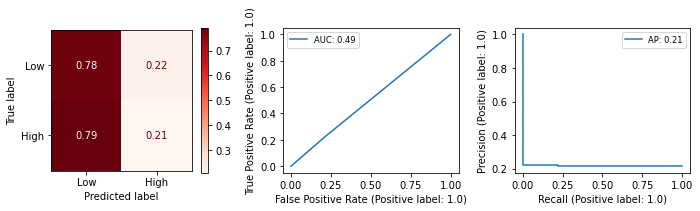

In [27]:
# Let's make a baseline classifier using the dummy model
dummy_clf = DummyClassifier(strategy='stratified')

dummy_clf.fit(X_train_all_t, y_train_all)

model_eval.eval_clf_model(dummy_clf, X_test_all_t, y_test_all, X_train_all_t, 
            y_train_all, labels=class_labels, score='std')

### Multi-class

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.21      0.21      0.21      8158
         1.0       0.57      0.57      0.57     21909
         2.0       0.21      0.22      0.22      8225

    accuracy                           0.42     38292
   macro avg       0.33      0.33      0.33     38292
weighted avg       0.42      0.42      0.42     38292


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.22      0.22      0.22      2056
         1.0       0.57      0.58      0.57      5461
         2.0       0.20      0.20      0.20      2057

    accuracy                           0.42      9574
   macro avg       0.33      0.33      0.33      9574
weighted avg       0.42      0.42      0.42      9574


****************************** Training Scores ******************************
          

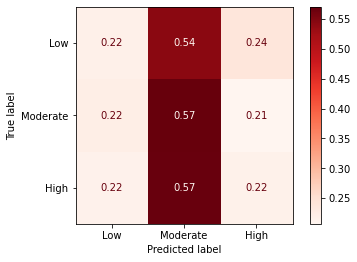

In [28]:
dummy_clf.fit(X_train_all_t, y_train_all_multi)

model_eval.eval_clf_model(dummy_clf, X_test_all_t, y_test_all_multi, 
        X_train_all_t, y_train_all_multi, labels=mclass_labels, score='std')

## Multinomial Bayes

### Baseline Binary

Best on previous best hyper params from gridsearching on slightly different targets.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


0.5855319148936171
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.91      0.73      0.81     30067
         1.0       0.43      0.73      0.54      8225

    accuracy                           0.73     38292
   macro avg       0.67      0.73      0.67     38292
weighted avg       0.80      0.73      0.75     38292


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.87      0.71      0.78      7517
         1.0       0.36      0.61      0.46      2057

    accuracy                           0.69      9574
   macro avg       0.62      0.66      0.62      9574
weighted avg       0.76      0.69      0.71      9574


****************************** Training Scores ******************************
                  Training F1 = [0.8117 0.5382]
              Training Recall = [0.7343 0.7257]
   

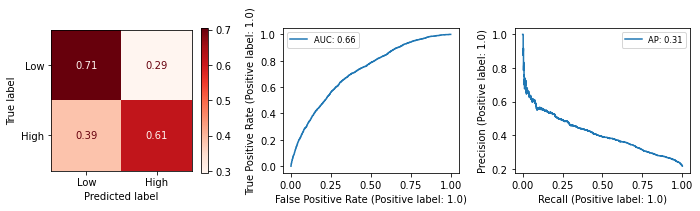

In [29]:
clf_mnb = MultinomialNB(fit_prior=False, alpha=0.5)

cv_scores = cross_val_score(clf_mnb, X_train_all_t, y_train_all, n_jobs=-1, 
                            scoring='recall', verbose=1)
print(np.mean(cv_scores))

clf_mnb.fit(X_train_all_t, y_train_all)

model_eval.eval_clf_model(clf_mnb, X_test_all_t, y_test_all, X_train_all_t, 
            y_train_all, labels=class_labels, score='std')

### Baseline Multi-class

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


0.5052882512273874
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.50      0.67      0.58      8158
         1.0       0.76      0.54      0.63     21909
         2.0       0.46      0.66      0.54      8225

    accuracy                           0.60     38292
   macro avg       0.58      0.63      0.58     38292
weighted avg       0.64      0.60      0.60     38292


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.39      0.51      0.44      2056
         1.0       0.64      0.46      0.54      5461
         2.0       0.37      0.53      0.44      2057

    accuracy                           0.49      9574
   macro avg       0.47      0.50      0.47      9574
weighted avg       0.53      0.49      0.50      9574


****************************** Training Scores **********************

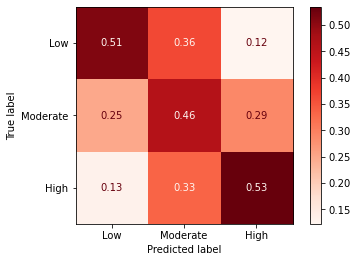

In [30]:
clf_mnb_multi = MultinomialNB(fit_prior=False, alpha=0.5)

cv_scores = cross_val_score(clf_mnb_multi, X_train_all_t, y_train_all_multi, 
            n_jobs=-1, scoring='recall_macro', verbose=1, error_score='raise')
print(np.mean(cv_scores))

clf_mnb_multi.fit(X_train_all_t, y_train_all_multi)

model_eval.eval_clf_model(clf_mnb_multi, X_test_all_t, y_test_all_multi,  
        X_train_all_t, y_train_all_multi, labels=mclass_labels, score='std')

## Logistic Regression

### Baseline Binary

Best on previous best hyper params from gridsearching on slightly different targets.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


0.6087537993920973
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.70      0.79     30067
         1.0       0.39      0.70      0.50      8225

    accuracy                           0.70     38292
   macro avg       0.64      0.70      0.64     38292
weighted avg       0.79      0.70      0.73     38292


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.87      0.68      0.76      7517
         1.0       0.35      0.63      0.45      2057

    accuracy                           0.67      9574
   macro avg       0.61      0.65      0.61      9574
weighted avg       0.76      0.67      0.70      9574


****************************** Training Scores ******************************
                  Training F1 = [0.7878 0.5021]
              Training Recall = [0.7034 0.6986]
   

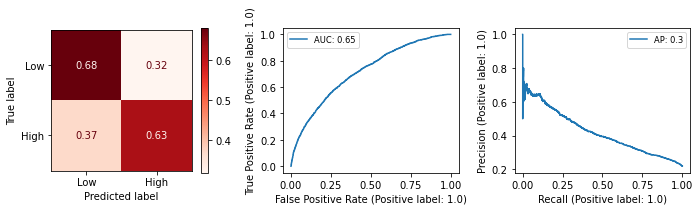

In [31]:
clf_lr = LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1)

cv_scores = cross_val_score(clf_lr, X_train_all_t, y_train_all, n_jobs=-1, 
                            scoring='recall', verbose=1)
print(np.mean(cv_scores))

clf_lr.fit(X_train_all_t, y_train_all)

model_eval.eval_clf_model(clf_lr, X_test_all_t, y_test_all, X_train_all_t, 
            y_train_all, labels=class_labels, score='std')

### Gridsearch for Binary - no lemmas

/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.

[('cols_trans', ColumnTransformer(transformers=[('ohe', OneHotEncoder(drop='first'),
                                 ['post_type', 'hour_cat', 'on_weekend']),
                                ('txt',
                                 Pipeline(steps=[('vect',
                                                  CountVectorizer(max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words=['a',
                                                                              'about',
                                                                              'above',
                                                                              'after',
                                                                              'again',
                                                            

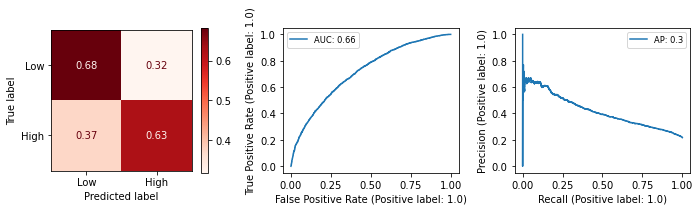

In [32]:
# Gridsearch was run in colab notebook, where I searched vectorization 
# parameters with no lemmatization. This just loads the best estimator.
# using the non-transformed X's since the gridsearch will do the transformation

gsfile_name = 'GSObject_LR_all_binary.joblib.gz'

best_LR_all_binary_pipe, best_LR_all_binary_gs = model_eval.\
        load_rebuild_eval_bestpipe(gsfile_name, X_train_all, y_train_all, 
        X_test_all, y_test_all, class_labels, load_path=save_path)

In [33]:
# what is the version of stopwords used?
best_LR_all_binary_pipe.named_steps['cols_trans'].named_transformers_['txt']\
    .named_steps['vect'].get_stop_words()


frozenset({'!',
           '"',
           '#',
           '$',
           '%',
           '&',
           "'",
           '(',
           ')',
           '*',
           '+',
           ',',
           '-',
           '.',
           '/',
           ':',
           ';',
           '<',
           '=',
           '>',
           '@',
           '[',
           '\\',
           ']',
           '^',
           '_',
           '`',
           'a',
           'about',
           'above',
           'after',
           'again',
           'against',
           'ain',
           'all',
           'am',
           'an',
           'and',
           'any',
           'are',
           'aren',
           "aren't",
           'as',
           'at',
           'be',
           'because',
           'been',
           'before',
           'being',
           'below',
           'between',
           'both',
           'but',
           'by',
           'can',
           'couldn',
           "could

The custom stopwords list (not including `?` or permutations of `your` was best, and lemmatization didn't add to performance.

The best binary classifier was ultimately using the same params I initially identified by experimenting with model params.

### Max Features 2000
### *** Best All Binary ***

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


0.6206686930091185
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.89      0.68      0.77     30067
         1.0       0.37      0.68      0.48      8225

    accuracy                           0.68     38292
   macro avg       0.63      0.68      0.62     38292
weighted avg       0.77      0.68      0.71     38292


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.87      0.66      0.75      7517
         1.0       0.34      0.64      0.44      2057

    accuracy                           0.66      9574
   macro avg       0.60      0.65      0.60      9574
weighted avg       0.76      0.66      0.68      9574


****************************** Training Scores ******************************
                  Training F1 = [0.7708 0.4776]
              Training Recall = [0.6824 0.6779]
   

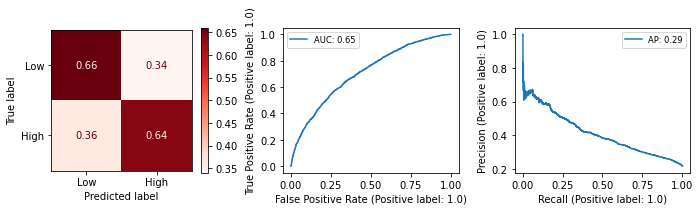

In [34]:
# Gridsearch of max features in my colab notebook showed that 2000 could 
# actually be better. Is it better compared to 10k on the same training split?

# set max_features to 2000, all othe params kept constant
best_LR_all_binary_pipe.set_params(**{'cols_trans__txt__vect__max_features': 2000})

# get cross-validated recall score using non-transformed data
cv_scores = cross_val_score(best_LR_all_binary_pipe, X_train_all, 
                            y_train_all, n_jobs=-1, scoring='recall', verbose=1)
print(np.mean(cv_scores))

# refit
best_LR_all_binary_pipe.fit(X_train_all, y_train_all)

model_eval.eval_clf_model(best_LR_all_binary_pipe, X_test_all, y_test_all, 
                          X_train_all, y_train_all, labels=class_labels, 
                          score='std')

### Baseline Multi-class

Best on previous best hyper params from gridsearching on slightly different targets.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


0.5148356333798312
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.45      0.70      0.55      8158
         1.0       0.77      0.43      0.56     21909
         2.0       0.43      0.69      0.53      8225

    accuracy                           0.55     38292
   macro avg       0.55      0.61      0.54     38292
weighted avg       0.63      0.55      0.55     38292


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.38      0.58      0.46      2056
         1.0       0.65      0.37      0.47      5461
         2.0       0.37      0.59      0.45      2057

    accuracy                           0.46      9574
   macro avg       0.46      0.51      0.46      9574
weighted avg       0.53      0.46      0.46      9574


****************************** Training Scores **********************

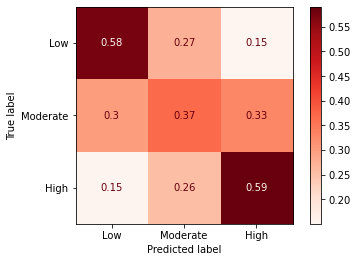

In [35]:
clf_lr = LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1)

cv_scores = cross_val_score(clf_lr, X_train_all_t, y_train_all_multi, n_jobs=-1, 
                            scoring='recall_macro', verbose=1)
print(np.mean(cv_scores))

clf_lr.fit(X_train_all_t, y_train_all_multi)

model_eval.eval_clf_model(clf_lr, X_test_all_t, y_test_all_multi, X_train_all_t, 
            y_train_all_multi, labels=mclass_labels, score='std')

### Gridsearch for Multi-class - no lemmas
### *** Best All Multi ***

/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/base.

[('cols_trans', ColumnTransformer(transformers=[('ohe', OneHotEncoder(drop='first'),
                                 ['post_type', 'hour_cat', 'on_weekend']),
                                ('txt',
                                 Pipeline(steps=[('vect',
                                                  CountVectorizer(max_features=10000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words=['a',
                                                                              'about',
                                                                              'above',
                                                                              'after',
                                                                              'again',
                                                            

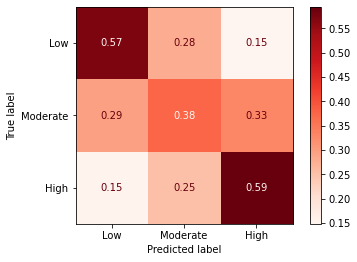

In [36]:
gsfile_name = 'GSObject_LR_all_multi.joblib.gz'

best_LR_all_multi_pipe, best_LR_all_multi_gs = model_eval.\
        load_rebuild_eval_bestpipe(gsfile_name, X_train_all, y_train_all_multi, 
        X_test_all, y_test_all_multi, mclass_labels, load_path=save_path)

In [37]:
# what is the version of stopwords used?
best_LR_all_multi_pipe.named_steps['cols_trans'].named_transformers_['txt']\
    .named_steps['vect'].get_stop_words()

frozenset({'!',
           '"',
           '#',
           '$',
           '%',
           '&',
           "'",
           '(',
           ')',
           '*',
           '+',
           ',',
           '-',
           '.',
           '/',
           ':',
           ';',
           '<',
           '=',
           '>',
           '@',
           '[',
           '\\',
           ']',
           '^',
           '_',
           '`',
           'a',
           'about',
           'above',
           'after',
           'again',
           'against',
           'ain',
           'all',
           'am',
           'an',
           'and',
           'any',
           'are',
           'aren',
           "aren't",
           'as',
           'at',
           'be',
           'because',
           'been',
           'before',
           'being',
           'below',
           'between',
           'both',
           'but',
           'by',
           'can',
           'couldn',
           "could

Custom stopwords again.

### LR results

The best binary LR identifies about 62% of high engagement posts correctly, and about 66% of low engagement posts correctly. As a reminder, for binary target, `high` defines posts with mean percentiles across all three engagement metrics greater than 75.

- Stopwords list that does not include permutations of `your` or `?` performs better than NLTK according to gridsearch optimized for recall.
- TF-IDF transformation does better than regular count or binary
- N-grams (1,2) are still better than (1,1), and max features 2k are best after searching several options
- There is a slight performance difference between lemmatizing versus not, but not very much. Using regular Tweet Tokenizer is slightly better, and is also easier to interpret.

The best multi-class LR finds about ~60% of Low and High engagement posts correctly, but only about 37% of Moderate. For the multi-class target, High engagement is defined the same way as binary, but Low is defined as mean percentile under 25%, and Moderate is mean percentile between 25% and 75%.

In multi-class, posts are mis-classified fairly evenly. Both High and Low are mis-classified as Moderate most frequently (about 30%) but are confused for each other only about 14%.

- As with binary, the best params are custom stopwords TF-IDF text vectorization normalization, (1,2) n-grams. 
- Multi-class did better with a slightly higher, 10k feature limit.
- Regular tweet-tokenizer actually did slightly better than using lemmatization in this case, although not by much.


# Model Matched Articles

## Preprocessing

In [38]:
cat_cols = ['section_name', 'word_count_cat', 'is_multimedia', 'has_person', 
            'has_org', 'has_geo']

Xmat = df_articles[['cleaned', 'subject'] + cat_cols]
ymat = df_articles['m_binary']

In [39]:
# train test split
X_train_mat, X_test_mat, y_train_mat, y_test_mat = train_test_split(Xmat, ymat, 
                                    test_size=0.2, stratify=ymat)
print(len(X_train_mat))
print(len(y_train_mat))
print(len(X_test_mat))
print(len(y_test_mat))

34581
34581
8646
8646


I will want to be able to use the same train-test split for binary as I do for multi-class, so they will be directly comparable.

Thankfully, the indexes in the split dfs stay the same as the original df, so I should be able to generate the same y_train and y_test splits using the multi-class target.

In [40]:
# Create multi-class y_train using the same indices as binary
y_train_mat_multi = df_articles[df_articles.index.isin(y_train_mat.index)]['m_multi']
y_train_mat_multi = y_train_mat_multi.reindex(index=list(y_train_mat.index))

# Create multi-class y_test using the same indices as binary
y_test_mat_multi = df_articles[df_articles.index.isin(y_test_mat.index)]['m_multi']
y_test_mat_multi = y_test_mat_multi.reindex(index=list(y_test_mat.index))

In [41]:
print(y_train_mat.value_counts())
print(y_train_mat_multi.value_counts())

0.0    27140
1.0     7441
Name: m_binary, dtype: int64
1.0    19813
2.0     7441
0.0     7327
Name: m_multi, dtype: int64


In [42]:
print(y_test_mat.value_counts())
print(y_test_mat_multi.value_counts())

0.0    6786
1.0    1860
Name: m_binary, dtype: int64
1.0    4918
0.0    1868
2.0    1860
Name: m_multi, dtype: int64


## Transform X up front

To save time gridsearching and evaluating models based on model hyperparameters only.

In [43]:
# Transform text and cat cols ahead of time to save time when gridsearching
# further
txt_trans_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=nlp_prep.tokenize_lemma,
                            stop_words=custom_stopwords + custom_punc,
                            ngram_range=(1, 2),
                            max_features=10000)),
    ('tfidf', TfidfTransformer())
])

def no_analyzer(doc):
    """Pass-through function to avoid transforming tokens lists.
    """
    return doc

# creating a column transformer to combine OHE of cat cols, basic count
# vectorization of subject, and tokenizing and vectorization of cleaned text
m_cols_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    ('txt_kw', CountVectorizer(analyzer=no_analyzer), 'subject'),
    ('txt', txt_trans_pipe, 'cleaned')
])

X_train_mat_t = m_cols_trans.fit_transform(X_train_mat)
X_test_mat_t = m_cols_trans.transform(X_test_mat)

/Users/jessicamiles/opt/anaconda3/envs/learn-env2a/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


When gridsearching different text vectorization options, using lemmas versus using a basic TweetTokenizer was the only param that was selected differently. Going to transform using TweetTokenizer and try both ways, with all other params held constant, to compare.

In [44]:
# No lemmatization
tweettokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

txt_trans_pipe2 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tweettokenizer.tokenize,
                            stop_words=custom_stopwords + custom_punc,
                            ngram_range=(1, 2),
                            max_features=10000)),
    ('tfidf', TfidfTransformer())
])

# creating a column transformer to combine OHE of cat cols, basic count
# vectorization of subject, and tokenizing and vectorization of cleaned text
m_cols_trans2 = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    ('txt_kw', CountVectorizer(analyzer=no_analyzer), 'subject'),
    ('txt', txt_trans_pipe2, 'cleaned')
])

X_train_mat_t2 = m_cols_trans2.fit_transform(X_train_mat)
X_test_mat_t2 = m_cols_trans2.transform(X_test_mat)

## Baseline Dummy Classifier

### Binary

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79     27140
         1.0       0.22      0.22      0.22      7441

    accuracy                           0.66     34581
   macro avg       0.50      0.50      0.50     34581
weighted avg       0.66      0.66      0.66     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.78      0.79      0.78      6786
         1.0       0.21      0.20      0.20      1860

    accuracy                           0.66      8646
   macro avg       0.49      0.49      0.49      8646
weighted avg       0.66      0.66      0.66      8646


****************************** Training Scores ******************************
                  Training F1 = [0.786  0.2185]
              Training Recall = [0.7862 0.2183]
            Training A

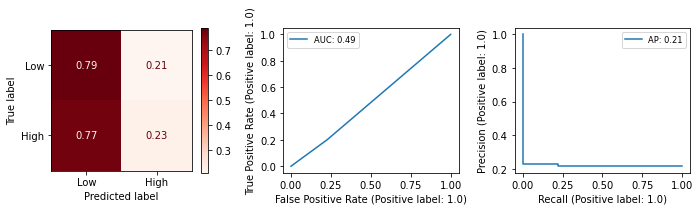

In [45]:
# Let's make a baseline classifier using the dummy model
dummy_clf = DummyClassifier(strategy='stratified')

dummy_clf.fit(X_train_mat_t, y_train_mat)

model_eval.eval_clf_model(dummy_clf, X_test_mat_t, y_test_mat, X_train_mat_t, 
            y_train_mat, labels=class_labels, score='std')

### Multi-class

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.21      0.21      0.21      7327
         1.0       0.57      0.57      0.57     19813
         2.0       0.21      0.21      0.21      7441

    accuracy                           0.42     34581
   macro avg       0.33      0.33      0.33     34581
weighted avg       0.42      0.42      0.42     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.22      0.22      0.22      1868
         1.0       0.57      0.58      0.57      4918
         2.0       0.20      0.20      0.20      1860

    accuracy                           0.42      8646
   macro avg       0.33      0.33      0.33      8646
weighted avg       0.41      0.42      0.42      8646


****************************** Training Scores ******************************
          

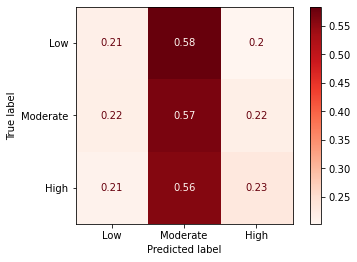

In [46]:
dummy_clf.fit(X_train_mat_t, y_train_mat_multi)

model_eval.eval_clf_model(dummy_clf, X_test_mat_t, y_test_mat_multi,  
        X_train_mat_t, y_train_mat_multi, labels=mclass_labels, score='std')

## Multinomial Bayes

### Baseline Binary

Best on previous best hyper params from gridsearching on slightly different targets.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


0.6051615972327535
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.70      0.79     27140
         1.0       0.39      0.72      0.51      7441

    accuracy                           0.70     34581
   macro avg       0.65      0.71      0.65     34581
weighted avg       0.79      0.70      0.73     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.86      0.67      0.76      6786
         1.0       0.34      0.61      0.43      1860

    accuracy                           0.66      8646
   macro avg       0.60      0.64      0.59      8646
weighted avg       0.75      0.66      0.69      8646


****************************** Training Scores ******************************
                  Training F1 = [0.7865 0.5096]
              Training Recall = [0.6981 0.7183]
   

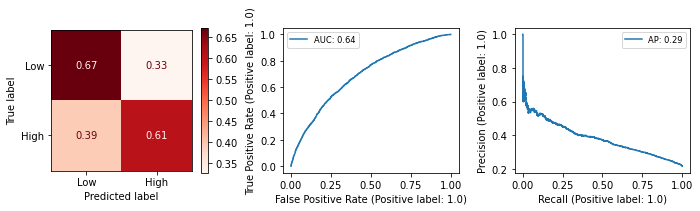

In [47]:
clf_mnb_m = MultinomialNB(fit_prior=False, alpha=0.5)

cv_scores = cross_val_score(clf_mnb_m, X_train_mat_t, y_train_mat, n_jobs=-1, 
                            scoring='recall', verbose=1)
print(np.mean(cv_scores))

clf_mnb_m.fit(X_train_mat_t, y_train_mat)

model_eval.eval_clf_model(clf_mnb_m, X_test_mat_t, y_test_mat, X_train_mat_t, 
            y_train_mat, labels=class_labels, score='std')

### Binary - No lemmas

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


0.6078492276695769
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.70      0.79     27140
         1.0       0.40      0.72      0.51      7441

    accuracy                           0.70     34581
   macro avg       0.65      0.71      0.65     34581
weighted avg       0.79      0.70      0.73     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.86      0.67      0.75      6786
         1.0       0.33      0.60      0.43      1860

    accuracy                           0.65      8646
   macro avg       0.60      0.64      0.59      8646
weighted avg       0.75      0.65      0.68      8646


****************************** Training Scores ******************************
                  Training F1 = [0.7865 0.5103]
              Training Recall = [0.6979 0.7199]
   

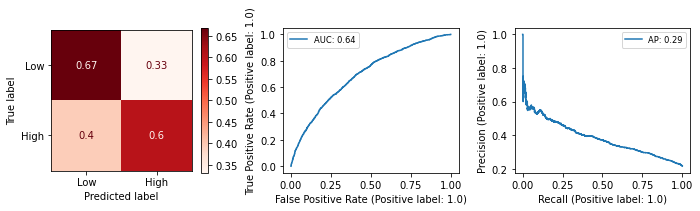

In [48]:
cv_scores = cross_val_score(clf_mnb_m, X_train_mat_t2, y_train_mat, n_jobs=-1, 
                            scoring='recall', verbose=1)
print(np.mean(cv_scores))

clf_mnb_m.fit(X_train_mat_t2, y_train_mat)

model_eval.eval_clf_model(clf_mnb_m, X_test_mat_t2, y_test_mat, X_train_mat_t2, 
            y_train_mat, labels=class_labels, score='std')

### Baseline Multi-class

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


0.4935433447396992
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.44      0.69      0.54      7327
         1.0       0.76      0.43      0.55     19813
         2.0       0.42      0.67      0.52      7441

    accuracy                           0.54     34581
   macro avg       0.54      0.60      0.53     34581
weighted avg       0.62      0.54      0.54     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.38      0.59      0.46      1868
         1.0       0.64      0.36      0.46      4918
         2.0       0.35      0.56      0.43      1860

    accuracy                           0.45      8646
   macro avg       0.46      0.50      0.45      8646
weighted avg       0.52      0.45      0.46      8646


****************************** Training Scores **********************

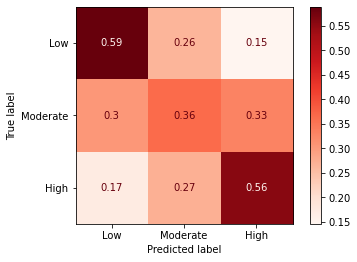

In [49]:
clf_mnb_m_multi = MultinomialNB(fit_prior=False, alpha=0.5)

clf_mnb_m_multi.fit(X_train_mat_t, y_train_mat_multi)

cv_scores = cross_val_score(clf_mnb_m_multi, X_train_mat_t, y_train_mat_multi, 
                            n_jobs=-1, scoring='recall_macro', verbose=1, )
print(np.mean(cv_scores))

model_eval.eval_clf_model(clf_mnb_m_multi, X_test_mat_t, y_test_mat_multi,  
            X_train_mat_t, y_train_mat_multi, labels=mclass_labels, score='std')

### Multi-class - No lemmas

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


0.49497494557527083
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.44      0.69      0.54      7327
         1.0       0.76      0.42      0.54     19813
         2.0       0.42      0.67      0.52      7441

    accuracy                           0.53     34581
   macro avg       0.54      0.60      0.53     34581
weighted avg       0.62      0.53      0.54     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.37      0.59      0.46      1868
         1.0       0.64      0.36      0.46      4918
         2.0       0.35      0.55      0.43      1860

    accuracy                           0.45      8646
   macro avg       0.45      0.50      0.45      8646
weighted avg       0.52      0.45      0.45      8646


****************************** Training Scores *********************

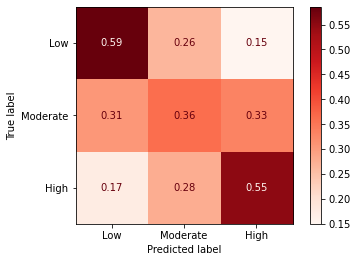

In [50]:
clf_mnb_m_multi.fit(X_train_mat_t2, y_train_mat_multi)

cv_scores = cross_val_score(clf_mnb_m_multi, X_train_mat_t2, y_train_mat_multi, 
                            n_jobs=-1, scoring='recall_macro', verbose=1, )
print(np.mean(cv_scores))

model_eval.eval_clf_model(clf_mnb_m_multi, X_test_mat_t2, y_test_mat_multi,  
            X_train_mat_t2, y_train_mat_multi, labels=mclass_labels, score='std')

## Logistic Regression

### Baseline Binary

Best on previous best hyper params from gridsearching on slightly different targets.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


0.5974997653039854
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.71      0.80     27140
         1.0       0.41      0.72      0.52      7441

    accuracy                           0.71     34581
   macro avg       0.65      0.71      0.66     34581
weighted avg       0.80      0.71      0.74     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.86      0.68      0.76      6786
         1.0       0.34      0.60      0.44      1860

    accuracy                           0.66      8646
   macro avg       0.60      0.64      0.60      8646
weighted avg       0.75      0.66      0.69      8646


****************************** Training Scores ******************************
                  Training F1 = [0.7965 0.5185]
              Training Recall = [0.7133 0.7159]
   

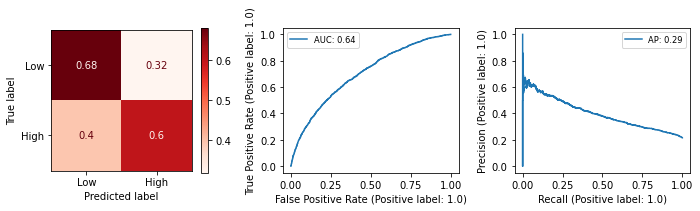

In [51]:
clf_lr_m = LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1)

clf_lr_m.fit(X_train_mat_t, y_train_mat)

cv_scores = cross_val_score(clf_lr_m, X_train_mat_t, y_train_mat, n_jobs=-1, 
                            scoring='recall', verbose=1)
print(np.mean(cv_scores))

model_eval.eval_clf_model(clf_lr_m, X_test_mat_t, y_test_mat, X_train_mat_t, 
            y_train_mat, labels=class_labels, score='std')

### Binary - No lemmas

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


0.5942748615293515
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.72      0.80     27140
         1.0       0.41      0.72      0.52      7441

    accuracy                           0.72     34581
   macro avg       0.66      0.72      0.66     34581
weighted avg       0.80      0.72      0.74     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.86      0.68      0.76      6786
         1.0       0.34      0.60      0.44      1860

    accuracy                           0.67      8646
   macro avg       0.60      0.64      0.60      8646
weighted avg       0.75      0.67      0.69      8646


****************************** Training Scores ******************************
                  Training F1 = [0.7984 0.5212]
              Training Recall = [0.7159 0.7176]
   

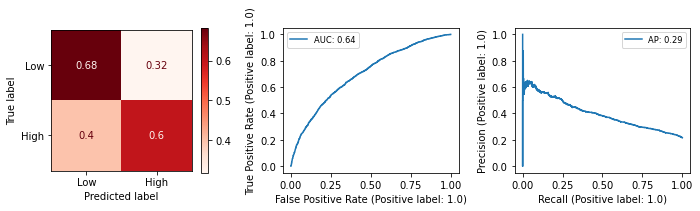

In [52]:
clf_lr_m.fit(X_train_mat_t2, y_train_mat)

cv_scores = cross_val_score(clf_lr_m, X_train_mat_t2, y_train_mat, n_jobs=-1, 
                            scoring='recall', verbose=1)
print(np.mean(cv_scores))

model_eval.eval_clf_model(clf_lr_m, X_test_mat_t2, y_test_mat, X_train_mat_t2, 
            y_train_mat, labels=class_labels, score='std')

### Max Features 2000
### *** Best Matched Binary ***

Gridsearching on max features in my colab notebook, I determined that the best binary classifier for the matched posts used only 2000 features.

The best multi-class classifier still used 10,000 features, so that one I've left as-is.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


0.6003228875553341
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.71      0.79     27140
         1.0       0.40      0.71      0.51      7441

    accuracy                           0.71     34581
   macro avg       0.65      0.71      0.65     34581
weighted avg       0.79      0.71      0.73     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.86      0.68      0.76      6786
         1.0       0.34      0.61      0.44      1860

    accuracy                           0.67      8646
   macro avg       0.60      0.64      0.60      8646
weighted avg       0.75      0.67      0.69      8646


****************************** Training Scores ******************************
                  Training F1 = [0.7901 0.5093]
              Training Recall = [0.7051 0.7092]
   

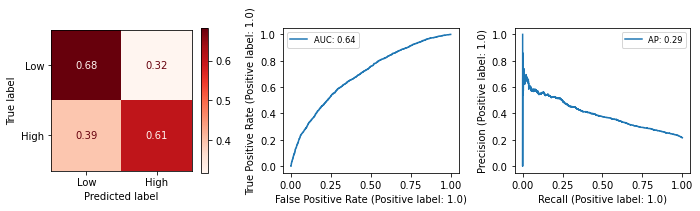

In [53]:
txt_trans_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tweettokenizer.tokenize,
                            stop_words=custom_stopwords + custom_punc,
                            ngram_range=(1, 2),
                            max_features=2000)),
    ('tfidf', TfidfTransformer())
])

# creating a column transformer to combine OHE of cat cols, basic count
# vectorization of subject, and tokenizing and vectorization of cleaned text
m_cols_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    ('txt_kw', CountVectorizer(analyzer=no_analyzer), 'subject'),
    ('txt', txt_trans_pipe, 'cleaned')
])

best_LR_mat_binary_pipe = Pipeline([
    ('cols_trans', m_cols_trans),
    ('clf', LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1))
])

cv_scores = cross_val_score(best_LR_mat_binary_pipe, X_train_mat, y_train_mat, 
                            n_jobs=-1, scoring='recall', verbose=1)
print(np.mean(cv_scores))

best_LR_mat_binary_pipe.fit(X_train_mat, y_train_mat)

model_eval.eval_clf_model(best_LR_mat_binary_pipe, X_test_mat, y_test_mat, 
            X_train_mat, y_train_mat, labels=class_labels, score='std')

### Baseline Multi-class

Best on previous best hyper params from gridsearching on slightly different targets.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


0.5021560368433197
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.45      0.73      0.55      7327
         1.0       0.78      0.43      0.56     19813
         2.0       0.44      0.69      0.54      7441

    accuracy                           0.55     34581
   macro avg       0.56      0.62      0.55     34581
weighted avg       0.64      0.55      0.55     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.37      0.60      0.46      1868
         1.0       0.64      0.36      0.46      4918
         2.0       0.35      0.55      0.43      1860

    accuracy                           0.45      8646
   macro avg       0.46      0.50      0.45      8646
weighted avg       0.52      0.45      0.45      8646


****************************** Training Scores **********************

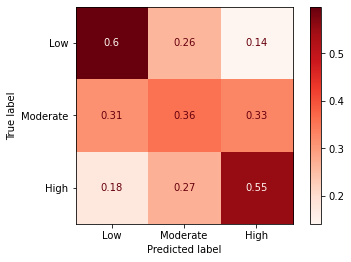

In [54]:
clf_lr_m_multi = LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1)

clf_lr_m_multi.fit(X_train_mat_t, y_train_mat_multi)

cv_scores = cross_val_score(clf_lr_m_multi, X_train_mat_t, y_train_mat_multi, 
                            n_jobs=-1, scoring='recall_macro', verbose=1)
print(np.mean(cv_scores))

model_eval.eval_clf_model(clf_lr_m_multi, X_test_mat_t, y_test_mat_multi,  
        X_train_mat_t, y_train_mat_multi, labels=mclass_labels, score='std')

### Multi-class - No lemmas
### *** Best Matched Multi ***

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


0.5011161538924105
****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.45      0.73      0.56      7327
         1.0       0.79      0.44      0.56     19813
         2.0       0.45      0.69      0.54      7441

    accuracy                           0.56     34581
   macro avg       0.56      0.62      0.55     34581
weighted avg       0.64      0.56      0.56     34581


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.37      0.60      0.46      1868
         1.0       0.64      0.35      0.46      4918
         2.0       0.36      0.56      0.43      1860

    accuracy                           0.45      8646
   macro avg       0.46      0.50      0.45      8646
weighted avg       0.52      0.45      0.45      8646


****************************** Training Scores **********************

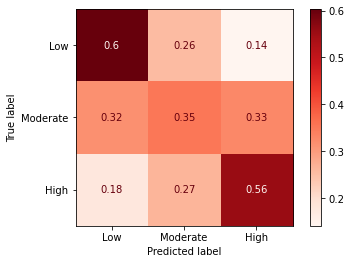

In [55]:
clf_lr_m_multi.fit(X_train_mat_t2, y_train_mat_multi)

cv_scores = cross_val_score(clf_lr_m_multi, X_train_mat_t2, y_train_mat_multi, 
                            n_jobs=-1, scoring='recall_macro', verbose=1)
print(np.mean(cv_scores))

model_eval.eval_clf_model(clf_lr_m_multi, X_test_mat_t2, y_test_mat_multi,  
        X_train_mat_t2, y_train_mat_multi, labels=mclass_labels, score='std')

### Build pipeline for best

In [56]:
best_LR_mat_multi_pipe = Pipeline([
    ('cols_trans', m_cols_trans),
    ('clf', LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1))
])

best_LR_mat_multi_pipe.fit(X_train_mat, y_train_mat_multi)

Pipeline(steps=[('cols_trans',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['section_name',
                                                   'word_count_cat',
                                                   'is_multimedia',
                                                   'has_person', 'has_org',
                                                   'has_geo']),
                                                 ('txt_kw',
                                                  CountVectorizer(analyzer=<function no_analyzer at 0x7fd1ed920b80>),
                                                  'subject'),
                                                 ('txt',
                                                  Pipeline(steps=[('vect',
                                                                   CountVectorizer(max_features=2000,
               

# iNTERPRET

## Best models overview

Binary classifiers performed slightly better on the `High engagement` target than multi-class. 

Binary classifiers were able to predict about 62% of high engagement posts correctly, and about 66% of low engagement posts correctly. There was little difference in performance between analyzing Facebook text and metadata versus text and metadata from the original NYT articles that I could match.

Multi-class classifiers for all posts using Facebook data were able to predict about 60% of high engagement, 60% of low engagement, and 37% of moderate engagement posts correctly. Classifiers on matched articles were slightly worse at predicting high and moderate engagement, but not by much.

Although the models are not highly accurate, they do all perform quite a bit better on the high/low classes than guessing based on class balance. Rather than pursue more complex models which may achieve better performance but will also be more prone to overfitting on this data and will also be more difficult to interpret, I'm going to use these and see what insights we can get that might be applicable to future data.

In some cases, Multinomial Bayes performed slightly better than Logistic Regression, but again the difference wasn't much. I'm going to use the Logistic Regression models since they are very easy to interpret.

I'm also going to use the versions without lemmatization, as it didn't seem to add much in performance, if anything.

In [57]:
# save out best pipes
joblib.dump(best_LR_all_binary_pipe, 
            f"{save_path}BestPipe_LR_all_binary.joblib.gz")

joblib.dump(best_LR_all_multi_pipe, 
            f"{save_path}BestPipe_LR_all_multi.joblib.gz")

joblib.dump(best_LR_mat_binary_pipe, 
            f"{save_path}BestPipe_LR_mat_binary.joblib.gz")

joblib.dump(best_LR_mat_multi_pipe, 
            f"{save_path}BestPipe_LR_mat_multi.joblib.gz")

['models/BestPipe_LR_mat_multi.joblib.gz']

## Best LR Binary Facebook model

In [58]:
# load it back in from file
best_all_binary_pipe = joblib.load(f"{save_path}BestPipe_LR_all_binary.joblib.gz")


In [59]:
# fit best model on entire dataset using cross-validation, so we can get
# cross-validated coefficients
binary_xval_results = cross_validate(best_all_binary_pipe, X, y, 
                                     return_estimator=True)

In [60]:
len(binary_xval_results['estimator'])

5

In [61]:
# did we get what we were looking for?
for pipe in binary_xval_results['estimator']:
    print(pipe.named_steps['clf'].coef_[0][:5])


[-0.73714515  0.19226344  0.65856671 -0.08369869  0.01284052]
[-0.22105978  0.41419776  0.5488109  -0.14735096 -0.13621986]
[-0.31743404  0.40366271  0.63044285 -0.12728044 -0.07234386]
[-0.22391719  0.54002579  0.51628882 -0.11914416 -0.11703474]
[-0.27814228  0.4130064   0.3721253  -0.10338042 -0.12850215]


In [62]:
def get_all_data_features(pipe):
    """Get the feature names from specific pipeline used to transform the
    entire Facebook post dataset. Project-specific function.
    
    Returns (in this order):
    - full list of features names
    - OHE features
    - Bag of Words features
    - None (to match other workflows with more columns)
    """
    
    cat_cols = ['post_type', 'hour_cat', 'on_weekend']

    # get the feature names from OHE columns
    feature_names_ohe = list(pipe.named_steps['cols_trans']\
        .named_transformers_['ohe'].get_feature_names(cat_cols))

    # get the feature names from post bag of words
    feature_names_txt = pipe.named_steps['cols_trans']\
        .named_transformers_['txt'].named_steps['vect'].get_feature_names()

    # combine the feature lists
    feature_names = feature_names_ohe + feature_names_txt

    return feature_names, feature_names_ohe, feature_names_txt, None

In [151]:
def binary_target_oddsdf(pipe, clf, feature_func, class_label, class_int):
    """Generates a dataframe of features from a logistic regression model
    along with odds for that feature.
    
    Feed in a fitted model, list of feature names from get_feature_names() on
    the appropriate transformation step, and the label to use to represent
    the target class.
    
    Specify `class_int` of 0 to get odds of the 0 class, and 1 to get odds of
    the 1 class.
    """
    
    # get feature_names for each pipeline
    feature_names, _, _, _ = feature_func(pipe)
    
    # convert logit coefficients from log odds to odds ratios
    lr_odds = np.exp(clf.coef_[0])
    lr_odds_s = pd.Series(lr_odds, index=feature_names)
    
    # Create dataframe for odds greater than 1 (high engagement). 
    # Higher values represent greater odds of high engagement
    if class_int==1:
        df_odds = np.round(lr_odds_s.loc[lr_odds_s >= 1], 2).to_frame(
            name=class_label)
    elif class_int==0:
        df_odds = np.round(1/(lr_odds_s.loc[lr_odds_s < 1]), 2)\
            .to_frame(name=class_label)
    else:
        print("Error: `class_int` should be either 0 or 1.")
        return None
        
    df_odds.reset_index(inplace=True)
    df_odds.rename(columns={'index': 'Feature'}, inplace=True)
    
    # replace the 'sub_' prefix for keyword subjects. Specific to this project.
    df_odds['Formatted Feature'] = df_odds['Feature'].map(
        lambda x: x.replace("sub_", "").title() if x[:4]=="sub_" else x)

    # sort the dataframe by frequency
    df_odds.sort_values(by=class_label, ascending=False, inplace=True)
      
    return df_odds

In [64]:
def calc_conf(se, n, q=0.95):
    """Calculates +/- confidence interval value.
    
    se: Standard error, or standard deviation of the sample means
    
    n: Sample size
    
    q: Ratio for confidence interval
    """
    
    if n > 1 and se > 0:
        conf = (t.ppf(q=q,df=n-1)) * se
    else:
        conf = 0
    return conf

In [65]:
def get_mean_coefs(xval_df, odds_label):
    """Get average odds ratios and confidence intervals for cross-validated
    scores.
    """

    # group results by formatted feature (word or subject or category name)
    grouped = xval_df.groupby(by=["Formatted Feature", "Feature"])
    eng = grouped[odds_label].describe()[['mean', 'std', 'min', 
                                                  'max', 'count']]

    # sort by mean odds, and make feature name a column instead of index
    eng.sort_values(by='mean', ascending=False, inplace=True)
    eng.reset_index(drop=False, inplace=True)

    # calculate confidence interval
    eng['conf'] = eng.apply(
                lambda x: calc_conf(x['std'], x['count']), axis=1)

    eng['conf_min'] = eng.apply(lambda x: x['mean'] - x['conf'], 
                                          axis=1)

    # clean up column name
    eng.rename(columns={'mean': odds_label}, inplace=True)
    
    return eng

In [426]:
def plot_topfeatures_w_conf(df, label_col, value_col, top_n, sub_title,
                            conf, pos_neg=False):
    """Displays a horizontal bar plot of top n features, such as logistic 
    regression odds ratios. Suitable for scenarios where you have a set of
    text labels and values.
    
    Includes optional bars for confidence intervals.
    
    `df` should be a DataFrame where `word_col` is the column name containing 
    the word or ngram text, and `freq_col` is the column name containing the 
    frequency.
    """
    # reverse the order, since matplotlib annoyingly wants the data
    # listed smallest to largest  to plot it smallest at the bottom
    df = df.iloc[:top_n].sort_values(by=value_col).copy()
    
    if pos_neg:
        col_color = ['green' if c >= 0 else 'red' for c in df[value_col]]
    else:
        col_color='blue'
        
    
    # plot using matplotlib, since seaborn doesn't have a good way to do 
    # custom error bars
    fig, ax = plt.subplots(figsize=(8, len(df) / 2))
    
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='lightgray', linestyle='dashed')
    ax.xaxis.grid(color='lightgray', linestyle='dashed')
    
    ax.barh(y=df[label_col][-top_n:], width=df[value_col][-top_n:], 
           ecolor='black', xerr=np.array(df[conf][-top_n:]), color=col_color)
    
    if pos_neg:
        ax.set_title(f"{sub_title}")
        ax.set_xlabel("Odds Ratio")
    else:
        ax.set_title(f"{value_col}\n{sub_title}")
        ax.set_xlabel(f"{value_col}")
    
    # https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(24)  
        
    for item in (ax.get_yticklabels() + ax.get_xticklabels()):
        item.set_fontsize(14)
    
    import matplotlib.ticker as mticker
    
    def format_odds(x, pos):
        if x < 0:
            x = str(np.round(np.abs(x) + 1, 2)) + "\nLow"
        elif x > 0:
            x = str(np.round(x + 1, 2)) + "\nHigh"
        elif x == 0:
            x = 'Even\nOdds'
        return x
        
    if pos_neg:
        # remove negatives from x tick labels
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_odds))

### High Engagement

In [67]:
high_label = 'Odds of High Engagement'

xval_high_dfs = []

# loop through each fitted estimator and get coefficients
for i, pipe in enumerate(binary_xval_results['estimator']):
    res_df = binary_target_oddsdf(pipe, pipe.named_steps['clf'], 
                                  get_all_data_features, 
                                  high_label, class_int=1)
    
    res_df['fit_num'] = i + 1
    
    xval_high_dfs.append(res_df)
    
# combine results from each fitted estimator into one dataframe
xval_high_df = pd.concat(xval_high_dfs)

xval_high_df['fit_num'].value_counts()

5    839
3    814
4    808
2    799
1    791
Name: fit_num, dtype: int64

In [240]:
high_eng = get_mean_coefs(xval_high_df, high_label)

In [244]:
# high_eng[:300].to_csv('data/high_words.csv')

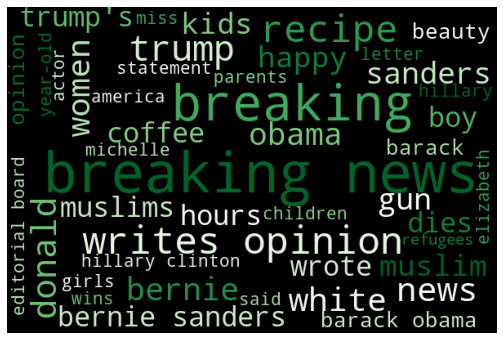

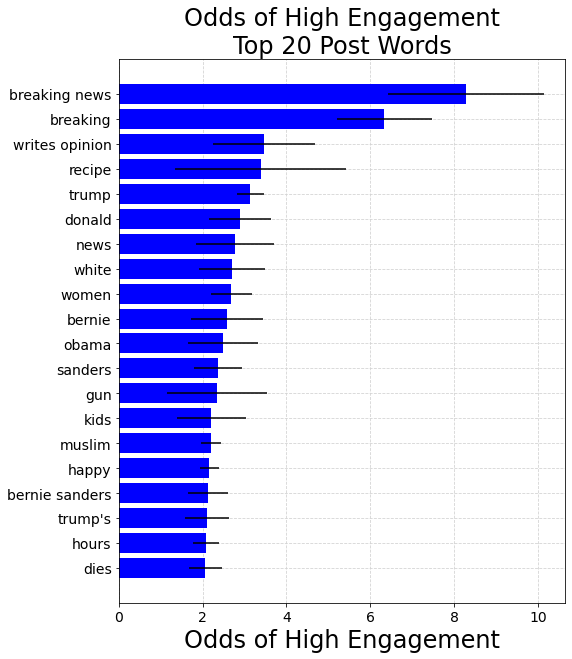

In [507]:
# Create visualizations for words with highest odds of high engagement
nlp_prep.generate_freqs_wordcloud(high_eng.loc[(high_eng['conf_min']>1) & 
                                                (high_eng['count']>1)], 
                        'Formatted Feature', high_label, 
                         cmap="Greens", min_font_size=16)

plot_topfeatures_w_conf(high_eng.loc[(high_eng['conf_min']>1) & 
                                    (high_eng['count']>1)], 
                'Formatted Feature', high_label, 20, 
               f"Top 20 Post Words", 'conf')

Of all the Facebook posts, the most common words associated with high engagement are:
- Names associated with the 2016 presidential race, such as Donald Trump, Hillary Clinton, Bernie Sanders, and Obama.
- The phrase `breaking news`
- `Recipe`, which I think mostly refers to recipes
- `writes opinion` and `opinion`, which probably refers to various opinion pieces
- The words `gun`, `women`, and `white`, which sound to me like they could represent the themes of gun violence, gender equality, and racial equality--all of which are hot topics.

### Categorical Features Only

In [70]:
_, all_ohe_feats, _, _ = get_all_data_features(best_all_binary_pipe)

high_eng.loc[high_eng["Feature"].isin(all_ohe_feats)]

Formatted Feature                       Feature  \
50                 post_type_video               post_type_video   
113                post_type_photo               post_type_photo   
201     hour_cat_5_Evening (19-23)    hour_cat_5_Evening (19-23)   
307                 on_weekend_1.0                on_weekend_1.0   
1095  hour_cat_6_Late night (23-3)  hour_cat_6_Late night (23-3)   
1153     hour_cat_3_Midday (11-15)     hour_cat_3_Midday (11-15)   

      Odds of High Engagement       std   min   max  count      conf  conf_min  
50                      1.734  0.189288  1.45  1.93    5.0  0.403533  1.330467  
113                     1.490  0.181797  1.21  1.72    5.0  0.387562  1.102438  
201                     1.356  0.050794  1.27  1.39    5.0  0.108284  1.247716  
307                     1.258  0.067602  1.14  1.31    5.0  0.144117  1.113883  
1095                    1.030       NaN  1.03  1.03    1.0  0.000000  1.030000  
1153                    1.010       NaN  1.01  1.01    1.0  0.000000  1.010000

Being a video or photo Facebook post type both increase odds of high engagement compared to a link (which was the category dropped during OHE).

Posting in the evening (from 7 PM to 11 PM Eastern) or on the weekend also increased odds of high engagement somewhat. This may be because new posts would show up in users' feeds when they're online, so they would be seen right away as opposed to being buried under newer posts.

### Low Engagement

In [235]:
low_label = 'Odds of Low Engagement'

xval_low_dfs = []

# loop through each fitted estimator and get coefficients
for i, pipe in enumerate(binary_xval_results['estimator']):
    res_df = binary_target_oddsdf(pipe, pipe.named_steps['clf'], 
                                  get_all_data_features, 
                                  low_label, class_int=0)
    
    res_df['fit_num'] = i + 1
    
    xval_low_dfs.append(res_df)
    
# combine results from each fitted estimator into one dataframe
xval_low_df = pd.concat(xval_low_dfs)

# get average odds ratios and confidence intervals

low_eng = get_mean_coefs(xval_low_df, low_label)
low_eng[50:100]

Formatted Feature        Feature  Odds of Low Engagement       std   min  \
50            follow         follow                  1.7960  0.172134  1.57   
51            trying         trying                  1.7900  0.072111  1.72   
52             cases          cases                  1.7860  0.173436  1.63   
53              join           join                  1.7800  0.227486  1.45   
54                 n              n                  1.7780  0.191755  1.49   
55          baseball       baseball                  1.7680  0.152053  1.54   
56             share          share                  1.7520  0.245703  1.47   
57           stories        stories                  1.7500  0.146287  1.56   
58              town           town                  1.7440  0.111041  1.63   
59             state          state                  1.7420  0.197535  1.60   
60            region         region                  1.7340  0.173003  1.57   
61              data           data                  1.7300  0.096695  1.61   
62              live           live                  1.7280  0.241909  1.48   
63             egypt          egypt                  1.7225  0.111467  1.62   
64              blog           blog                  1.7220  0.130843  1.52   
65        convention     convention                  1.7100  0.111355  1.60   
66           silicon        silicon                  1.7080  0.106630  1.60   
67           despite        despite                  1.7020  0.174126  1.50   
68              hong           hong                  1.7000  0.098319  1.61   
69            turkey         turkey                  1.7000  0.170294  1.49   
70            giants         giants                  1.6950  0.070000  1.61   
71              iraq           iraq                  1.6900  0.178185  1.46   
72                tv             tv                  1.6840  0.182565  1.39   
73             op-ed          op-ed                  1.6780  0.318857  1.26   
74            debate         debate                  1.6775  0.301372  1.36   
75              play           play                  1.6760  0.171406  1.46   
76            troops         troops                  1.6740  0.195013  1.37   
77             times          times                  1.6700  0.113358  1.50   
78            future         future                  1.6680  0.073959  1.57   
79             crash          crash                  1.6660  0.186091  1.35   
80            agency         agency                  1.6640  0.092358  1.54   
81           answers        answers                  1.6600  0.093005  1.55   
82           economy        economy                  1.6600  0.115326  1.50   
83            valley         valley                  1.6600  0.095656  1.53   
84             power          power                  1.6580  0.137186  1.48   
85            week's         week's                  1.6540  0.105262  1.47   
86        technology     technology                  1.6540  0.215940  1.46   
87           service        service                  1.6540  0.169647  1.40   
88             china          china                  1.6500  0.380066  1.35   
89           privacy        privacy                  1.6420  0.039623  1.59   
90                 l              l                  1.6380  0.122147  1.47   
91      surveillance   surveillance                  1.6350  0.069522  1.57   
92           weekend        weekend                  1.6320  0.184716  1.44   
93              fire           fire                  1.6280  0.107796  1.51   
94      independence   independence                  1.6275  0.045735  1.56   
95             stars          stars                  1.6260  0.079875  1.56   
96     investigators  investigators                  1.6240  0.064653  1.55   
97              four           four                  1.6240  0.245418  1.28   
98          campaign       campaign                  1.6180  0.149064  1.42   
99         insurance      insurance                  

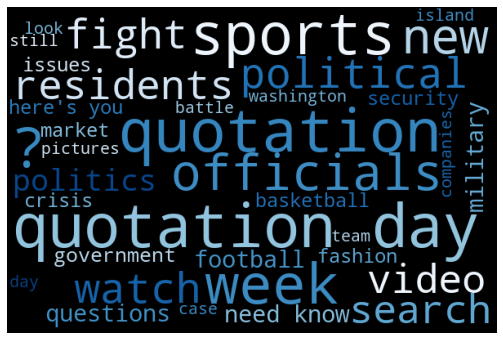

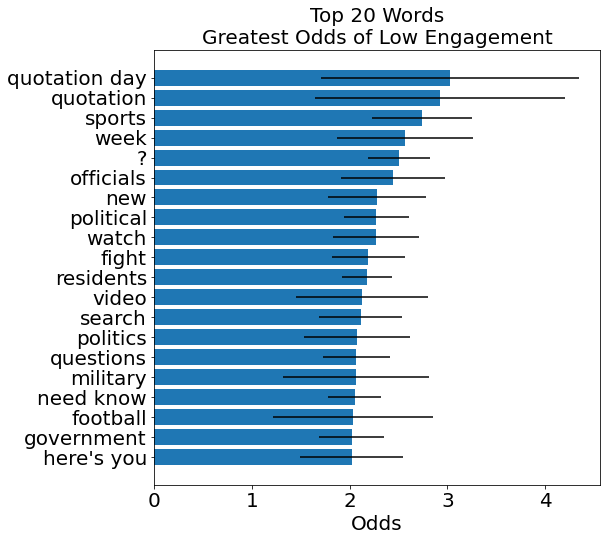

In [72]:
# Create visualizations for words with highest odds of low engagement
nlp_prep.generate_freqs_wordcloud(low_eng.loc[(low_eng['conf_min']>1) & 
                                              (low_eng['count']>1)], 
                        'Feature', low_label, 
                         cmap="Blues", min_font_size=16)

plot_topfeatures_w_conf(low_eng.loc[(low_eng['conf_min']>1) & 
                                    (low_eng['count']>1)], 
                'Formatted Feature', low_label, 20, 
               f"Greatest {low_label}", 'conf')

Words and phrases with the highest odds of low engagement are:
- `quotation day`, which is probably `quotation of the day` in full
- `week`, which may be related to weekly recaps or overviews
- `politics`, `government`, `officials`, and `political`, which sound like terms related to general political happenings
- `sports` and `football`

### Categorical Features Only

In [73]:
low_eng.loc[low_eng["Feature"].isin(all_ohe_feats)]

Formatted Feature                       Feature  \
191                post_type_other               post_type_other   
975   hour_cat_4_Afternoon (15-19)  hour_cat_4_Afternoon (15-19)   
1026     hour_cat_2_Morning (7-11)     hour_cat_2_Morning (7-11)   
1044     hour_cat_3_Midday (11-15)     hour_cat_3_Midday (11-15)   
1290  hour_cat_6_Late night (23-3)  hour_cat_6_Late night (23-3)   

      Odds of Low Engagement       std   min   max  count      conf  conf_min  
191                   1.4560  0.358022  1.25  2.09    5.0  0.763249  0.692751  
975                   1.1360  0.023022  1.10  1.16    5.0  0.049079  1.086921  
1026                  1.1260  0.027019  1.09  1.16    5.0  0.057599  1.068401  
1044                  1.1225  0.030957  1.08  1.15    4.0  0.072853  1.049647  
1290                  1.0800  0.084459  1.01  1.18    4.0  0.198763  0.881237

The `Other` post type category consisted of status, event, and note. These have slightly higher odds of resulting in a post with low engagement.

Posting between 7 AM and 7 PM, as well as from 11 PM to 3 AM, have slightly higher odds of low engagement compared to posting very late night (3 AM to 7 AM) which was the category dropped.

## Best LR Article Meta and Text model

In [74]:
# load it back in from file
best_mat_binary_pipe = joblib.load(f"{save_path}BestPipe_LR_mat_binary.joblib.gz")

In [75]:
binary_xval_art_results = cross_validate(best_mat_binary_pipe, Xmat, ymat, 
                                     return_estimator=True)

In [76]:
def get_matched_data_features(pipe):
    """Get the feature names from specific pipeline used to transform the
    matched article dataset.
    
    Returns (in order):
    - Full list of feature names
    - OHE features
    - Subject/Topic features
    - Bag of words features
    """
    cat_cols = ['section_name', 'word_count_cat', 'is_multimedia', 'has_person', 
                'has_org', 'has_geo']

    # get the feature names from OHE columns
    feature_names_ohe = list(pipe.named_steps['cols_trans']\
        .named_transformers_['ohe'].get_feature_names(cat_cols))

    # get the feature names from subject keywords
    feature_names_txt1 = pipe.named_steps['cols_trans']\
        .named_transformers_['txt_kw'].get_feature_names()

    # add "sub_" to beginning of each subject feature name so they can be told
    # apart from article text
    feature_names_txt1 = ['sub_' + kw for kw in feature_names_txt1]

    # get the feature names from bag of words
    feature_names_txt2 = pipe.named_steps['cols_trans']\
        .named_transformers_['txt'].named_steps['vect'].get_feature_names()

    # combine the feature lists
    feature_names = feature_names_ohe + feature_names_txt1 + feature_names_txt2

    return feature_names, feature_names_ohe, feature_names_txt1, \
        feature_names_txt2

### High Engagement

In [77]:
xval_high_art_dfs = []

# loop through each fitted estimator and get coefficients
for i, pipe in enumerate(binary_xval_art_results['estimator']):
    res_df = binary_target_oddsdf(pipe, pipe.named_steps['clf'], 
                                  get_matched_data_features, 
                                  high_label, class_int=1)
    
    res_df['fit_num'] = i + 1
    
    xval_high_art_dfs.append(res_df)
    
# combine results from each fitted estimator into one dataframe
xval_high_art_df = pd.concat(xval_high_art_dfs)

# get average odds ratios and confidence intervals

high_eng_art = get_mean_coefs(xval_high_art_df, high_label)
high_eng_art.head(20)

Formatted Feature  \
0                    section_name_Cooking   
1                                   obama   
2           Paris Attacks (November 2015)   
3                                  donald   
4                                 sanders   
5                                    Cats   
6           Presidential Election Of 2016   
7            Archaeology And Anthropology   
8                               president   
9                                   trump   
10                                 bernie   
11  Middle East And Africa Migrant Crisis   
12                               comments   
13                              Happiness   
14       Animal Abuse, Rights And Welfare   
15                                world's   
16                                   said   
17       Chronic Traumatic Encephalopathy   
18                    Deaths (Obituaries)   
19                                 letter   

                                      Feature  Odds of High Engagement  \
0                        section_name_Cooking                    3.034   
1                                       obama                    2.676   
2           sub_paris attacks (november 2015)                    2.550   
3                                      donald                    2.170   
4                                     sanders                    2.160   
5                                    sub_cats                    2.126   
6           sub_presidential election of 2016                    2.088   
7            sub_archaeology and anthropology                    2.048   
8                                   president                    2.004   
9                                       trump                    1.958   
10                                     bernie                    1.954   
11  sub_middle east and africa migrant crisis                    1.920   
12                                   comments                    1.906   
13                              sub_happiness                    1.868   
14       sub_animal abuse, rights and welfare                    1.864   
15                                    world's                    1.862   
16                                       said                    1.850   
17       sub_chronic traumatic encephalopathy                    1.830   
18                    sub_deaths (obituaries)                    1.822   
19                                     letter                    1.814   

         std   min   max  count      conf  conf_min  
0   0.614435  2.39  4.03    5.0  1.309881  1.724119  
1   0.253535  2.33  3.01    5.0  0.540498  2.135502  
2   1.669990  1.54  5.04    4.0  3.930093 -1.380093  
3   0.416893  1.74  2.78    5.0  0.888753  1.281247  
4   0.393383  1.72  2.78    5.0  0.838632  1.321368  
5   0.255108  1.92  2.49    5.0  0.543851  1.582149  
6   0.129885  1.90  2.23    5.0  0.276894  1.811106  
7   0.390474  1.52  2.47    5.0  0.832431  1.215569  
8   0.107145  1.91  2.17    5.0  0.228416  1.775584  
9   0.426931  1.41  2.53    5.0  0.910151  1.047849  
10  0.412953  1.48  2.58    5.0  0.880352  1.073648  
11  0.295409  1.67  2.34    4.0  0.695205  1.224795  
12  0.238810  1.48  2.03    5.0  0.509105  1.396895  
13  0.103296  1.74  1.99    5.0  0.220211  1.647789  
14  0.155499  1.63  2.03    5.0  0.331500  1.532500  
15  0.162080  1.64  2.03    5.0  0.345530  1.516470  
16  0.225610  1.56  2.17    5.0  0.480967  1.369033  
17  0.185876  1.57  2.01    5.0  0.396260  1.433740  
18  0.122760  1.68  1.96    5.0  0.261705  1.560295  
19  0.273551  1.38  2.07    5.0  0.583168  1.230832

I see an interesting mix of predictors of high engagement from the matched articles model. The subject metadata definitely made the results differ from the Facebook post data, in which we didn't have subjects.

- As with the Facebook model, words and phrases related to the president and election are top predictors. The subject "Presidential Election of 2016" is also a top predictor.
- Apart from that, we have a pretty eclectic mix of subjects. Some are fairly neutral topics that people probably don't have strong feelings about: Cooking, Archeology and Anthropology, Cats, Walking, Happiness, Mathematics, iPhone.
- Other subjects may be controversial, or at the least subjects that people tend to have strong feelings about: Muslim Americans, Animal Abuse, Rights and Welfare
- Another trend in top subjects is beauty related: Hair, Beauty Contests, Cosmetics and Toiletries
- Although Sports was a top predictor of low engagement in the Facebook model, the 2016 Olympics was a top subject here
- Deaths and Obituaries are also a top predictor of high engagement, which I had seen during EDA

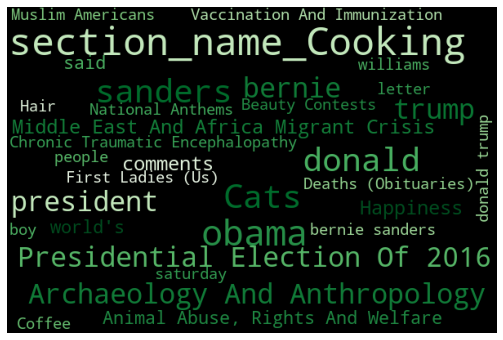

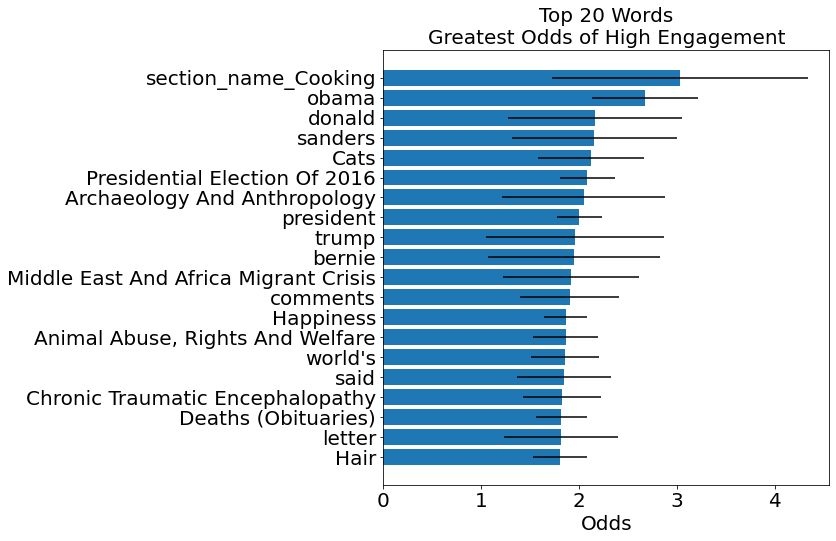

In [78]:
# Create visualizations for words with highest odds of high engagement
nlp_prep.generate_freqs_wordcloud(high_eng_art.loc[(high_eng_art['conf_min']>1) 
                                            & (high_eng_art['count']>1)], 
                        'Formatted Feature', high_label, 
                         cmap="Greens", min_font_size=16)

plot_topfeatures_w_conf(high_eng_art.loc[(high_eng_art['conf_min']>1) 
                        & (high_eng_art['count']>1)], 
               'Formatted Feature', high_label, 20, 
               f"Greatest {high_label}", 'conf')

### Categorical Features Only

In [79]:
_, mat_ohe_feats, mat_sub_feats, _ = get_matched_data_features(
    best_mat_binary_pipe)

high_eng_art.loc[(high_eng_art["Feature"].isin(mat_ohe_feats)) & 
                 (high_eng_art["conf_min"]>1) & 
                 (high_eng_art["count"]>1)]

Formatted Feature                   Feature  \
0         section_name_Cooking      section_name_Cooking   
745        word_count_cat_None       word_count_cat_None   
841         word_count_cat_Low        word_count_cat_Low   
1245  section_name_Real Estate  section_name_Real Estate   
1708              has_person_1              has_person_1   

      Odds of High Engagement       std   min   max  count      conf  conf_min  
0                      3.0340  0.614435  2.39  4.03    5.0  1.309881  1.724119  
745                    1.1880  0.017889  1.17  1.21    5.0  0.038136  1.149864  
841                    1.1700  0.044721  1.12  1.24    5.0  0.095339  1.074661  
1245                   1.1225  0.040311  1.08  1.17    4.0  0.094867  1.027633  
1708                   1.0880  0.020494  1.07  1.12    5.0  0.043690  1.044310

### Subject KWs Only

In [506]:
# high_eng_art.loc[(high_eng_art["Feature"].isin(mat_sub_feats)) & 
#                  (high_eng_art["conf_min"]>1) & 
#                  (high_eng_art["count"]>1)][:300].\
#     to_csv('data/high_kws.csv')

high_eng_art.loc[(high_eng_art["Feature"].isin(mat_sub_feats)) & 
                  (high_eng_art["conf_min"]>1) & 
                  (high_eng_art["count"]>1), ['Formatted Feature', high_label]][:20]

Formatted Feature  Odds of High Engagement
5                                    Cats                   2.1260
6           Presidential Election Of 2016                   2.0880
7            Archaeology And Anthropology                   2.0480
11  Middle East And Africa Migrant Crisis                   1.9200
13                              Happiness                   1.8680
14       Animal Abuse, Rights And Welfare                   1.8640
17       Chronic Traumatic Encephalopathy                   1.8300
18                    Deaths (Obituaries)                   1.8220
20                                   Hair                   1.8060
23           Vaccination And Immunization                   1.7840
24                      First Ladies (Us)                   1.7620
25                        Beauty Contests                   1.7480
26                       Muslim Americans                   1.7460
29                       National Anthems                   1.7150
32                                 Coffee                   1.6880
34                   Olympic Games (2016)                   1.6760
37                                  Lions                   1.6575
38               Cosmetics And Toiletries                   1.6540
39                            Mathematics                   1.6540
40                              Marriages                   1.6440

### Low Engagement

In [81]:
xval_low_art_dfs = []

# loop through each fitted estimator and get coefficients
for i, pipe in enumerate(binary_xval_art_results['estimator']):
    res_df = binary_target_oddsdf(pipe, pipe.named_steps['clf'], 
                                  get_matched_data_features, 
                                  low_label, class_int=0)
    
    res_df['fit_num'] = i + 1
    
    xval_low_art_dfs.append(res_df)
    
# combine results from each fitted estimator into one dataframe
xval_low_art_df = pd.concat(xval_low_art_dfs)

# get average odds ratios and confidence intervals

low_eng_art = get_mean_coefs(xval_low_art_df, low_label)
low_eng_art.head(20)

Formatted Feature  \
0                       Midterm Elections (2014)   
1                  Paris Attacks (November 2015)   
2                                    Ebola Virus   
3        European Sovereign Debt Crisis (2010- )   
4                  Murders And Attempted Murders   
5                            Mobile Applications   
6                                       ferguson   
7                        World Cup 2014 (Soccer)   
8                                       security   
9                  September Fashion Week (2014)   
10        Automobile Safety Features And Defects   
11                  Social Networking (Internet)   
12                                           may   
13                       section_name_Technology   
14  Middle East And North Africa Unrest (2010- )   
15                section_name_Multimedia/Photos   
16                                        toward   
17                                      briefing   
18                                        sports   
19                                           new   

                                             Feature  Odds of Low Engagement  \
0                       sub_midterm elections (2014)                   3.545   
1                  sub_paris attacks (november 2015)                   2.900   
2                                    sub_ebola virus                   2.590   
3        sub_european sovereign debt crisis (2010- )                   2.400   
4                  sub_murders and attempted murders                   2.220   
5                            sub_mobile applications                   2.214   
6                                           ferguson                   2.206   
7                        sub_world cup 2014 (soccer)                   2.185   
8                                           security                   2.034   
9                  sub_september fashion week (2014)                   1.925   
10        sub_automobile safety features and defects                   1.914   
11                  sub_social networking (internet)                   1.870   
12                                               may                   1.860   
13                           section_name_Technology                   1.856   
14  sub_middle east and north africa unrest (2010- )                   1.844   
15                    section_name_Multimedia/Photos                   1.826   
16                                            toward                   1.824   
17                                          briefing                   1.805   
18                                            sports                   1.802   
19                                               new                   1.796   

         std   min   max  count       conf  conf_min  
0   0.977429  3.02  5.01    4.0   2.300245  1.244755  
1        NaN  2.90  2.90    1.0   0.000000  2.900000  
2   1.587535  1.75  4.97    4.0   3.736046 -1.146046  
3        NaN  2.40  2.40    1.0   0.000000  2.400000  
4   1.004988  1.16  3.89    5.0   2.142479  0.077521  
5   0.261496  1.86  2.48    5.0   0.557469  1.656531  
6   0.534256  1.43  2.92    5.0   1.138953  1.067047  
7   1.647559  1.02  3.35    2.0  10.402277 -8.217277  
8   0.169499  1.82  2.25    5.0   0.361346  1.672654  
9   0.131783  1.75  2.06    4.0   0.310132  1.614868  
10  0.241516  1.75  2.34    5.0   0.514875  1.399125  
11  0.029439  1.84  1.90    4.0   0.069281  1.800719  
12  0.099247  1.76  2.01    5.0   0.211580  1.648420  
13  0.105736  1.69  1.96    5.0   0.225412  1.630588  
14  0.235223  1.51  2.04    5.0   0.501460  1.342540  
15  0.392658  1.57  2.52    5.0   0.837086  0.988914  
16  0.142408  1.67  2.03    5.0   0.303592  1.520408  
17  0.067577  1.72  1.88    4.0   0.159034  1.645966  
18  0.072250  1.70  1.88    5.0   0.154025  1.647975  
19  0.317380  1.48  2.27    5.0   0.676605  1.119395

- Although the presidential election was a top predictor of high engagement, general words such as `government`, and subjects such as 2014 Midterm Elections, Political Advertising, Jury System, and Politics and Government are top predictors of low engagement. My reading of this is that the competition of the presidential election drew people in, but every day political events are less engaging.
- Some top predictors are also far away from the US, such as Ebola Virus, Middle East and North Africa Unrest, Brussels Attacks.
- Interestingly, the subject Multimedia/Photos is a top predictor of low, although when looking at the types of Facebook posts videos and photos seemed to get more engagement. It may be there is a difference between these classifications.

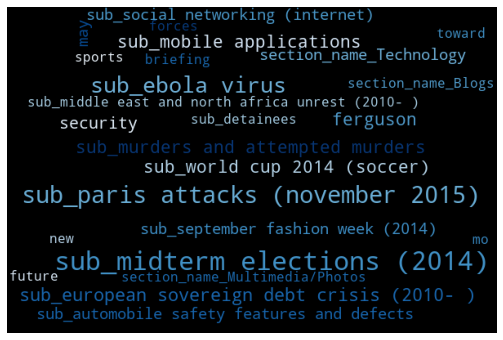

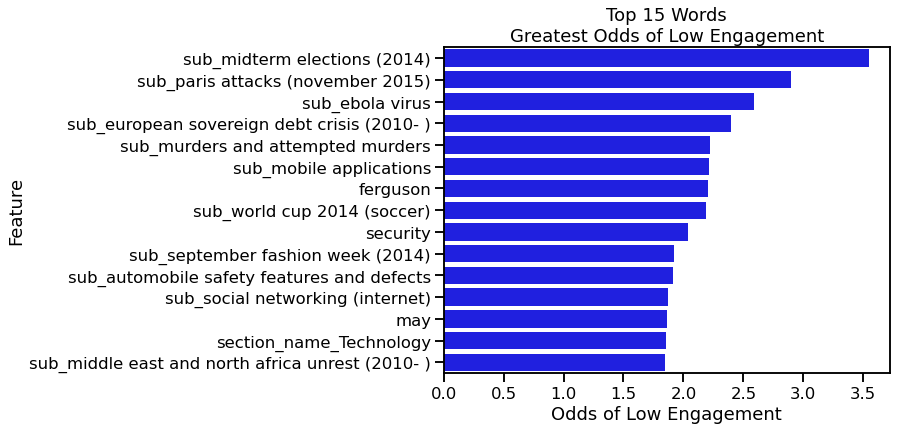

In [82]:
# Create visualizations for words with highest odds of low engagement
nlp_prep.generate_freqs_wordcloud(low_eng_art, 'Feature', low_label, 
                         cmap="Blues", min_font_size=16)

nlp_prep.plot_wordfreqs(low_eng_art, 'Feature', low_label, 15, 
               f"Greatest {low_label}")

### Categorical Features Only

In [83]:
low_eng_art.loc[(low_eng_art["Feature"].isin(mat_ohe_feats)) & 
                 (low_eng_art["conf_min"]>1) & 
                 (low_eng_art["count"]>1)]

Formatted Feature                    Feature  \
13      section_name_Technology    section_name_Technology   
22           section_name_Blogs         section_name_Blogs   
44        section_name_New York      section_name_New York   
60           section_name_Books         section_name_Books   
78       section_name_Education     section_name_Education   
81          section_name_Sports        section_name_Sports   
86           section_name_World         section_name_World   
103        section_name_Theater       section_name_Theater   
113        section_name_Science       section_name_Science   
172     section_name_Your Money    section_name_Your Money   
191           section_name_Food          section_name_Food   
287   section_name_Business Day  section_name_Business Day   
636          section_name_Other         section_name_Other   
780           section_name_U.S.          section_name_U.S.   
2510                  has_org_1                  has_org_1   
3857        word_count_cat_High        word_count_cat_High   

      Odds of Low Engagement       std   min   max  count      conf  conf_min  
13                     1.856  0.105736  1.69  1.96    5.0  0.225412  1.630588  
22                     1.762  0.209452  1.43  2.01    5.0  0.446519  1.315481  
44                     1.634  0.101637  1.51  1.74    5.0  0.216674  1.417326  
60                     1.584  0.205256  1.42  1.94    5.0  0.437574  1.146426  
78                     1.548  0.116490  1.35  1.64    5.0  0.248340  1.299660  
81                     1.540  0.086023  1.41  1.64    5.0  0.183388  1.356612  
86                     1.534  0.070214  1.47  1.65    5.0  0.149685  1.384315  
103                    1.508  0.128725  1.38  1.69    5.0  0.274421  1.233579  
113                    1.488  0.046583  1.46  1.57    5.0  0.099308  1.388692  
172                    1.424  0.073007  1.35  1.54    5.0  0.155639  1.268361  
191                    1.404  0.124619  1.24  1.51    5.0  0.265670  1.138330  
287                    1.344  0.049295  1.26  1.39    5.0  0.105089  1.238911  
636                    1.236  0.082946  1.13  1.35    5.0  0.176828  1.059172  
780                    1.208  0.078549  1.08  1.29    5.0  0.167455  1.040545  
2510                   1.070  0.022361  1.04  1.10    5.0  0.047670  1.022330  
3857                   1.026  0.011402  1.01  1.04    5.0  0.024307  1.001693

### Subject KWs Only

In [248]:
# low_eng_art.loc[(low_eng_art["Feature"].isin(mat_sub_feats)) & 
#                  (low_eng_art["conf_min"]>1) & 
#                  (low_eng_art["count"]>1)][:300].\
#     to_csv('data/low_kws.csv')

## FB - Review Prediction Accuracy

In [85]:
# Get predictions for X (binary problem)
preds_all = best_all_binary_pipe.predict(X_test_all)

In [86]:
Xtest_all_df = X_test_all.copy()
Xtest_all_df['fb_pred'] = preds_all
Xtest_all_df.tail()

cleaned post_type  \
15316   Reported Dead in India as Guru Remains Walled...      link   
12423  Loyal to the Royals, Hoping for a Renaissance....      link   
19201  Yutaka Katayama, Father of the Datsun 'Z,' Die...      link   
33968  U. S. Presses for Haiti Runoff Vote Amid Fears...      link   
26520  Pope Francis Urges Priests to Welcome Remarrie...      link   

                  hour_cat  on_weekend  fb_pred  
15316     3_Midday (11-15)         0.0      0.0  
12423  6_Late night (23-3)         0.0      0.0  
19201    5_Evening (19-23)         0.0      1.0  
33968  6_Late night (23-3)         0.0      0.0  
26520    5_Evening (19-23)         0.0      1.0

In [87]:
df = df.join(Xtest_all_df[['fb_pred']])
df[['cleaned', 'fb_pred', 'all_binary']].head()

cleaned  fb_pred  all_binary
0  Did Barack Obama Save Ohio?. 'There are severa...      NaN         0.0
1  The Weatherman Is Not a Moron. In , the chance...      NaN         0.0
2  The Organic Fable. 'Organic has long since bec...      NaN         0.0
3  Timeline Photos. Our special Arts & Leisure se...      NaN         0.0
4  Pot for Parents. 'When I'm rolling around the ...      NaN         0.0

In [88]:
predict_cols = ['cleaned', 'fb_pred', 'all_binary',
            'max_pct', 'mean_pct', 'comments_pct', 'comments_count',  
            'shares_pct', 'shares_count', 'likesloves_pct', 'likes_loves']

df.loc[df['fb_pred'].isna()==False, predict_cols]

cleaned  fb_pred  all_binary  \
9      Five Crucial Factors to Watch, Just Days From ...      0.0         0.0   
11     Playing Now: Hail to Us Chiefs. Op-Ed columnis...      0.0         0.0   
12     Mow Yard. Drop Off Kids. Take a Drive on Mars....      0.0         0.0   
15     With No Contract Deal by Deadline in Chicago, ...      0.0         0.0   
20     Teacher Strike Begins in Chicago, Amid Signs T...      0.0         0.0   
...                                                  ...      ...         ...   
47816  After the Florence Flood: Saving Vasari's 'Las...      0.0         0.0   
47828  Donald Trump's Extremist Supporters Feel Like ...      1.0         1.0   
47850  A Coup Against the Supreme Court. Regardless o...      1.0         1.0   
47854  An Unfinished Presidency: Obama Passes the Bat...      1.0         1.0   
47857  Mannequin Challenge Is the New Viral Video Sen...      0.0         0.0   

        max_pct  mean_pct  comments_pct  comments_count  shares_pct  \
9      0.348295  0.271887      0.348295              46    0.305833   
11     0.398613  0.200274      0.398613              54    0.121046   
12     0.365322  0.283329      0.122237              19    0.365322   
15     0.404692  0.293375      0.404692              55    0.282957   
20     0.216114  0.146962      0.122237              19    0.216114   
...         ...       ...           ...             ...         ...   
47816  0.355503  0.236340      0.094942              16    0.355503   
47828  0.955072  0.840228      0.955072             657    0.950748   
47850  0.965497  0.899894      0.877314             327    0.965497   
47854  0.860705  0.755721      0.860705             294    0.592675   
47857  0.498015  0.459394      0.498015              73    0.407910   

       shares_count  likesloves_pct  likes_loves  
9                72        0.161534          245  
11               30        0.081164          164  
12               90        0.362428          474  
15               66        0.192475          277  
20               49        0.102536          187  
...             ...             ...          ...  
47816            87        0.258576          347  
47828          1810        0.614862          992  
47850          2309        0.856871         2801  
47854           209        0.813782         2190  
47857           105        0.472256          649  

[9574 rows x 11 columns]

### Was High, predicted Low

In [89]:
total = len(df.loc[df['fb_pred'].isna()==False])
print(total)

total_wrong = len(df.loc[(df['all_binary']==1) & (df['fb_pred']==0)])
total_wrong

9574


741

In [90]:
df.loc[(df['all_binary']==1) & (df['fb_pred']==0), predict_cols].describe()

fb_pred  all_binary     max_pct    mean_pct  comments_pct  \
count    741.0       741.0  741.000000  741.000000    741.000000   
mean       0.0         1.0    0.922576    0.853117      0.828850   
std        0.0         0.0    0.050658    0.064557      0.112267   
min        0.0         1.0    0.764311    0.750017      0.489115   
25%        0.0         1.0    0.888689    0.798037      0.752204   
50%        0.0         1.0    0.932050    0.847731      0.845799   
75%        0.0         1.0    0.963701    0.902304      0.923944   
max        0.0         1.0    0.999937    0.998127      0.998976   

       comments_count  shares_pct  shares_count  likesloves_pct    likes_loves  
count      741.000000  741.000000    741.000000      741.000000     741.000000  
mean       389.218623    0.874803   1388.661269        0.855698    5203.685560  
std        390.778074    0.084870   1773.466102        0.098922   10531.178824  
min         71.000000    0.568075    190.000000        0.481480     666.000000  
25%        174.000000    0.828908    613.000000        0.792201    1971.000000  
50%        269.000000    0.890204    933.000000        0.871004    3077.000000  
75%        468.000000    0.940093   1560.000000        0.933909    5355.000000  
max       4347.000000    0.999373  29024.000000        0.999937  241832.000000

799 of the 9,574 posts in the test set were incorrectly classified as low engagement although they should have been high (defined as average engagement metric percentile being above 75th). 

The percentiles for comments, shares, and likes/loves are all consistently above 75, so I don't see any particular patterns. The model just wasn't able to pick up on whatever trends these represented.

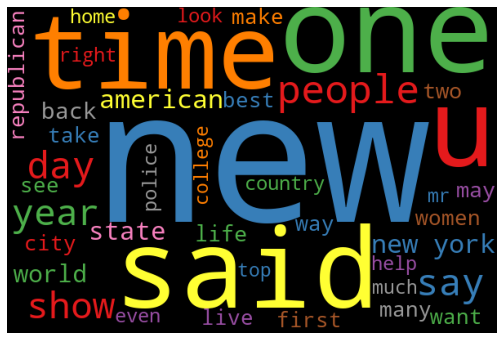

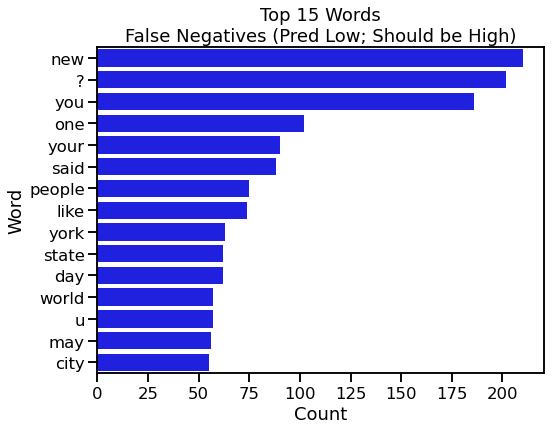

In [500]:
# False Negatives word frequencies
fn_token_dict = nlp_prep.tokenize_corpus_dict_tweet(
    df.loc[(df['all_binary']==1) & (df['fb_pred']==0)], [0, 1], 
    target_col='all_binary', stop_list=custom_stopwords + custom_punc, 
                                                 verbose=False)

fn_tokens = []
[fn_tokens.extend(tokens) for tokens in fn_token_dict.values()]

fn_corpus = FreqDist(fn_tokens)

fn_freq_df = pd.DataFrame(fn_corpus.most_common(100),
                              columns=['Word','Count'])

nlp_prep.generate_wordcloud(docs=fn_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=16, 
                  title='')

nlp_prep.plot_wordfreqs(fn_freq_df, 'Word', 'Count', 15, 
               "False Negatives (Pred Low; Should be High)")

Even though I removed the you/your permutations from the stopwords list during modeling, the models still didn't pick up on those words being predictors of High engagement. I see here that you and your appear frequently in the posts that should have been classified as High but were mis-classified as Low. It's possible that TF-IDF normalization worked against me in that regard.

Otherwise, the top words look pretty average to me.

### Was Low, predicted High

In [92]:
print(total)

total_wrong2 = len(df.loc[(df['all_binary']==0) & (df['fb_pred']==1)])
total_wrong2

9574


2556

In [93]:
df.loc[(df['all_binary']==0) & (df['fb_pred']==1), predict_cols].describe()

fb_pred  all_binary      max_pct     mean_pct  comments_pct  \
count   2556.0      2556.0  2556.000000  2556.000000   2556.000000   
mean       1.0         0.0     0.610125     0.464355      0.471689   
std        0.0         0.0     0.219050     0.189397      0.249721   
min        1.0         0.0     0.006069     0.002197      0.000460   
25%        1.0         0.0     0.465905     0.324971      0.266295   
50%        1.0         0.0     0.649710     0.489295      0.474951   
75%        1.0         0.0     0.783667     0.623322      0.666402   
max        1.0         0.0     0.995717     0.749979      0.995717   

       comments_count   shares_pct  shares_count  likesloves_pct   likes_loves  
count     2556.000000  2556.000000   2556.000000     2556.000000   2556.000000  
mean       106.342332     0.450536    182.411189        0.470838    906.440923  
std        133.071523     0.230787    174.651374        0.230287    983.758131  
min          0.000000     0.006069      0.000000        0.000063      0.000000  
25%         35.000000     0.271644     63.000000        0.291102    384.750000  
50%         68.000000     0.470846    133.000000        0.487126    676.500000  
75%        126.000000     0.636527    248.000000        0.649005   1113.250000  
max       2270.000000     0.959481   2064.000000        0.994589  28470.000000

2,408 of the 9,574 posts in the test set were incorrectly classified as high engagement although they should have been low (defined as average engagement metric percentile being below 75th). 

The percentiles for comments, shares, and likes/loves are all consistently below 75, so I don't see any particular patterns.

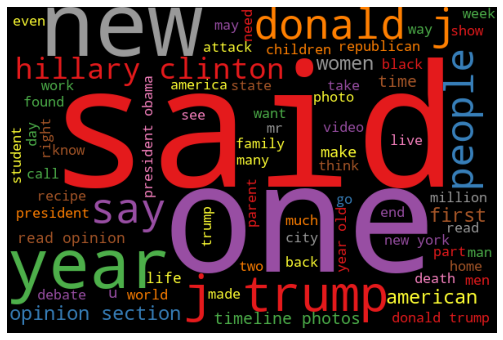

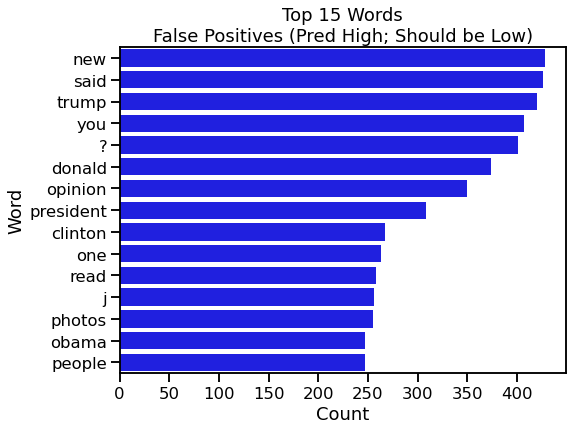

In [501]:
# False Positives word frequencies
fp_token_dict = nlp_prep.tokenize_corpus_dict_tweet(
    df.loc[(df['all_binary']==0) & (df['fb_pred']==1)], [0, 1], 
    target_col='all_binary', stop_list=custom_stopwords + custom_punc, 
                                                 verbose=False)

fp_tokens = []
[fp_tokens.extend(tokens) for tokens in fp_token_dict.values()]

fp_corpus = FreqDist(fp_tokens)

fp_freq_df = pd.DataFrame(fp_corpus.most_common(100),
                              columns=['Word','Count'])

nlp_prep.generate_wordcloud(docs=fp_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=16, 
                  title='False Positives (should be Low)')

nlp_prep.plot_wordfreqs(fp_freq_df, 'Word', 'Count', 15, 
               "False Positives (Pred High; Should be Low)")

I see lots of mentions of presidential stuff (Trump, Clinton, President), as well as Opinion. I can see why these might have been mis-classified as High even though they were Low.

## Matched - Review Prediction Accuracy

In [95]:
# Get predictions for X (binary problem)
preds_mat = best_mat_binary_pipe.predict(X_test_mat)

In [96]:
Xtest_mat_df = X_test_mat.copy()
Xtest_mat_df['mat_pred'] = preds_mat
Xtest_mat_df.tail()

cleaned  \
40467  When Bullets Hit Bystanders. A barber at work....   
21939  Ask Well: Do Microwaves Degrade Food Nutrients...   
27556  In Stieg Larsson's Head, but His Own Man. Davi...   
7780   From Virginia, Chasing Down Credit Suisse. The...   
2505   Are Doctors Nicer to Thinner Patients?. Transc...   

                                                 subject  section_name  \
40467  [murders, attempted murders and homicides, fir...          U.S.   
21939  [diet and nutrition, food, microwave ovens, vi...        Health   
27556                             [books and literature]         Books   
7780   [banking and financial institutions, securitie...  Business Day   
2505                 [doctors, empathy, obesity, weight]        Health   

      word_count_cat  is_multimedia  has_person  has_org  has_geo  mat_pred  
40467           None            1.0           0        0        1       1.0  
21939            Low            0.0           0        0        0       1.0  
27556           High            0.0           1        0        1       0.0  
7780            High            0.0           1        1        1       0.0  
2505         Average            0.0           0        0        0       1.0

In [97]:
df = df.join(Xtest_mat_df[['mat_pred']])
df[['cleaned', 'mat_pred', 'm_binary']].head()

cleaned  mat_pred  m_binary
0  Did Barack Obama Save Ohio?. 'There are severa...       NaN       0.0
1  The Weatherman Is Not a Moron. In , the chance...       NaN       0.0
2  The Organic Fable. 'Organic has long since bec...       NaN       0.0
3  Timeline Photos. Our special Arts & Leisure se...       NaN       0.0
4  Pot for Parents. 'When I'm rolling around the ...       NaN       0.0

In [98]:
predict_cols = ['cleaned', 'mat_pred', 'm_binary',
            'max_pct', 'mean_pct', 'comments_pct', 'comments_count',  
            'shares_pct', 'shares_count', 'likesloves_pct', 'likes_loves']

df.loc[df['mat_pred'].isna()==False, predict_cols]

cleaned  mat_pred  m_binary  \
9      Five Crucial Factors to Watch, Just Days From ...       0.0       0.0   
11     Playing Now: Hail to Us Chiefs. Op-Ed columnis...       1.0       0.0   
12     Mow Yard. Drop Off Kids. Take a Drive on Mars....       0.0       0.0   
19     A Terrifying Way to Discipline Children. Op-Ed...       1.0       0.0   
20     Teacher Strike Begins in Chicago, Amid Signs T...       0.0       0.0   
...                                                  ...       ...       ...   
47848  Donald Trump's Big Bet on Less Educated Whites...       0.0       1.0   
47850  A Coup Against the Supreme Court. Regardless o...       1.0       1.0   
47853   Senate Election Forecast. The Democrats are s...       0.0       0.0   
47854  An Unfinished Presidency: Obama Passes the Bat...       1.0       1.0   
47855  Strangers Help a Wheelchair Racer (and Find Ou...       0.0       0.0   

        max_pct  mean_pct  comments_pct  comments_count  shares_pct  \
9      0.348295  0.271887      0.348295              46    0.305833   
11     0.398613  0.200274      0.398613              54    0.121046   
12     0.365322  0.283329      0.122237              19    0.365322   
19     0.668700  0.471570      0.585551              96    0.668700   
20     0.216114  0.146962      0.122237              19    0.216114   
...         ...       ...           ...             ...         ...   
47848  0.942705  0.871485      0.942705             563    0.917217   
47850  0.965497  0.899894      0.877314             327    0.965497   
47853  0.747107  0.581565      0.613860             105    0.383727   
47854  0.860705  0.755721      0.860705             294    0.592675   
47855  0.632087  0.355614      0.103852              17    0.330903   

       shares_count  likesloves_pct  likes_loves  
9                72        0.161534          245  
11               30        0.081164          164  
12               90        0.362428          474  
19              283        0.160458          244  
20               49        0.102536          187  
...             ...             ...          ...  
47848          1182        0.754533         1666  
47850          2309        0.856871         2801  
47853            96        0.747107         1615  
47854           209        0.813782         2190  
47855            79        0.632087         1050  

[8646 rows x 11 columns]

### Was High, predicted Low

In [99]:
total = len(df.loc[df['mat_pred'].isna()==False])
print(total)

total_wrong = len(df.loc[(df['m_binary']==1) & (df['mat_pred']==0)])
total_wrong

8646


734

In [100]:
df.loc[(df['m_binary']==1) & (df['mat_pred']==0), predict_cols].describe()

mat_pred  m_binary     max_pct    mean_pct  comments_pct  \
count     734.0     734.0  734.000000  734.000000    734.000000   
mean        0.0       1.0    0.913731    0.845256      0.825223   
std         0.0       0.0    0.056349    0.067288      0.111031   
min         0.0       1.0    0.760529    0.746208      0.410949   
25%         0.0       1.0    0.874023    0.784195      0.749133   
50%         0.0       1.0    0.919374    0.836004      0.842320   
75%         0.0       1.0    0.962588    0.899561      0.911367   
max         0.0       1.0    0.999896    0.997458      0.998997   

       comments_count  shares_pct  shares_count  likesloves_pct    likes_loves  
count      734.000000  734.000000    734.000000      734.000000     734.000000  
mean       377.170300    0.861691   1306.683924        0.848854    4979.062670  
std        389.319152    0.092653   1594.849369        0.096793   10138.454304  
min         56.000000    0.465153    130.000000        0.505787     714.000000  
25%        172.000000    0.803430    527.250000        0.781243    1870.750000  
50%        264.000000    0.877925    846.500000        0.860303    2870.500000  
75%        418.750000    0.934426   1445.000000        0.927874    4980.750000  
max       4372.000000    0.999206  24431.000000        0.999896  231311.000000

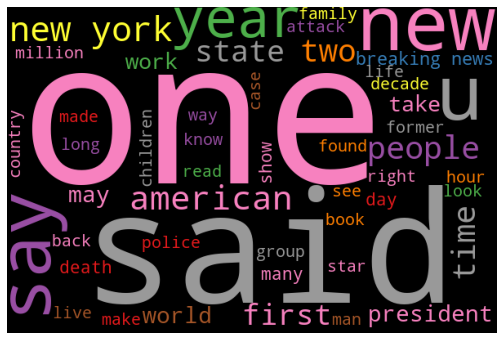

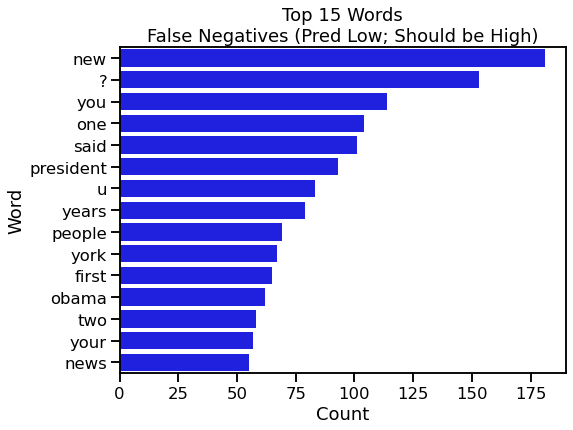

In [101]:
# False Negatives word frequencies
fn_token_dict = nlp_prep.tokenize_corpus_dict_tweet(
    df.loc[(df['m_binary']==1) & (df['mat_pred']==0)], [0, 1], 
    target_col='m_binary', stop_list=custom_stopwords + custom_punc, 
                                                 verbose=False)

fn_tokens = []
[fn_tokens.extend(tokens) for tokens in fn_token_dict.values()]

fn_corpus = FreqDist(fn_tokens)

fn_freq_df = pd.DataFrame(fn_corpus.most_common(100),
                              columns=['Word','Count'])

nlp_prep.generate_wordcloud(docs=fn_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=16, 
                  title='')

nlp_prep.plot_wordfreqs(fn_freq_df, 'Word', 'Count', 15, 
               "False Negatives (Pred Low; Should be High)")

### Was Low, predicted High

In [102]:
print(total)

total_wrong2 = len(df.loc[(df['m_binary']==0) & (df['mat_pred']==1)])
total_wrong2

8646


2156

In [103]:
df.loc[(df['m_binary']==0) & (df['mat_pred']==1), predict_cols].describe()

mat_pred  m_binary      max_pct     mean_pct  comments_pct  \
count    2156.0    2156.0  2156.000000  2156.000000   2156.000000   
mean        1.0       0.0     0.622489     0.472516      0.493624   
std         0.0       0.0     0.212754     0.184941      0.246447   
min         1.0       0.0     0.014206     0.005258      0.000460   
25%         1.0       0.0     0.489397     0.334785      0.304653   
50%         1.0       0.0     0.664893     0.501099      0.493482   
75%         1.0       0.0     0.791564     0.629524      0.686030   
max         1.0       0.0     0.989471     0.745278      0.989471   

       comments_count   shares_pct  shares_count  likesloves_pct  likes_loves  
count     2156.000000  2156.000000   2156.000000     2156.000000  2156.000000  
mean       112.366883     0.466804    189.738404        0.457119   823.566790  
std        124.619344     0.224532    168.525755        0.226952   683.290416  
min          0.000000     0.006069      0.000000        0.000731     9.000000  
25%         40.000000     0.291167     68.000000        0.281567   373.000000  
50%         72.000000     0.487413    141.000000        0.477359   658.500000  
75%        135.000000     0.645484    257.250000        0.638292  1071.250000  
max       1513.000000     0.934860   1455.000000        0.961497  8031.000000

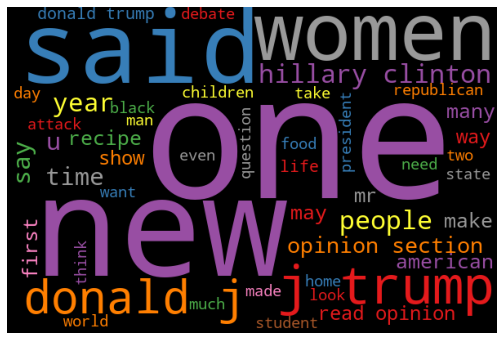

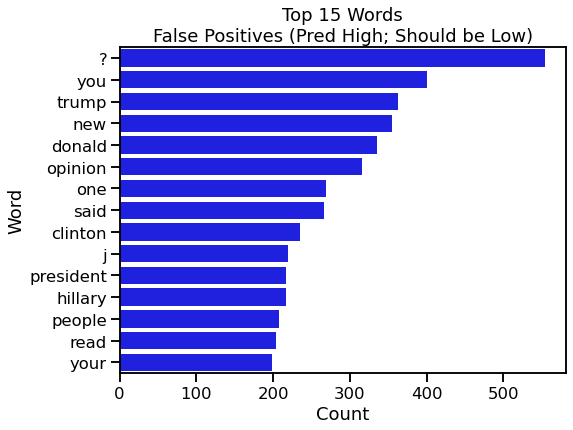

In [104]:
# False Positives word frequencies
fp_token_dict = nlp_prep.tokenize_corpus_dict_tweet(
    df.loc[(df['m_binary']==0) & (df['mat_pred']==1)], [0, 1], 
    target_col='m_binary', stop_list=custom_stopwords + custom_punc, 
                                                 verbose=False)

fp_tokens = []
[fp_tokens.extend(tokens) for tokens in fp_token_dict.values()]

fp_corpus = FreqDist(fp_tokens)

fp_freq_df = pd.DataFrame(fp_corpus.most_common(100),
                              columns=['Word','Count'])

nlp_prep.generate_wordcloud(docs=fp_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=16, 
                  title='False Positives (should be Avg)')

nlp_prep.plot_wordfreqs(fp_freq_df, 'Word', 'Count', 15, 
               "False Positives (Pred High; Should be Low)")

I see lots of mentions of presidential stuff (Trump, Clinton, President), as well as Opinion. I can see why these might have been mis-classified as High even though they were Low.

### Performance Insights

The binary classifiers performed slightly better than the multi-class, but looking at the confusion matrices for the multi-class classifiers, they show that High and Low posts are most often classified as Moderate.

I think one challenge to achieve better performance with these models is that there is no clear delineation between High engagement and any other level. I chose a reasonable cutoff point, but it could easily have been drawn elsewhere. Initially I also tried calling outliers in terms of any engagement category high engagement, but that didn't perform any better. The engagement metric distributions all had a pretty smooth taper off, so I'm not surprised that the models uniformly got confused.

The posts that were misclassified in both the Facebook and the matched article models shared most frequent words in common with the other class, so I can see why the models got confused.

Facebook has its own algorithm that ultimately decides what content is presented to users in their feed in what priority. I think it's likely the effect of their algorithm (which we can't model here) is the reason some posts got less engagement than others with similar words and topics.

Since the two models based on slightly different text agreed on many words, I think that although these models didn't achieve a high degree of accuracy, they did pick up on the strongest signals in the data. Because they only picked up on the strongest signals, with a little interpretation I think the results will be fairly applicable to future articles.

However, since the specific terms associated with topical themes will differ over time (candidates for a given presidential election year, for example) the model would probably not be very accurate in predicting future high engagement articles unless it was continually retrained. I believe that a general understanding of the topics and themes of highly engaging content is much more useful than using the model itself to choose which articles to post.

## Explore Top Predictors of High Engagement

In [105]:
def plot_hits_vs_pop(df, re_string, subset_title, display_hits=True,
                    search_text_col='cleaned', full_text_col='all_text'):
    """Searches for a regex string in the `cleaned` text column and marks hits.
    
    Re-formats dataframe to be able to plot engagement metric counts in the hits
    subset versus counts in the entire population.
    
    Plots engagement metric counts for entire population versus hits, using
    specified estimator (mean or median).
    """
    
    #search_text_col = 'cleaned'
    #full_text_col = 'all_text'
    value_cols = ['comments_count', 'shares_count', 'likes_loves']
    pct_cols = ['comments_pct', 'shares_pct', 'likesloves_pct', 'mean_pct']
    copy_cols = [search_text_col, full_text_col] + value_cols + pct_cols

    # copy relevant columns from main df
    df_temp = df[copy_cols].copy()
    df_temp['Population'] = 'All Posts'

    # copy relevant columns only for hits
    df_temp2 = df.loc[(df[search_text_col].str.contains(re_string, regex=True, 
                    case=False)), copy_cols].copy()
    df_temp2['Population'] = 'Subset'

    # concat dfs
    df_temp = df_temp.append(df_temp2, ignore_index=True)

    # melt df to convert to long form
    df_melted = pd.melt(df_temp, id_vars=['Population'], 
            value_vars=value_cols)

    # dict to map plotting-friendly names
    engage_dict = {'comments_count': "Comments", 'shares_count': 'Shares', 
                   'likes_loves': 'Likes/Loves'}
    
    # map plotting-friendly names
    df_melted['variable'] = df_melted['variable'].map(lambda x: engage_dict[x])
    
    print(f"Number of hits: {len(df_temp2)}")
    print()

    # plot
    my_palette = sns.color_palette(palette=['grey', 'limegreen'])

    with sns.plotting_context('talk'):
        # plot median
        fig, ax = plt.subplots(figsize=(8, 6))

        sns.barplot(data=df_melted, x='variable', y='value', hue='Population',
               estimator=np.median, palette=my_palette)

        ax.set_title(f'Median Engagement Counts for Subset:\n {subset_title}')
        ax.set_xlabel('Engagement Type')
        ax.set_ylabel(f'Median Count');
        
        fig, ax = plt.subplots(figsize=(8, 6))

        sns.barplot(data=df_melted, x='variable', y='value', hue='Population',
               estimator=np.mean, palette=my_palette)

        ax.set_title(f'Mean Engagement Counts for Subset:\n {subset_title}')
        ax.set_xlabel('Engagement Type')
        ax.set_ylabel(f'Mean Count');
        
    df_temp2.sort_values(by='mean_pct', inplace=True, ascending=False)
    
    if display_hits:
    
        # display top engagement
        print()
        print("Top engagement:")
        display(df_temp2[[full_text_col] + value_cols].head(10)\
                .style.set_properties(**{'white-space': 'pre-wrap', 
                                         'text-align': 'left'}))

        # display least engagement
        print()
        print("Least engagement:")
        display(df_temp2[[full_text_col] + value_cols].tail()\
                .style.set_properties(**{'white-space': 'pre-wrap', 
                                         'text-align': 'left'}))
        
    return df_temp2

In [106]:
def plot_listmatches_vs_pop(df, search_list, subset_title, display_hits=True,
                    search_text_col='cleaned', full_text_col='all_text'):
    """Searches list of values in a dataframe column that contains a list.
    
    Re-formats dataframe to be able to plot engagement metric counts in the hits
    subset versus counts in the entire population.
    
    Plots engagement metric counts for entire population versus hits, using
    specified estimator (mean or median).
    """
    
    #search_text_col = 'cleaned'
    #full_text_col = 'all_text'
    value_cols = ['comments_count', 'shares_count', 'likes_loves']
    pct_cols = ['comments_pct', 'shares_pct', 'likesloves_pct', 'mean_pct']
    copy_cols = [search_text_col, full_text_col] + value_cols + pct_cols

    # copy relevant columns from main df
    df_temp = df[copy_cols].copy()
    df_temp['Population'] = 'All Posts'

    # copy relevant columns only for hits
    df_temp2 = df.loc[df[search_text_col].map(
        lambda x: not set(search_list).isdisjoint(x)), copy_cols].copy()
    
    df_temp2['Population'] = 'Subset'

    # concat dfs
    df_temp = df_temp.append(df_temp2, ignore_index=True)

    # melt df to convert to long form
    df_melted = pd.melt(df_temp, id_vars=['Population'], 
            value_vars=value_cols)

    # dict to map plotting-friendly names
    engage_dict = {'comments_count': "Comments", 'shares_count': 'Shares', 
                   'likes_loves': 'Likes/Loves'}
    
    # map plotting-friendly names
    df_melted['variable'] = df_melted['variable'].map(lambda x: engage_dict[x])

    # plot
    my_palette = sns.color_palette(palette=['grey', 'limegreen'])

    with sns.plotting_context('talk'):
        # plot median
        fig, ax = plt.subplots(figsize=(8, 6))

        sns.barplot(data=df_melted, x='variable', y='value', hue='Population',
               estimator=np.median, palette=my_palette)

        ax.set_title(f'Median Engagement Counts for Subset:\n {subset_title}')
        ax.set_xlabel('Engagement Type')
        ax.set_ylabel(f'Median Count');
        
        fig, ax = plt.subplots(figsize=(8, 6))

        sns.barplot(data=df_melted, x='variable', y='value', hue='Population',
               estimator=np.mean, palette=my_palette)

        ax.set_title(f'Mean Engagement Counts for Subset:\n {subset_title}')
        ax.set_xlabel('Engagement Type')
        ax.set_ylabel(f'Mean Count');
        
    df_temp2.sort_values(by='mean_pct', inplace=True, ascending=False)
    
    if display_hits:
    
        # display top engagement
        print()
        print("Top engagement:")
        display(df_temp2[[full_text_col] + value_cols].head(10)\
                .style.set_properties(**{'white-space': 'pre-wrap', 
                                         'text-align': 'left'}))

        # display least engagement
        print()
        print("Least engagement:")
        display(df_temp2[[full_text_col] + value_cols].tail()\
                .style.set_properties(**{'white-space': 'pre-wrap', 
                                         'text-align': 'left'}))
        
    return df_temp2

### Names of 2016 Presidential Candidates

Number of hits: 3652


Top engagement:



Least engagement:


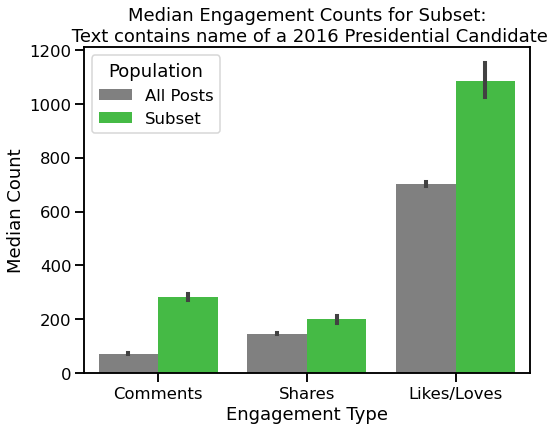

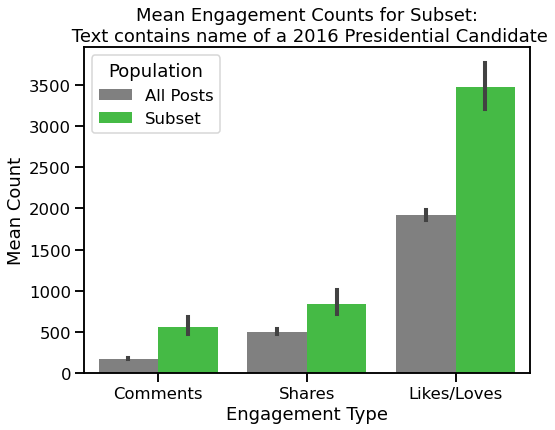

In [107]:
# posts containing 2016 presidential candidates names
terms = ['trump', 'donald', 'bernie', 'sanders', 'clinton', 'hillary']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Text contains name of a 2016 Presidential Candidate'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

More likes/loves and comments than shares. People may not have been as eager to share these types of posts widely, given the polarity of that race and likelihood that they have friends in the opposite political party.

### Obama

Number of hits: 2094


Top engagement:



Least engagement:


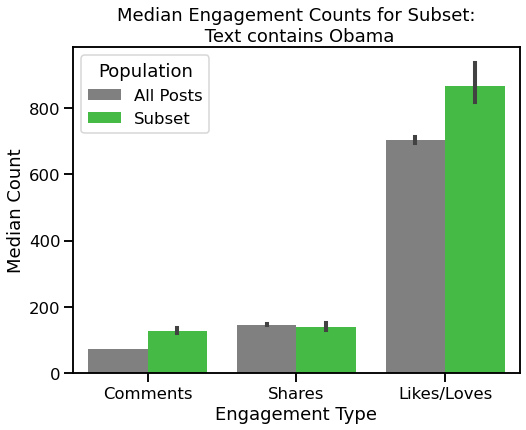

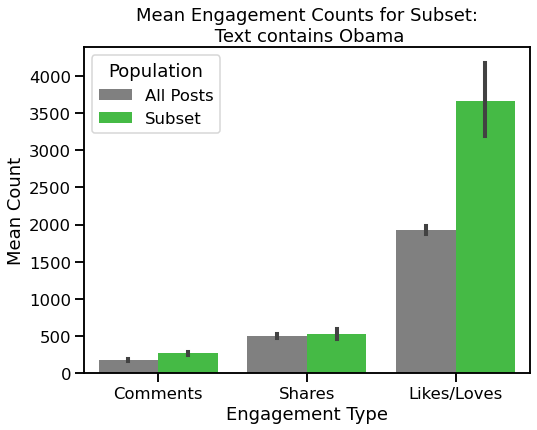

In [108]:
terms = ['obama', 'barack']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Text contains Obama'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### Women

Number of hits: 1677


Top engagement:



Least engagement:


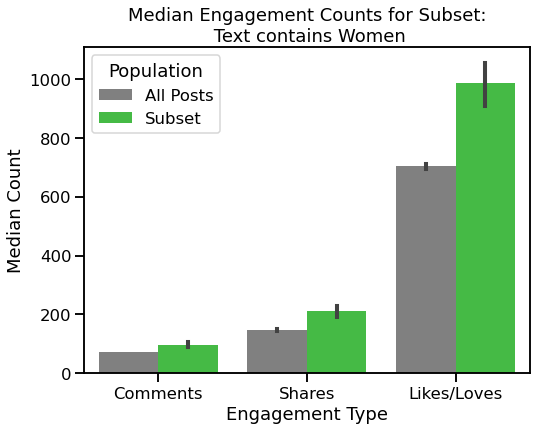

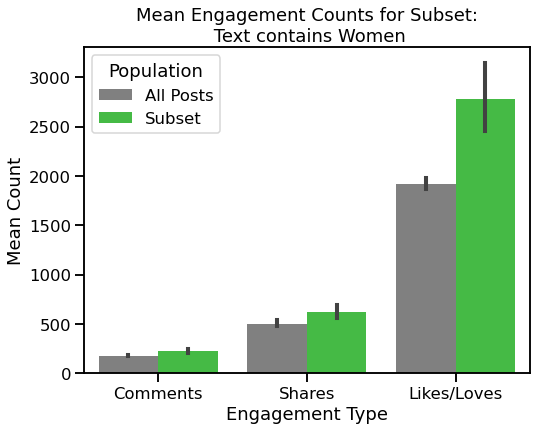

In [109]:
# posts containing women
terms = ['women']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Text contains Women'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

Many of the posts with the word 'women' are actually related to Donald Trump's words and actions regarding women, so I think the strength of this word is definitely partially due to its relation to the presidential race.

### Breaking News

Number of hits: 1074


Top engagement:



Least engagement:


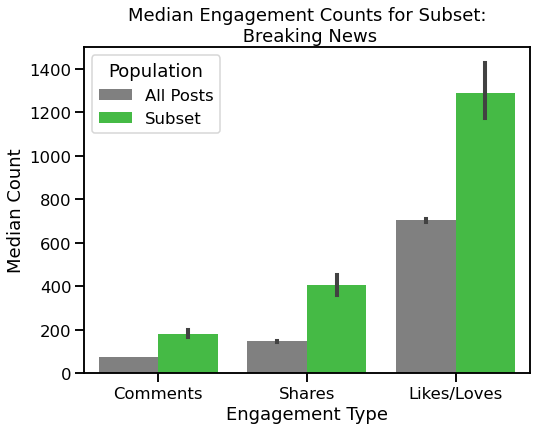

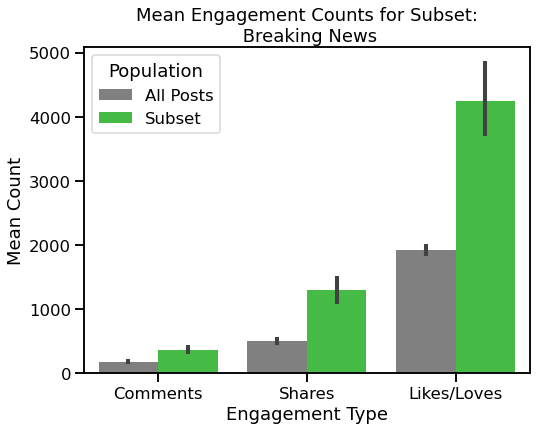

In [442]:
# posts containing breaking or breaking news
terms = ['breaking news', 'breaking']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Breaking News'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)


A pretty broad set of topics here, and significantly higher engagement across all categories.

### Opinion

Number of hits: 4342


Top engagement:



Least engagement:


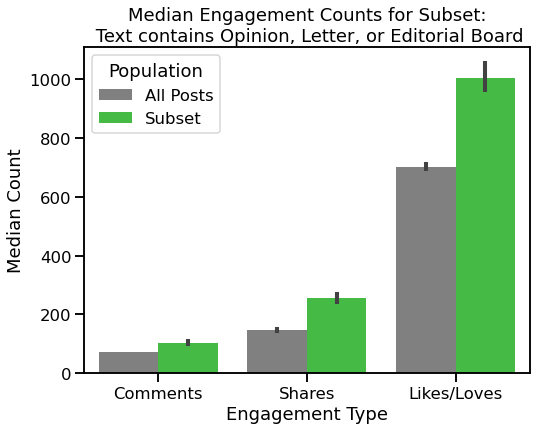

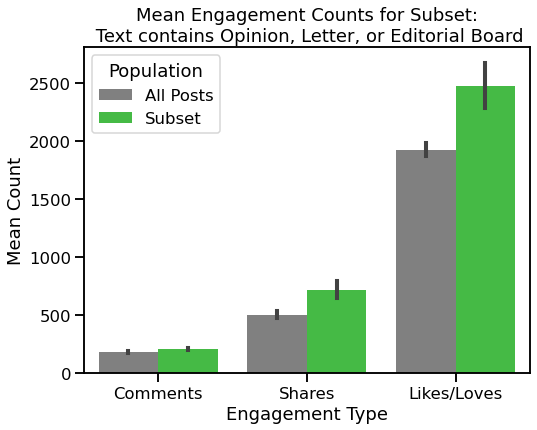

In [445]:
# posts containing opinion
terms = ['writes opinion', 'read opinion', 'opinion', 'editorial board',
        'letter', 'board writes', 'board', 'editorial']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Text contains Opinion, Letter, or Editorial Board'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

The top opinion-related posts are also related to the presidential candidates, Trump's views on women, and gun violence.

### Recipe

Number of hits: 935


Top engagement:



Least engagement:


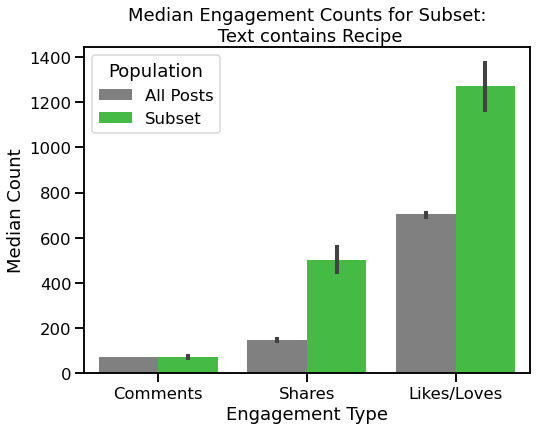

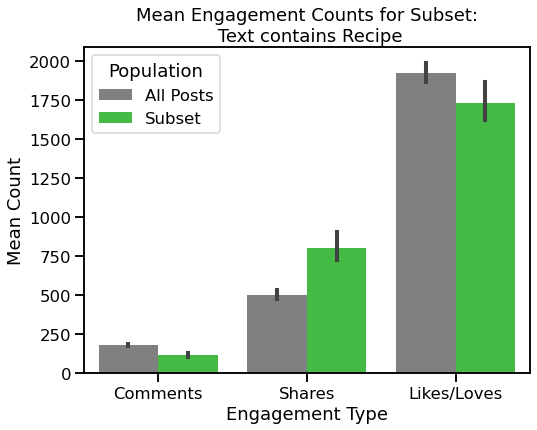

In [112]:
# posts containing recipe
terms = ['recipe']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Text contains Recipe'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

Recipes get a lot more likes/loves and shares than comments. Shares in particular make sense, since people like sharing recipes with each other offline too.

5 out of the top 10 recipes are for dessrts.

### Gun

Number of hits: 447


Top engagement:



Least engagement:


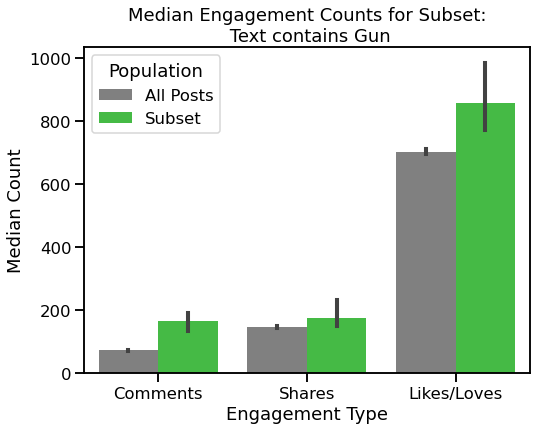

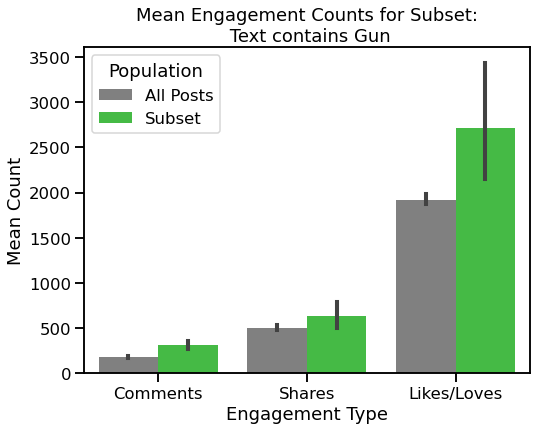

In [113]:
# posts containing gun
terms = ['gun']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Text contains Gun'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

Comments have the most significant increase over the general population; shares and likes/loves aren't significantly higher.

The topics are mostly on mass shootings and the gun control debate.

### White

Number of hits: 1140


Top engagement:



Least engagement:


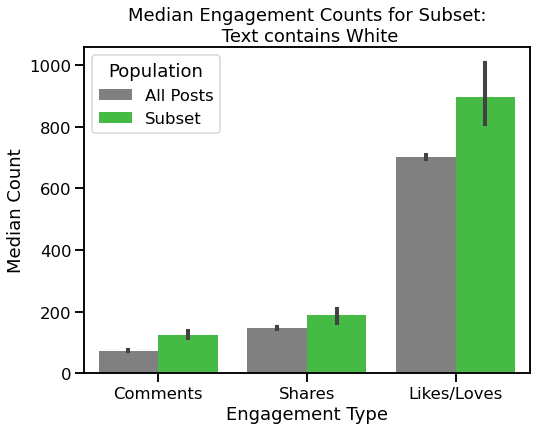

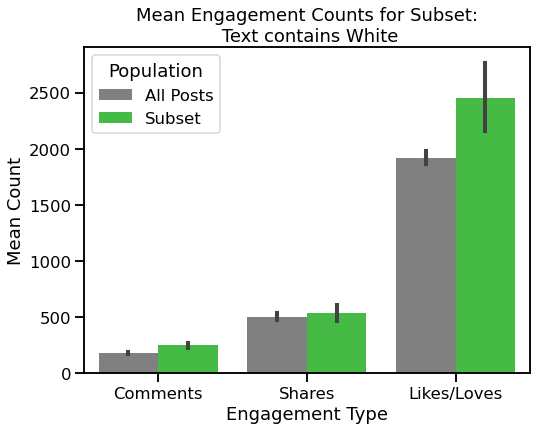

In [114]:
# posts containing recipe
terms = ['white']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Text contains White'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

Some of these are about racial equity, but others are about the White House.

The engagement increase is most significant in likes/loves.

### Kids

Number of hits: 331


Top engagement:



Least engagement:


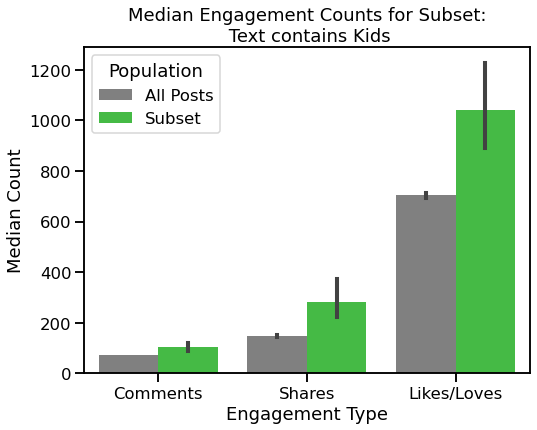

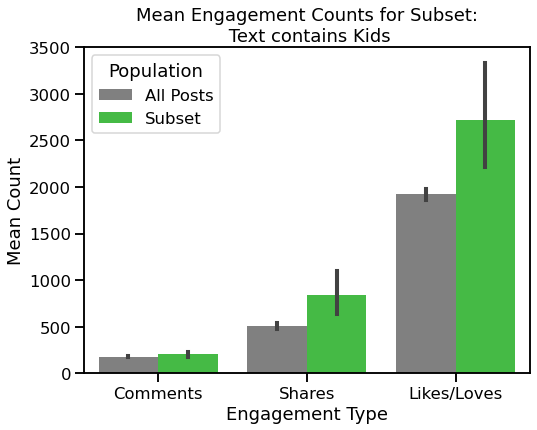

In [115]:
# posts containing kids
terms = ['kids']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Text contains Kids'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

- Video posts get significantly more comments, shares, and likes/loves.
- Photo posts get slightly more shares, and significantly more likes/loves.

### Obituaries


Top engagement:



Least engagement:


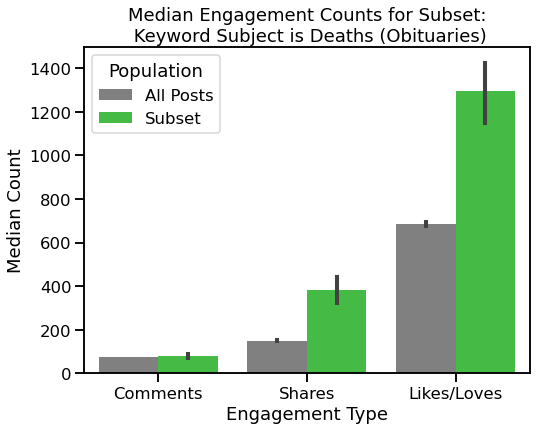

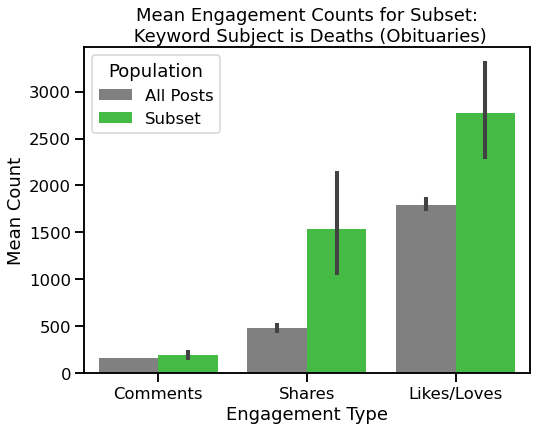

In [116]:
terms = ['deaths (obituaries)']

subset_title = 'Keyword Subject is Deaths (Obituaries)'

df_hits = plot_listmatches_vs_pop(df_articles, terms, subset_title, 
                           search_text_col='subject', 
                           full_text_col='article_text')

### Beauty


Top engagement:



Least engagement:


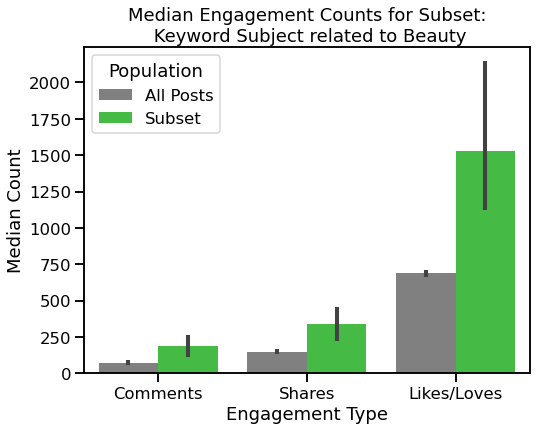

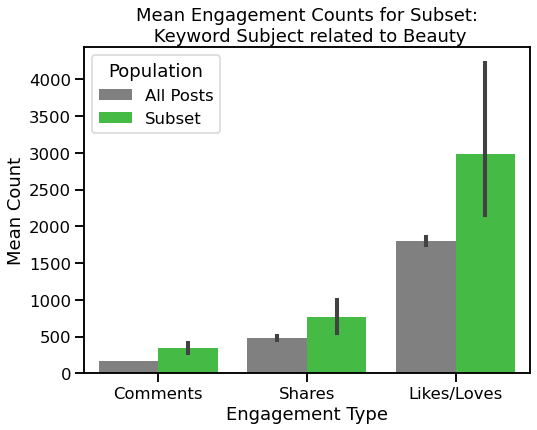

In [120]:
terms = ['beauty contests', 'hair', 'cosmetics and toiletries']

subset_title = 'Keyword Subject related to Beauty'

df_hits = plot_listmatches_vs_pop(df_articles, terms, subset_title, 
                           search_text_col='subject', 
                           full_text_col='article_text')

### Post Type

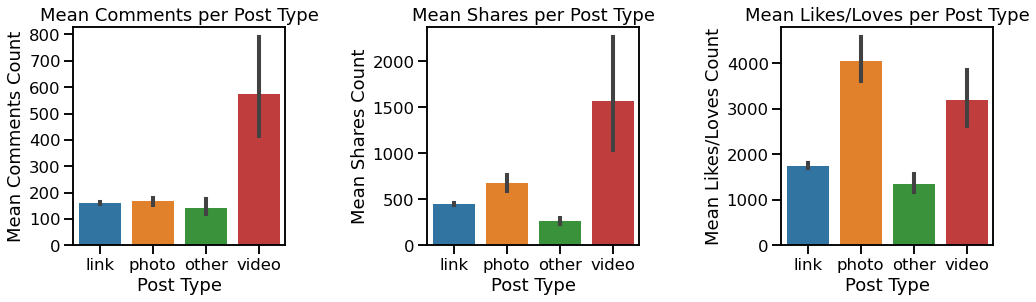

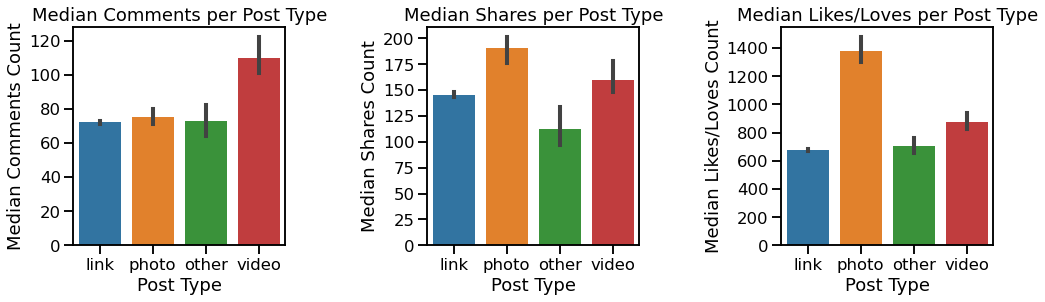

In [121]:
engage_dict = {'comments_count': "Comments", 'shares_count': 'Shares', 
                   'likes_loves': 'Likes/Loves'}
pred_col = 'post_type'
pred_label = 'Post Type'

with sns.plotting_context('talk'):

    fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=3)
    plt.tight_layout(pad=5)

    for i, target in enumerate(engage_dict.keys()):
        sns.barplot(data=df, y=target, x=pred_col, ax=axes[i], 
                    estimator=np.mean)
        axes[i].set_title(f"Mean {engage_dict[target]} per {pred_label}")
        axes[i].set_xlabel(pred_label)
        axes[i].set_ylabel(f"Mean {engage_dict[target]} Count");
        
    fig2, axes2 = plt.subplots(figsize=(16, 6), nrows=1, ncols=3)
    plt.tight_layout(pad=5)

    for i, target in enumerate(engage_dict.keys()):
        sns.barplot(data=df, y=target, x=pred_col, ax=axes2[i], 
                    estimator=np.median)
        axes2[i].set_title(f"Median {engage_dict[target]} per {pred_label}")
        axes2[i].set_xlabel(pred_label)
        axes2[i].set_ylabel(f"Median {engage_dict[target]} Count");

### Time of Day

In [122]:
# make categorical column
sorted_hours = list(df['hour_cat'].unique())
sorted_hours.sort()

cat_type = pd.api.types.CategoricalDtype(categories=sorted_hours, ordered=True)

df["hour_cat"] = df["hour_cat"].astype(cat_type)

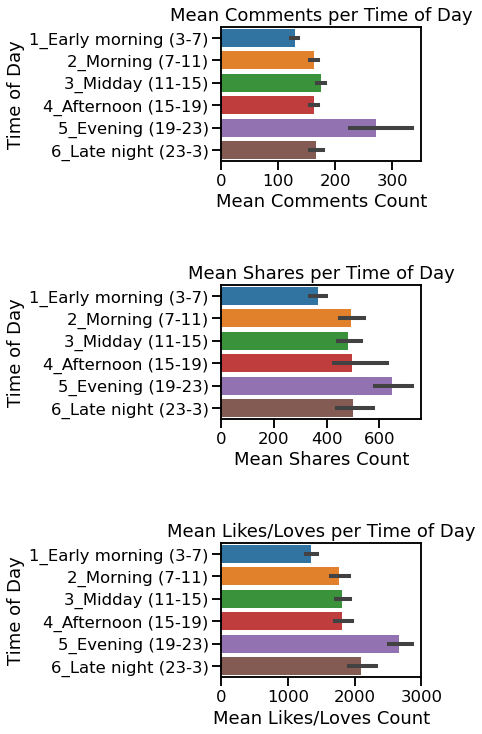

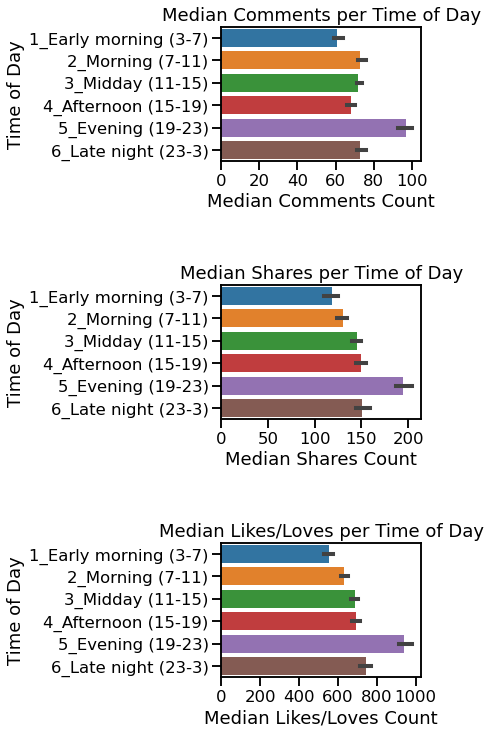

In [123]:
pred_col = 'hour_cat'
pred_label = 'Time of Day'

with sns.plotting_context('talk'):

    fig, axes = plt.subplots(figsize=(6, 12), nrows=3, ncols=1)
    plt.tight_layout(pad=5)

    for i, target in enumerate(engage_dict.keys()):
        sns.barplot(data=df, x=target, y=pred_col, ax=axes[i], 
                    estimator=np.mean)
        axes[i].set_title(f"Mean {engage_dict[target]} per {pred_label}")
        axes[i].set_ylabel(pred_label)
        axes[i].set_xlabel(f"Mean {engage_dict[target]} Count");
        #for tick in axes[i].get_ticklabels():
        #   tick.set_rotation(90);
        
    fig2, axes2 = plt.subplots(figsize=(6, 12), nrows=3, ncols=1)
    plt.tight_layout(pad=5)

    for i, target in enumerate(engage_dict.keys()):
        sns.barplot(data=df, x=target, y=pred_col, ax=axes2[i], 
                    estimator=np.median)
        axes2[i].set_title(f"Median {engage_dict[target]} per {pred_label}")
        axes2[i].set_ylabel(pred_label)
        axes2[i].set_xlabel(f"Median {engage_dict[target]} Count");
        #for tick in axes2[i].get_xticklabels():
        #    tick.set_rotation(90);

### Weekend

In [124]:
weekend_dict = {0:'Weekday', 1:'Weekend'}
df['on_weekend_plot'] = df['on_weekend'].map(lambda x: weekend_dict[x])

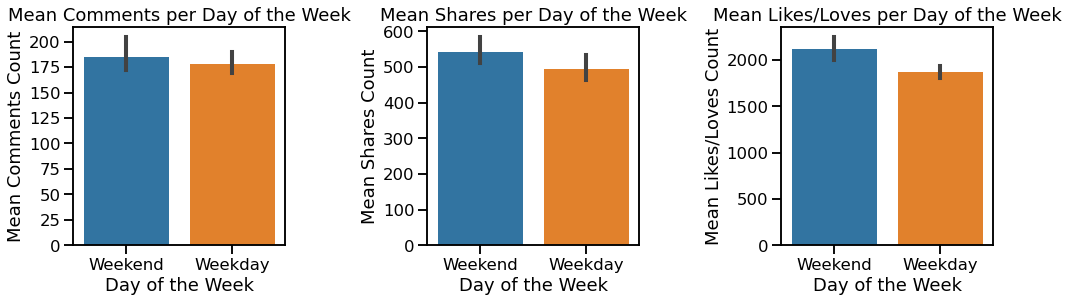

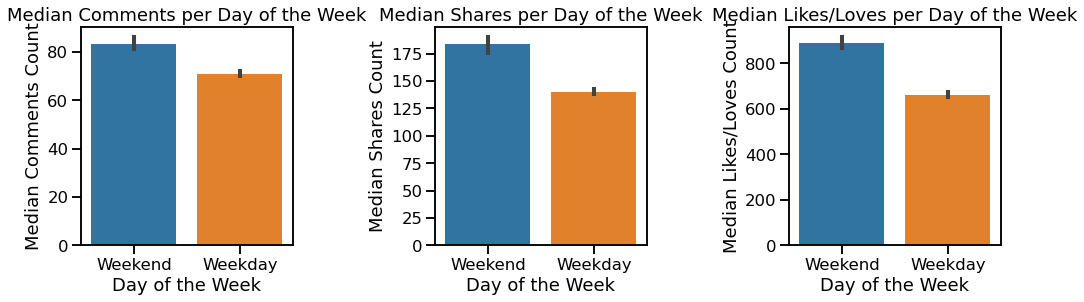

In [125]:
pred_col = 'on_weekend_plot'
pred_label = 'Day of the Week'

with sns.plotting_context('talk'):

    fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=3)
    plt.tight_layout(pad=5)

    for i, target in enumerate(engage_dict.keys()):
        sns.barplot(data=df, y=target, x=pred_col, ax=axes[i], 
                    estimator=np.mean)
        axes[i].set_title(f"Mean {engage_dict[target]} per {pred_label}")
        axes[i].set_xlabel(pred_label)
        axes[i].set_ylabel(f"Mean {engage_dict[target]} Count");
        
    fig2, axes2 = plt.subplots(figsize=(16, 6), nrows=1, ncols=3)
    plt.tight_layout(pad=5)

    for i, target in enumerate(engage_dict.keys()):
        sns.barplot(data=df, y=target, x=pred_col, ax=axes2[i], 
                    estimator=np.median)
        axes2[i].set_title(f"Median {engage_dict[target]} per {pred_label}")
        axes2[i].set_xlabel(pred_label)
        axes2[i].set_ylabel(f"Median {engage_dict[target]} Count");

## Explore Top Predictors of Low Engagement

### Ethics and Op-Ed

Number of hits: 752


Top engagement:



Least engagement:


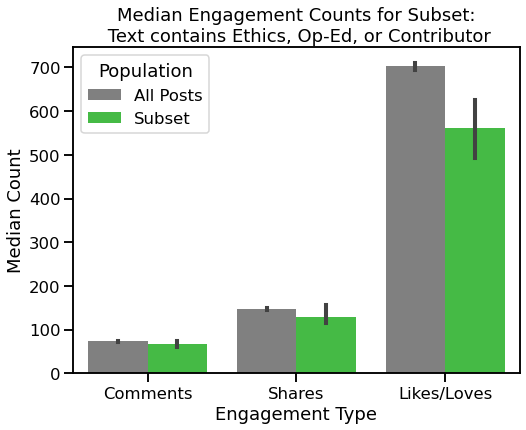

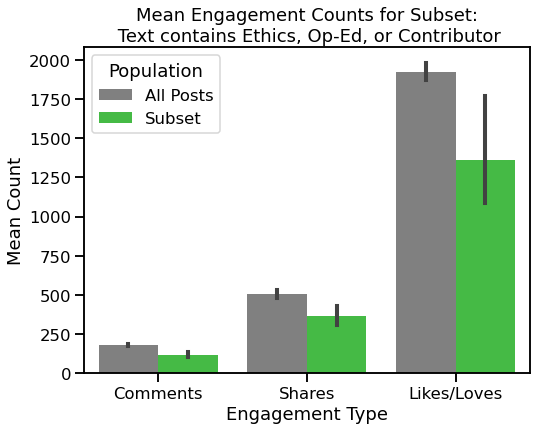

In [446]:
# posts containing Ethics and Op-Ed
terms = ['ethics', 'ethicist', 'op-ed', 'contributor']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Text contains Ethics, Op-Ed, or Contributor'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### Quotation of the Day

Number of hits: 1085


Top engagement:



Least engagement:


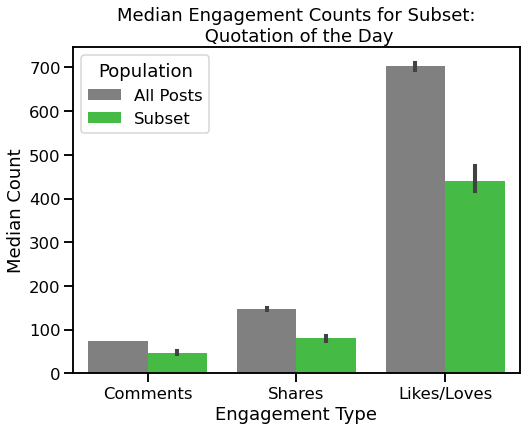

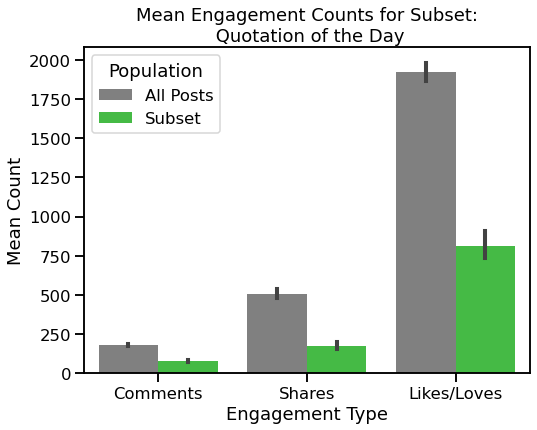

In [453]:
terms = ['quotation of the day', 'quote of the day', 'quote']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = 'Quotation of the Day'

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### Daily Briefing

Number of hits: 188


Top engagement:



Least engagement:


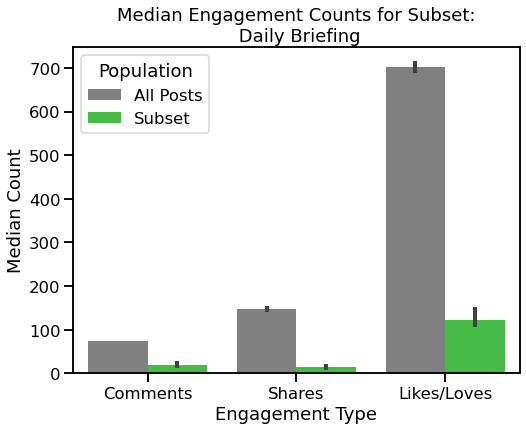

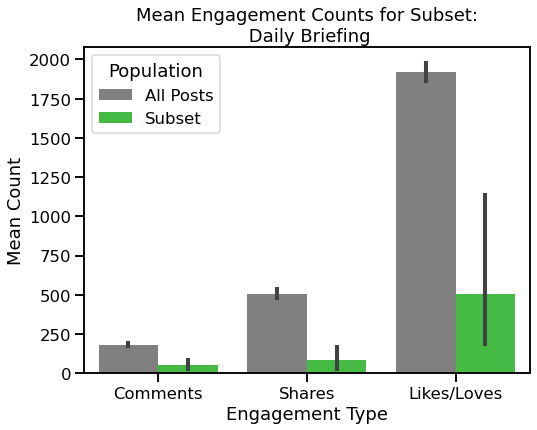

In [460]:
terms = ["daily briefing", "here's what you need to know to start your day",
        'briefing']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Daily Briefing"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### Week

Number of hits: 1712


Top engagement:



Least engagement:


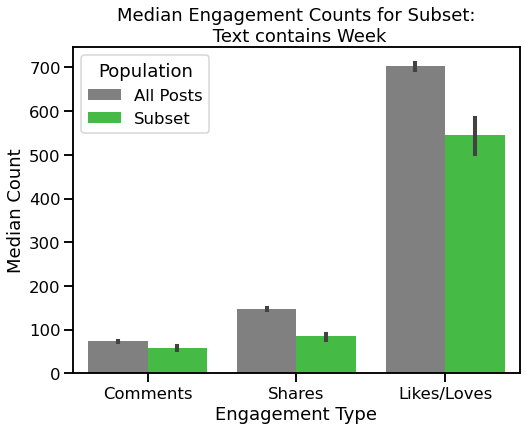

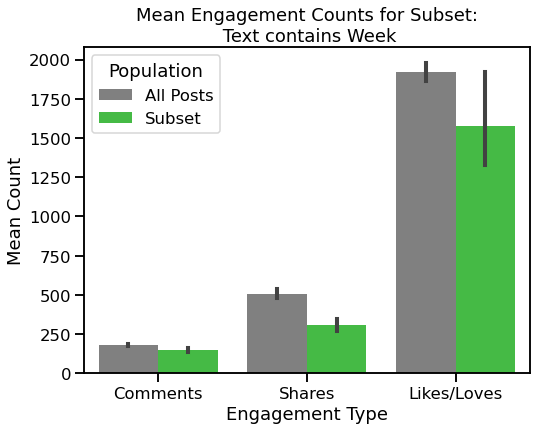

In [462]:
terms = ["week"]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Text contains Week"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

Number of hits: 71


Top engagement:



Least engagement:


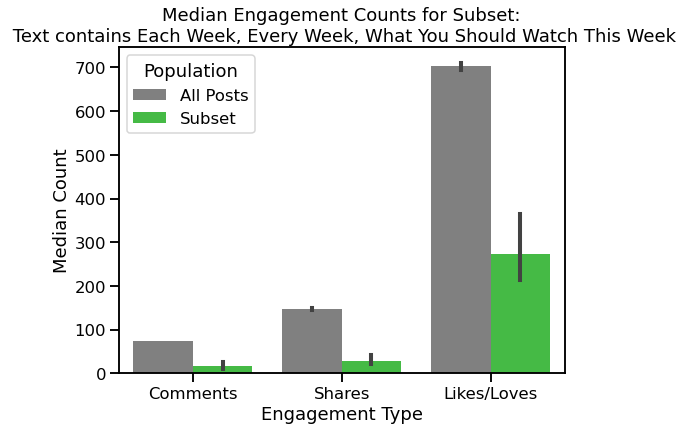

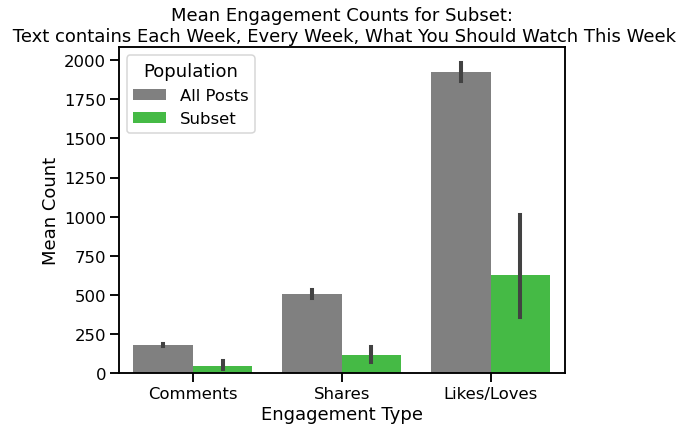

In [463]:
terms = ["each week", "every week", "what you should watch this week"]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Text contains Each Week, Every Week, What You Should Watch This Week"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

In [129]:
df.loc[(df['cleaned'].str.contains('week', regex=False, case=False)),
      'name'].value_counts()[:30]

Timeline Photos                                            131
The New York Times Styles                                   30
Video From The New York Times                               25
Press Play                                                  15
What You Should Watch This Weekend                          12
What We're Reading                                          11
What You Should Watch This Week                              9
Do You Live Near I-35? Contribute to Our Reporting           8
Photos from The New York Times's post                        7
The New York Times Food                                      7
What to Cook This Week                                       7
The New York Times - Well - Health                           6
36 Hours in Madrid                                           4
The New York Times - Science                                 4
Fashion Week Now Spring 2015                                 4
The New York Times - Lens - Photography                

Number of hits: 49


Top engagement:



Least engagement:


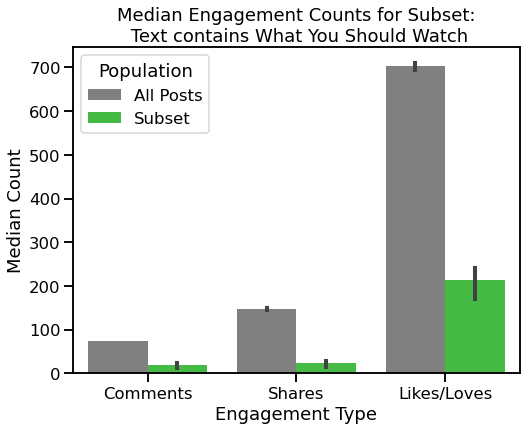

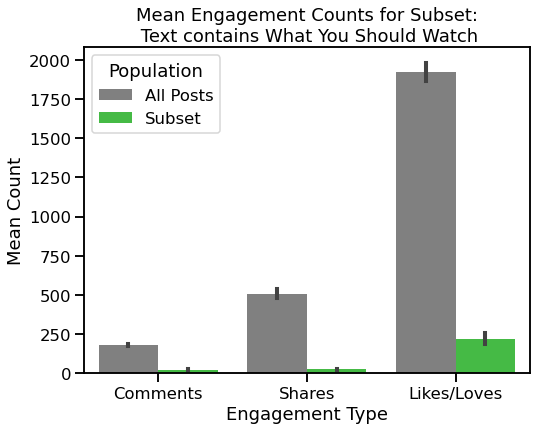

In [130]:
terms = ["what you should watch"]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Text contains What You Should Watch"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### New York Today

Number of hits: 8111


Top engagement:



Least engagement:


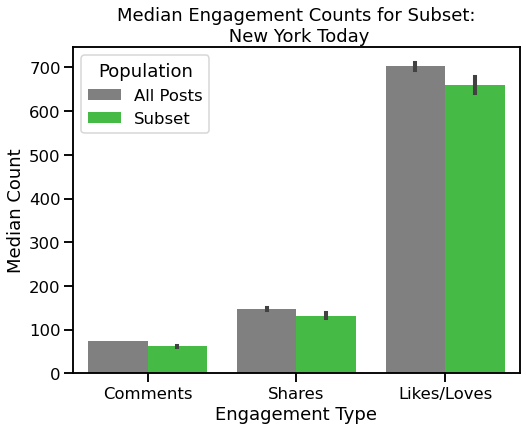

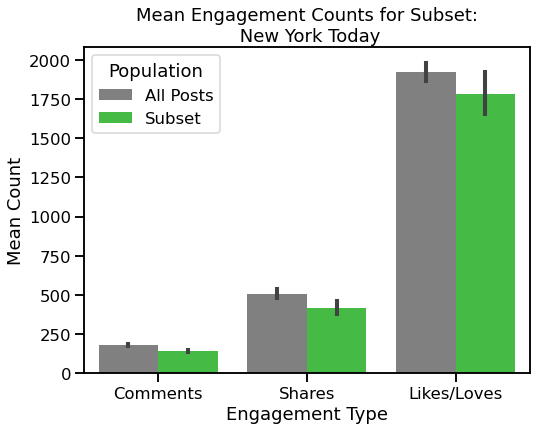

In [471]:
terms = ["new york today", 'new']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "New York Today"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### Moments

Number of hits: 279


Top engagement:



Least engagement:


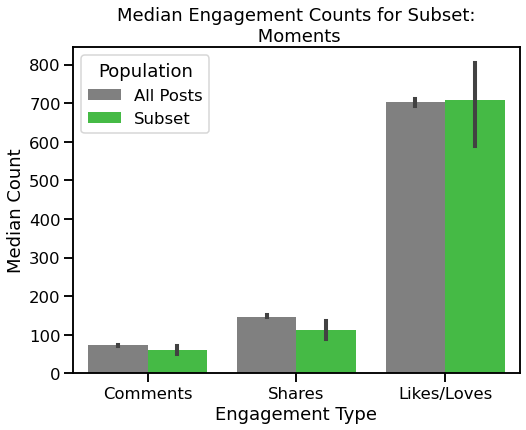

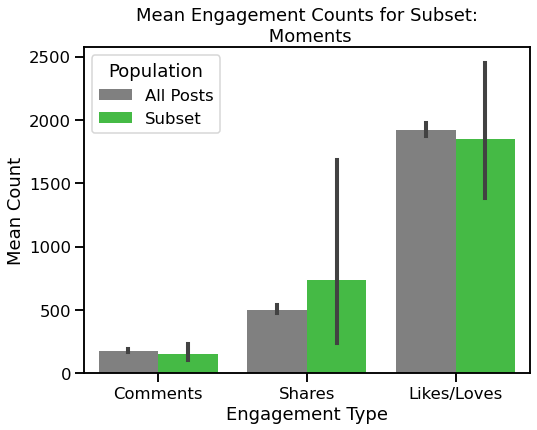

In [469]:
terms = ["moments"]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Moments"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### Collection

Number of hits: 227


Top engagement:



Least engagement:


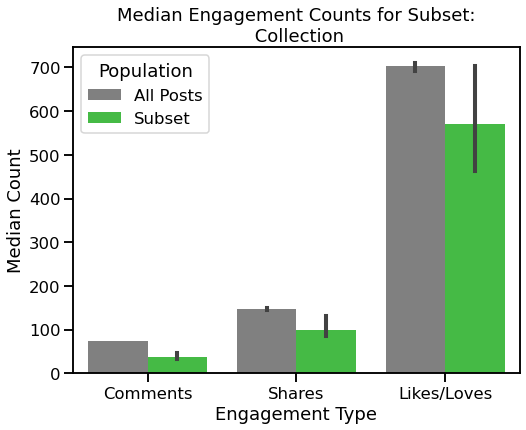

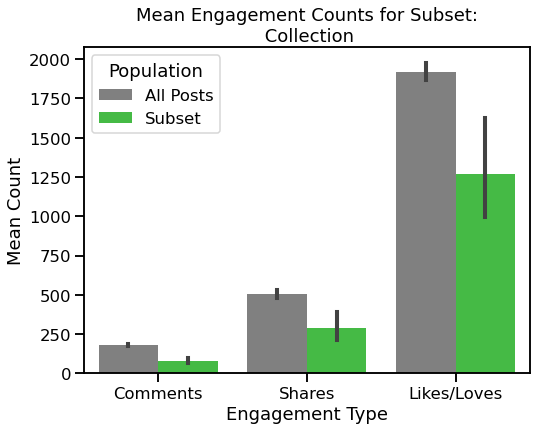

In [470]:
terms = ["collection"]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Collection"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### Question mark

Number of hits: 8245


Top engagement:



Least engagement:


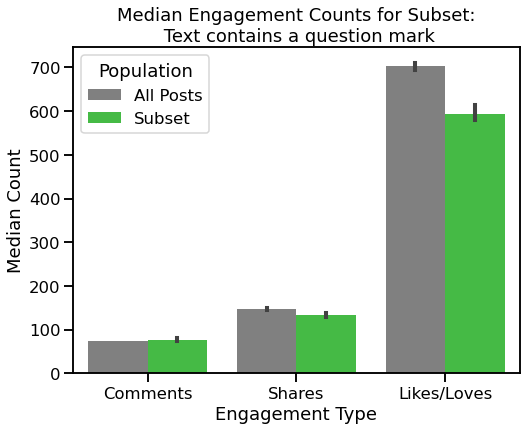

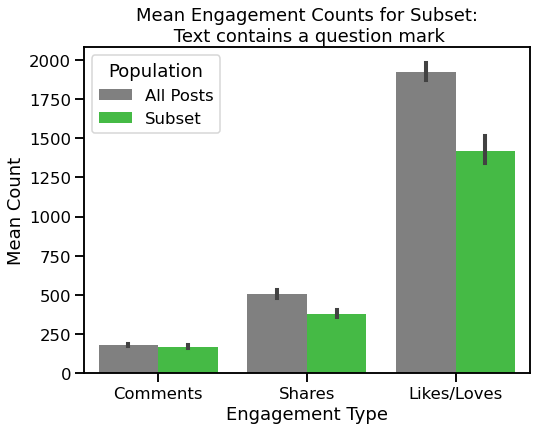

In [131]:
re_string = "[?]"

subset_title = "Text contains a question mark"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### Here's what you need to know

Number of hits: 471


Top engagement:



Least engagement:


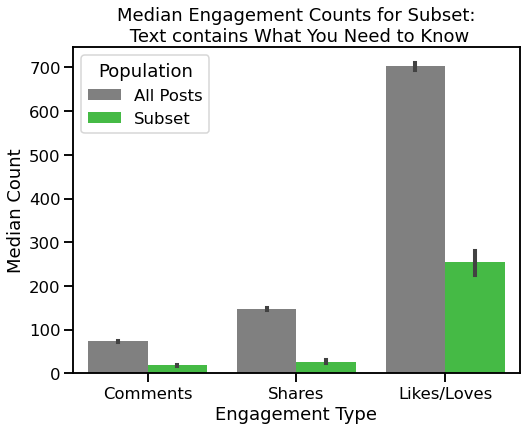

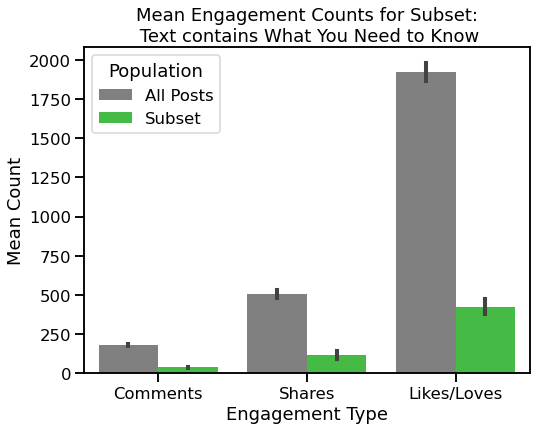

In [464]:
terms = ["what you need to know"]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Text contains What You Need to Know"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### Ebola

Number of hits: 436


Top engagement:



Least engagement:


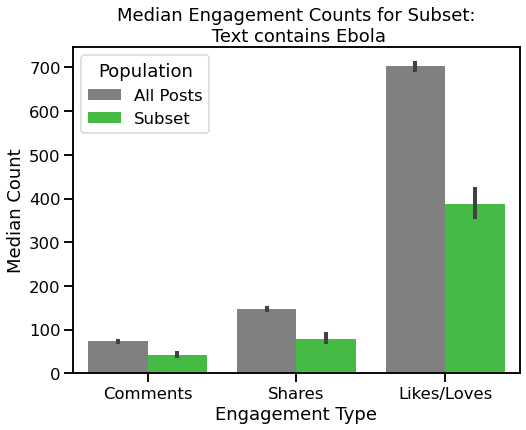

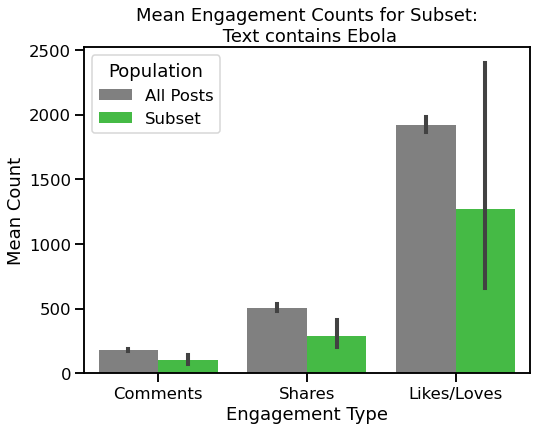

In [135]:
terms = ["ebola"]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Text contains Ebola"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### General Government and Politics

Number of hits: 5428


Top engagement:



Least engagement:


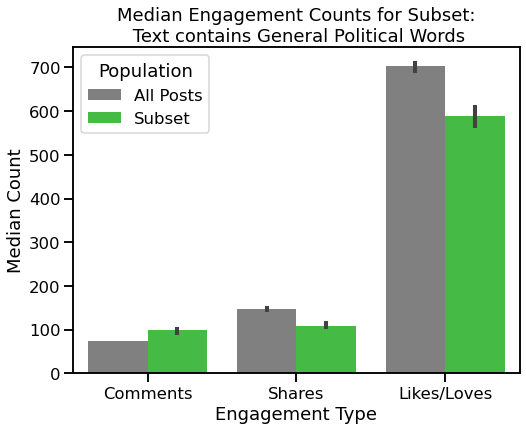

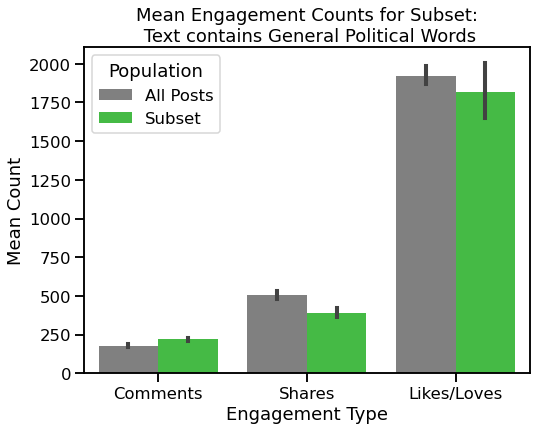

In [447]:
terms = ["government", 'political', 'politics', 'voters', 'polls', 
         'washington', 'bush', 'senate', 'campaign', 'elections']

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Text contains General Political Words"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)


Top engagement:



Least engagement:


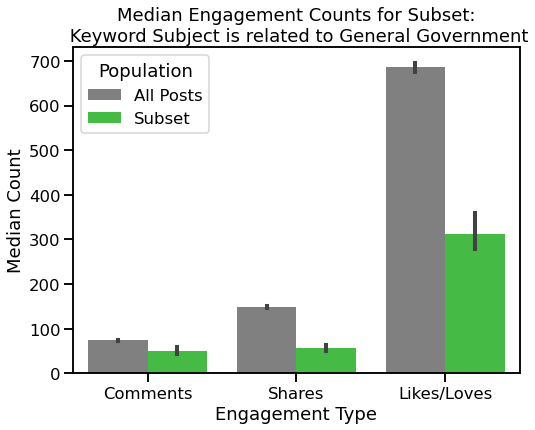

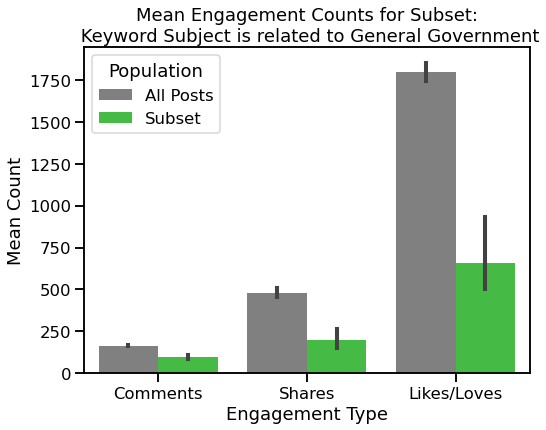

In [137]:
terms = ['midterm elections (2014)', 'politics and government', 'jury system',
        'political action commitees', 'third-party politics (us)']

subset_title = 'Keyword Subject is related to General Government'

df_hits = plot_listmatches_vs_pop(df_articles, terms, subset_title, 
                           search_text_col='subject', 
                           full_text_col='article_text')

### Fashion

Number of hits: 568


Top engagement:



Least engagement:


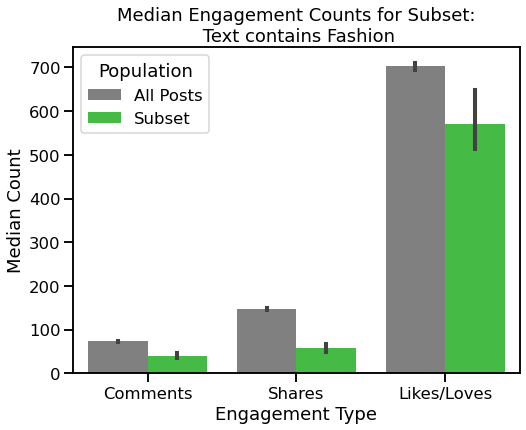

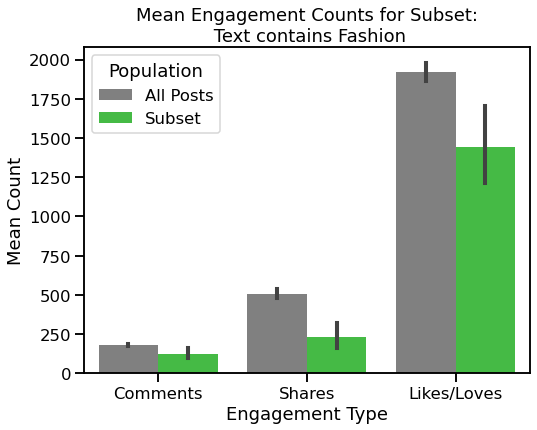

In [138]:
terms = ['fashion' ]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Text contains Fashion"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

### Sports

Number of hits: 718


Top engagement:



Least engagement:


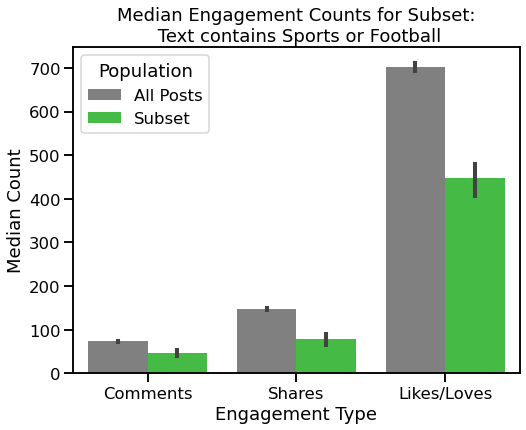

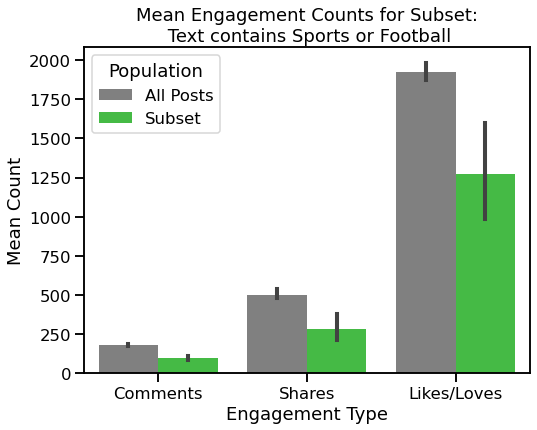

In [139]:
terms = ['sports', 'football' ]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Text contains Sports or Football"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)


Top engagement:



Least engagement:


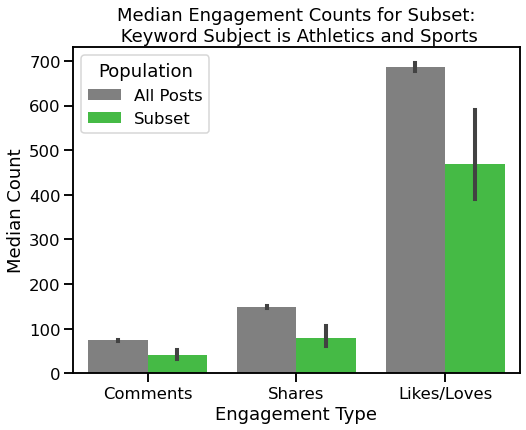

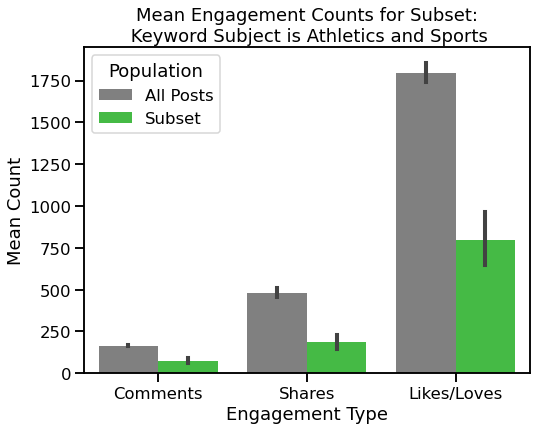

In [140]:
terms = ['athletics and sports']

subset_title = 'Keyword Subject is Athletics and Sports'

df_hits = plot_listmatches_vs_pop(df_articles, terms, subset_title, 
                           search_text_col='subject', 
                           full_text_col='article_text')

Some of these are about protecting kids (from gun violence, from Trump as president), but most are actually on the topic of raising kids.

Likes/loves and shares have the most significant elevation in engagement.

In [141]:
high_eng.head(25)

Formatted Feature          Feature  Odds of High Engagement       std  \
0      breaking news    breaking news                   8.2860  0.869068   
1           breaking         breaking                   6.3360  0.528517   
2     writes opinion   writes opinion                   3.4620  0.573995   
3             recipe           recipe                   3.3880  0.957351   
4              trump            trump                   3.1420  0.147547   
5       read opinion     read opinion                   3.1120  1.086586   
6             donald           donald                   2.8880  0.346222   
7               news             news                   2.7760  0.440545   
8              white            white                   2.7000  0.366811   
9              women            women                   2.6880  0.226097   
10            bernie           bernie                   2.5780  0.405179   
11             obama            obama                   2.4820  0.393599   
12           sanders          sanders                   2.3700  0.268235   
13               gun              gun                   2.3440  0.556219   
14              kids             kids                   2.2060  0.386368   
15            muslim           muslim                   2.2020  0.116060   
16             happy            happy                   2.1640  0.105024   
17    bernie sanders   bernie sanders                   2.1280  0.221968   
18           trump's          trump's                   2.1080  0.250140   
19             paris            paris                   2.1000  1.180593   
20             hours            hours                   2.0920  0.145327   
21              dies             dies                   2.0680  0.185796   
22               boy              boy                   2.0640  0.110815   
23           section          section                   2.0200  0.987320   
24   opinion section  opinion section                   2.0175  1.132825   

     min   max  count      conf  conf_min  
0   6.84  9.14    5.0  1.852721  6.433279  
1   5.43  6.76    5.0  1.126717  5.209283  
2   2.53  4.10    5.0  1.223669  2.238331  
3   2.11  4.76    5.0  2.040925  1.347075  
4   2.89  3.28    5.0  0.314547  2.827453  
5   1.61  4.25    5.0  2.316436  0.795564  
6   2.50  3.34    5.0  0.738093  2.149907  
7   2.35  3.35    5.0  0.939175  1.836825  
8   2.22  3.18    5.0  0.781984  1.918016  
9   2.46  3.01    5.0  0.482005  2.205995  
10  2.05  3.14    5.0  0.863779  1.714221  
11  1.91  2.93    5.0  0.839092  1.642908  
12  2.13  2.81    5.0  0.571836  1.798164  
13  1.67  3.17    5.0  1.185774  1.158226  
14  1.59  2.61    5.0  0.823677  1.382323  
15  2.03  2.34    5.0  0.247423  1.954577  
16  2.08  2.34    5.0  0.223895  1.940105  
17  1.91  2.44    5.0  0.473203  1.654797  
18  1.69  2.36    5.0  0.533260  1.574740  
19  1.35  3.86    4.0  2.778365 -0.678365  
20  1.87  2.27    5.0  0.309815  1.782185  
21  1.77  2.25    5.0  0.396088  1.671912  
22  1.93  2.21    5.0  0.236241  1.827759  
23  1.44  3.16    3.0  2.882959 -0.862959  
24  1.10  3.67    4.0  2.665948 -0.648448

### Video or Watch

Number of hits: 987


Top engagement:



Least engagement:


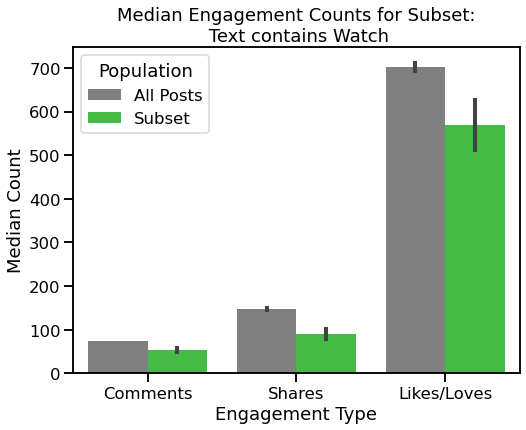

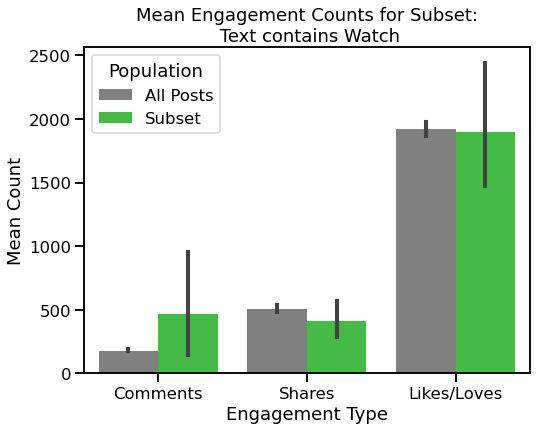

In [249]:
terms = ['watch' ]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Text contains Watch"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

Number of hits: 2253


Top engagement:



Least engagement:


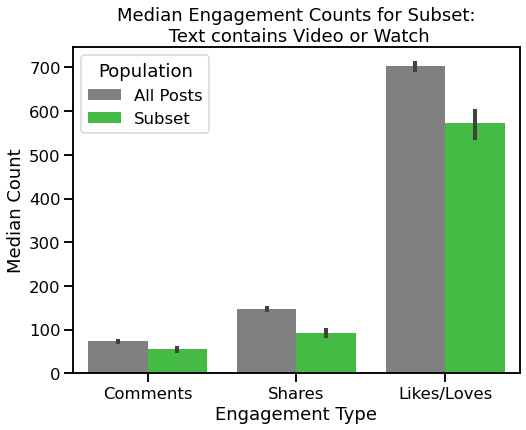

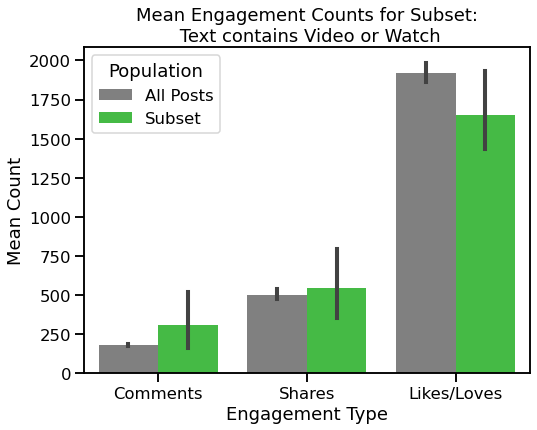

In [142]:
terms = ['video', 'watch' ]

re_string = '\\b' + '\\b|\\b'.join(terms) + '\\b'

subset_title = "Text contains Video or Watch"

df_hits = plot_hits_vs_pop(df, re_string, subset_title)

# CONCLUSIONS & RECOMMENDATIONS

To finalize my conclusions, I exported the top 300 high and low word features, top 300 high and low subject features, and all categorical features to Excel, and performed a manual categorization exercise. Not every word and subject was ultimately assigned a categories, but where they stood out clearly, I assigned them.

In [496]:
# import categorized features from Excel
df_results = pd.read_excel('data/Results.xlsx', sheet_name='Categories')

df_results['Category'].value_counts()

Food, Cooking, and Recipes             40
Minority Groups and Social Equality    37
Foreign Coverage                       32
Modern Tech                            32
General Politics and Government        31
                                       ..
Summary Coverage                        3
Farming and Agriculture                 3
Breaking News                           2
Aging                                   2
Media and Broadcasting                  1
Name: Category, Length: 64, dtype: int64

In [497]:
timing_dict = {'hour_cat_3_Midday (11-15)': 'Posted Midday (11 AM to 3 PM ET)', 
'hour_cat_4_Afternoon (15-19)': 'Posted Afternoon (3 PM  to 7 PM ET)', 
'hour_cat_2_Morning (7-11)': 'Posted Morning (7 AM to 11 AM ET)', 
'hour_cat_5_Evening (19-23)': 'Posted Evening (7 PM to 11 PM ET)', 
'hour_cat_6_Late night (23-3)': 'Posted Late Night (11 PM to 3 AM ET)', 
'hour_cat_1_Early morning (3-7)': 'Posted Early Morning (3 AM to 7 AM ET)'}

def format_featurenames(x):
    """Formats the feature names currently using OHE column prefixes,
    and makes them nicer looking for viz.
    """
    from textwrap import wrap
    
    if x.startswith("sub_"):
        x = '(Subject) ' + x.replace("sub_", "").title()
    elif x.startswith("section_name_"):
        x = '(Section Name) ' + x.replace("section_name_", "").title()
    elif x.startswith("post_type_"):
        x = '(Post Type) ' + x.replace("post_type_", "").title()
    elif x.startswith("hour_cat_"):
        x = timing_dict[x]
    elif x == 'on_weekend_1.0':
        x = 'Posted on Weekend Day'
        
    x = '\n'.join(wrap(x, 40))
    
    return x


# Format section feature names better
df_results['Formatted Feature'] = df_results['Feature']\
        .map(lambda x: format_featurenames(x))


In [498]:
# Add/Subtract 1 from  odds ratios
df_results[high_label] = df_results[high_label]\
        .map(lambda x: x - 1 if x > 1 else x + 1)


## Prioritize Presidential Topics over General Politics

- Content related to the 2016 presidential election and the current sitting president generally get high engagement.
- Content related to politics in general, however, tend to get lower engagement

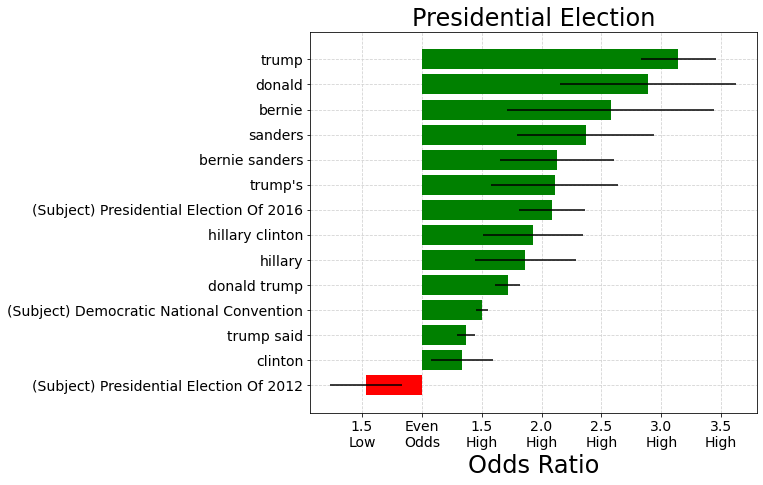

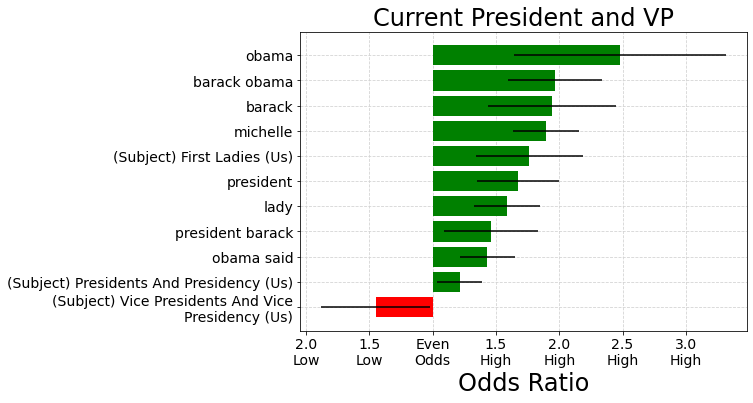

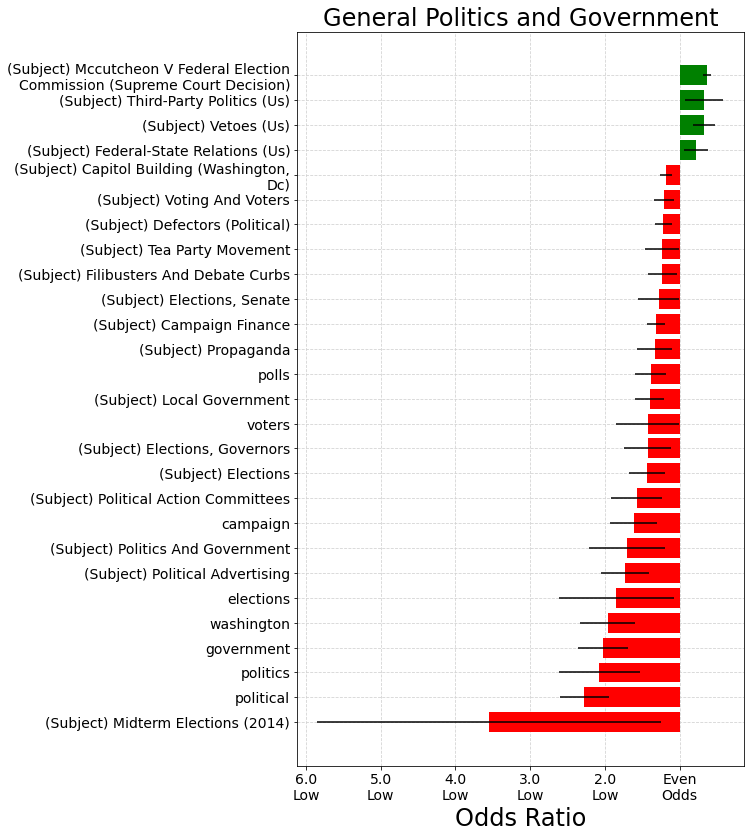

In [451]:
for cat in ['Presidential Election', 'Current President and VP',
            'General Politics and Government']:

    plot_topfeatures_w_conf(df_results.loc[(df_results['Category']==cat) & 
                (df_results['conf_min']>1) & (df_results['count']>1)], 
                            'Formatted Feature', high_label, 50, 
                   f"{cat}", 'conf', pos_neg=True)

## Prioritize Breaking News over Recurring Content

- Breaking news is one of the top predictors of high engagement
- Conversely, regular or recurring features typically get low engagement. Examples include "Quotation of the Day", "New York Today", "Daily Briefing".

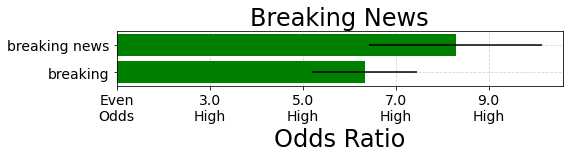

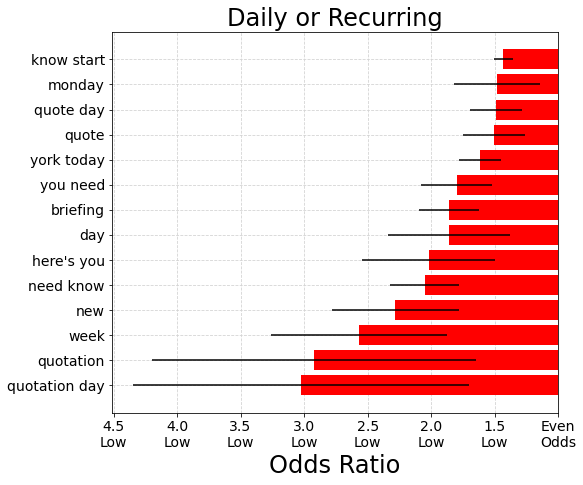

In [475]:
for cat in ['Breaking News', 'Daily or Recurring']:

    plot_topfeatures_w_conf(df_results.loc[(df_results['Category']==cat) & 
                (df_results['conf_min']>1) & (df_results['count']>1)], 
                            'Formatted Feature', high_label, 50, 
                   f"{cat}", 'conf', pos_neg=True)

## Prioritize U.S. National Content over Local or Foreign

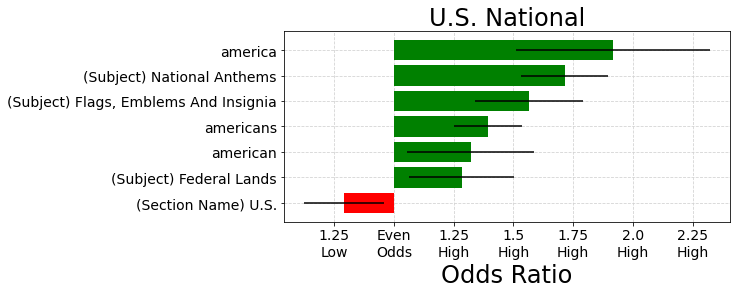

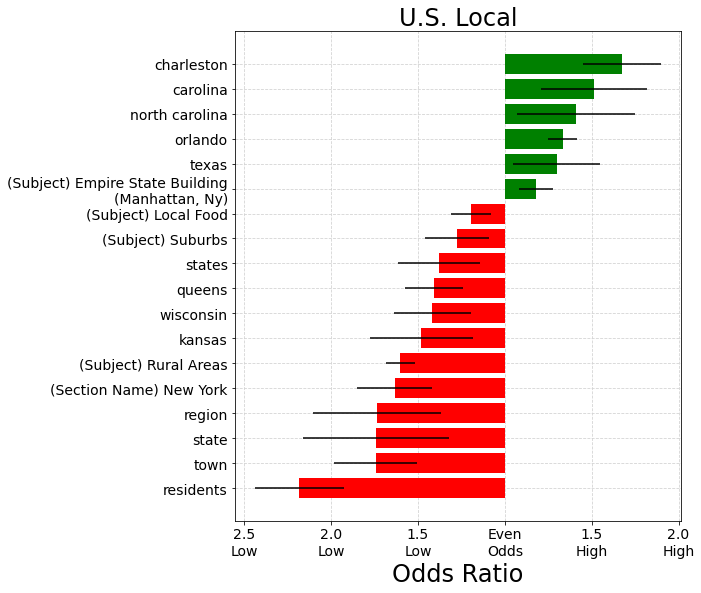

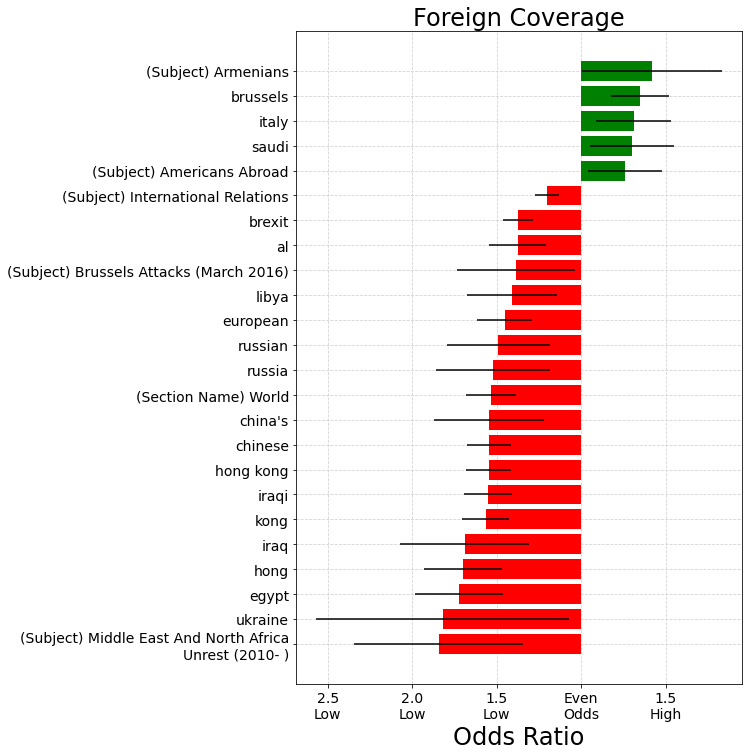

In [499]:
for cat in ['U.S. National', 'U.S. Local', 'Foreign Coverage']:

    plot_topfeatures_w_conf(df_results.loc[(df_results['Category']==cat) & 
                (df_results['conf_min']>1) & (df_results['count']>1)], 
                            'Formatted Feature', high_label, 50, 
                   f"{cat}", 'conf', pos_neg=True)

## Controversial Topics can be Highly Engaging (but it depends)

- Gender and religious topics seem to get more engagement than race and sexuality
- Gun topics are generally higher engagement, but vary widely.
- Immigration and refugee coverage tend to get less engagement.

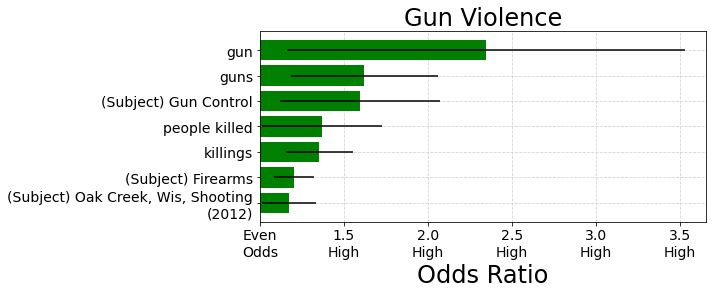

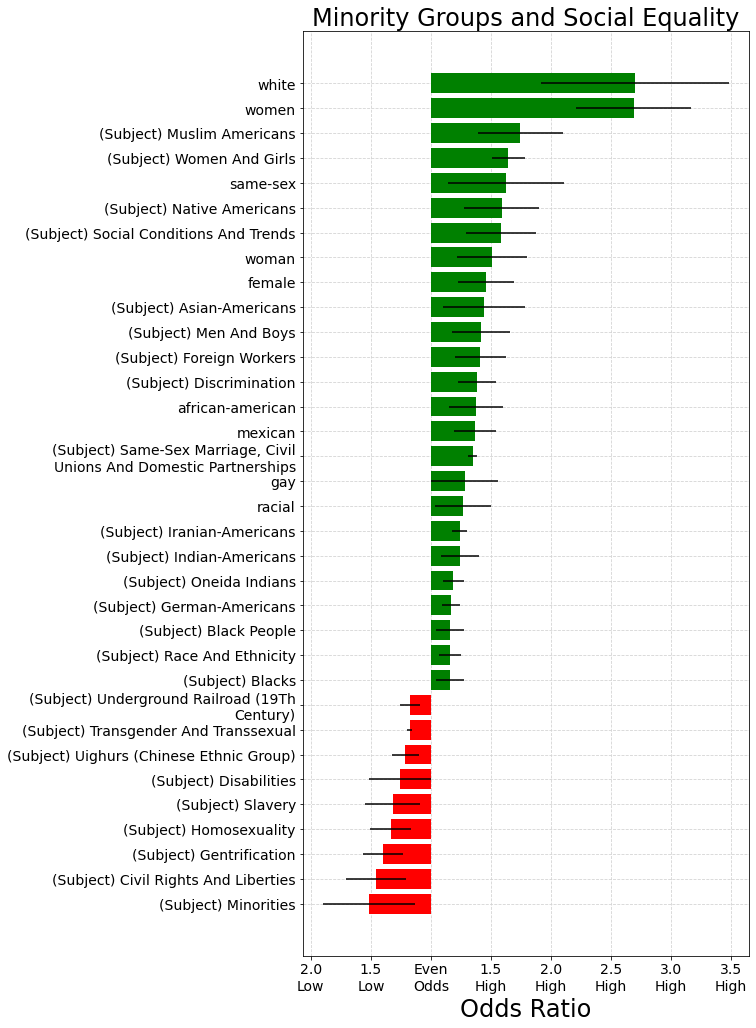

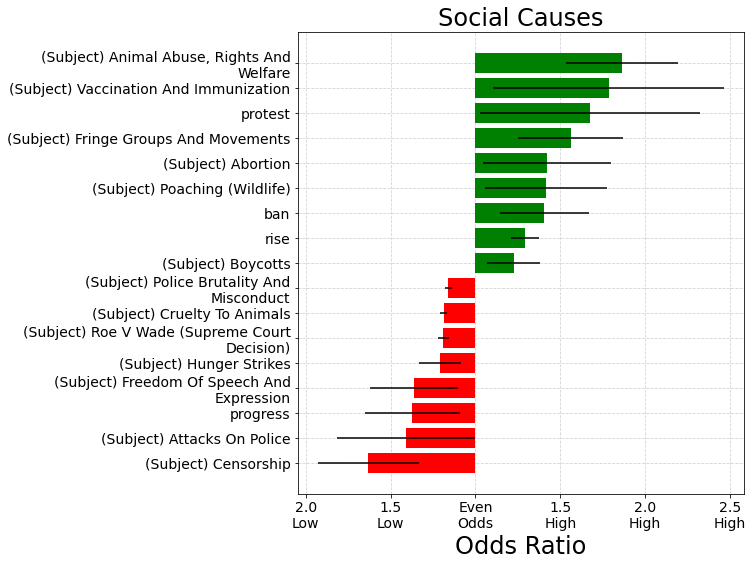

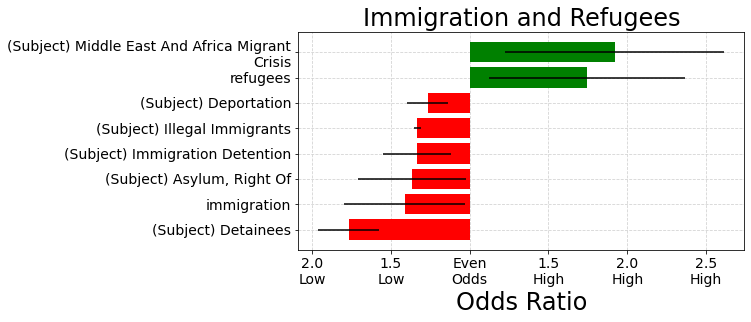

In [440]:
for cat in ['Gun Violence', 'Minority Groups and Social Equality',
           'Social Causes', 'Immigration and Refugees']:

    plot_topfeatures_w_conf(df_results.loc[(df_results['Category']==cat) & 
                (df_results['conf_min']>1) & (df_results['count']>1)], 
                            'Formatted Feature', high_label, 50, 
                   f"{cat}", 'conf', pos_neg=True)

## Post content outside the paywall

- Posts added as videos or photos uploaded to Facebook instead of links (or added to the Facebook Timeline) get more engagement than posts that have the words "watch" or "video" in them but are posted as links back to the Times' site. I think this is likely because links to the site will often be behind the paywall.

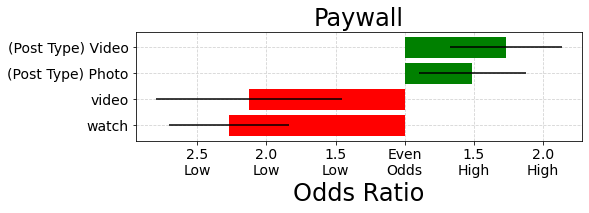

In [488]:
for cat in ['No Paywall']:

    plot_topfeatures_w_conf(df_results.loc[(df_results['Category']==cat) & 
                (df_results['conf_min']>1) & (df_results['count']>1)], 
                            'Formatted Feature', high_label, 50, 
                   "Paywall", 'conf', pos_neg=True)

### Video Posts

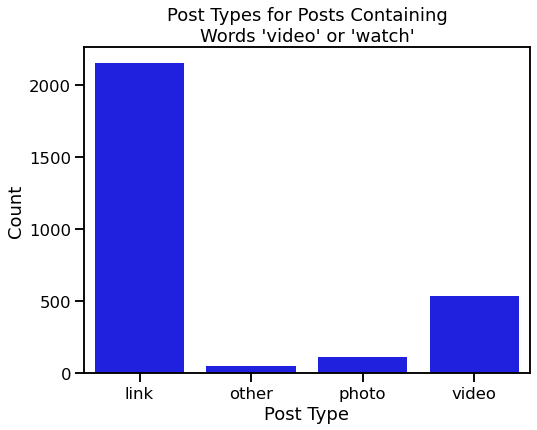

In [491]:
df_vid = df.loc[(df['cleaned'].str.contains('video', regex=False, case=False)) | 
      (df['cleaned'].str.contains('watch', regex=False, case=False))]

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(8, 6))

    sns.countplot(data=df_vid, x='post_type', ax=ax, color='blue')
    ax.set_title("Post Types for Posts Containing\nWords 'video' or 'watch'")
    ax.set_xlabel('Post Type')
    ax.set_ylabel('Count')

    ;

OK so only 18% of posts that contain the word "video" or "watch" were actually posted as videos; 75% were posted as links.

Video posts are more popular, but it makes sense why the top predictors of average included the words "watch" and "video".

## Tell More than you Ask

- When posts use words related to what people have said, these get high engagement. It seems like people like hearing others' words directly.
- However, posts that include words where the Times seems to be asking questions of readers seem to get less engagement.

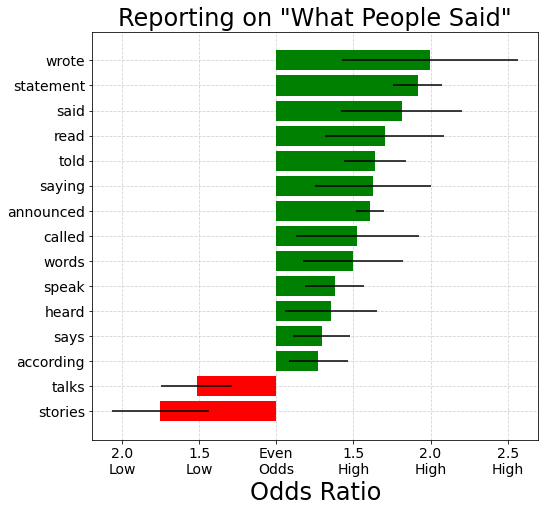

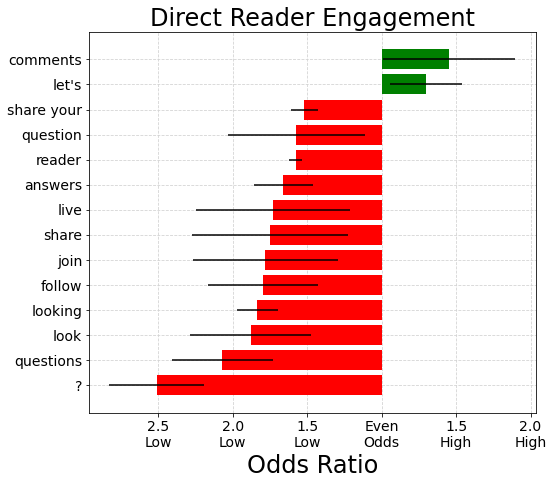

In [428]:
for cat in ['Reporting on "What People Said"', 'Direct Reader Engagement']:

    plot_topfeatures_w_conf(df_results.loc[(df_results['Category']==cat) & 
                (df_results['conf_min']>1) & (df_results['count']>1)], 
                            'Formatted Feature', high_label, 50, 
                   f"{cat}", 'conf', pos_neg=True)

## Popular Topics to Prioritize:

- Opinion and Editorial Board (Ethics and Op-Ed get less engagement)
- Parenting and Children
- Recipes and Cooking
- Diet and Nutrition
- Obituaries
- Mental Health
- Beauty and Self Care
- Exercise
- Marriage and Relationships
- Religion

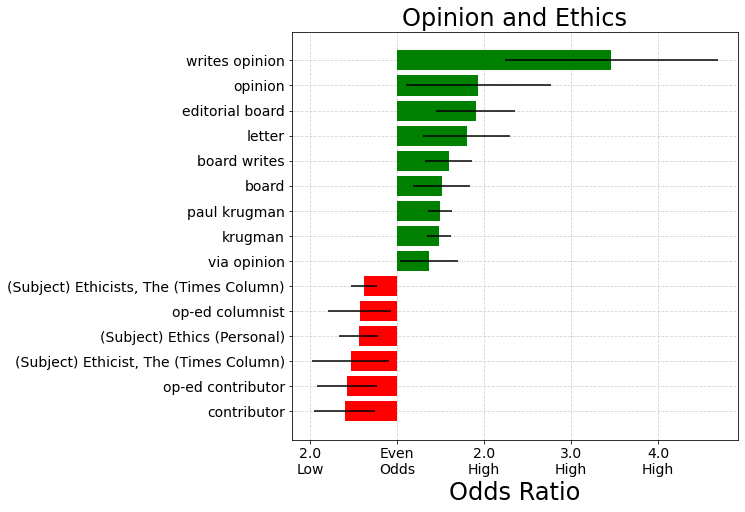

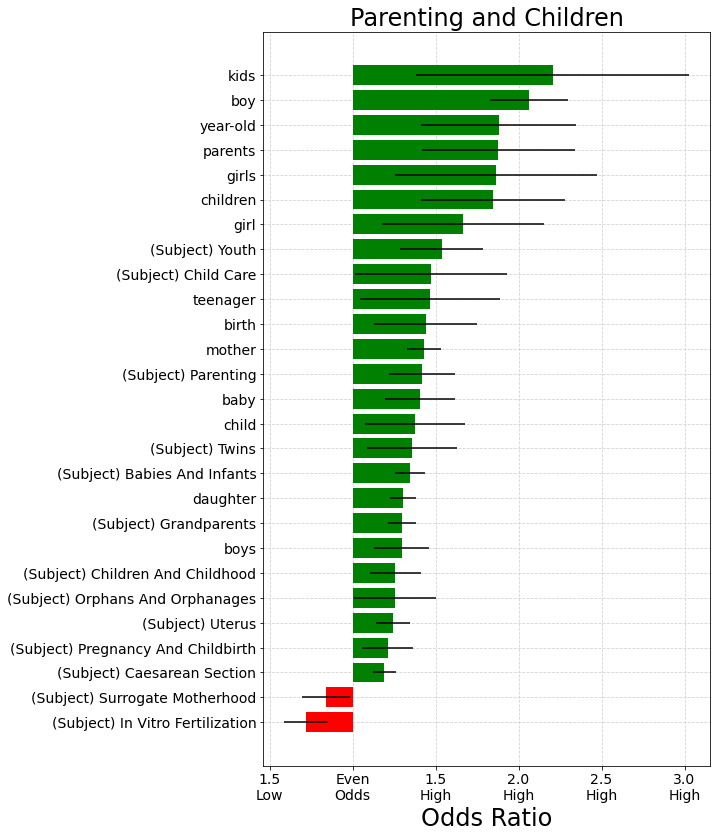

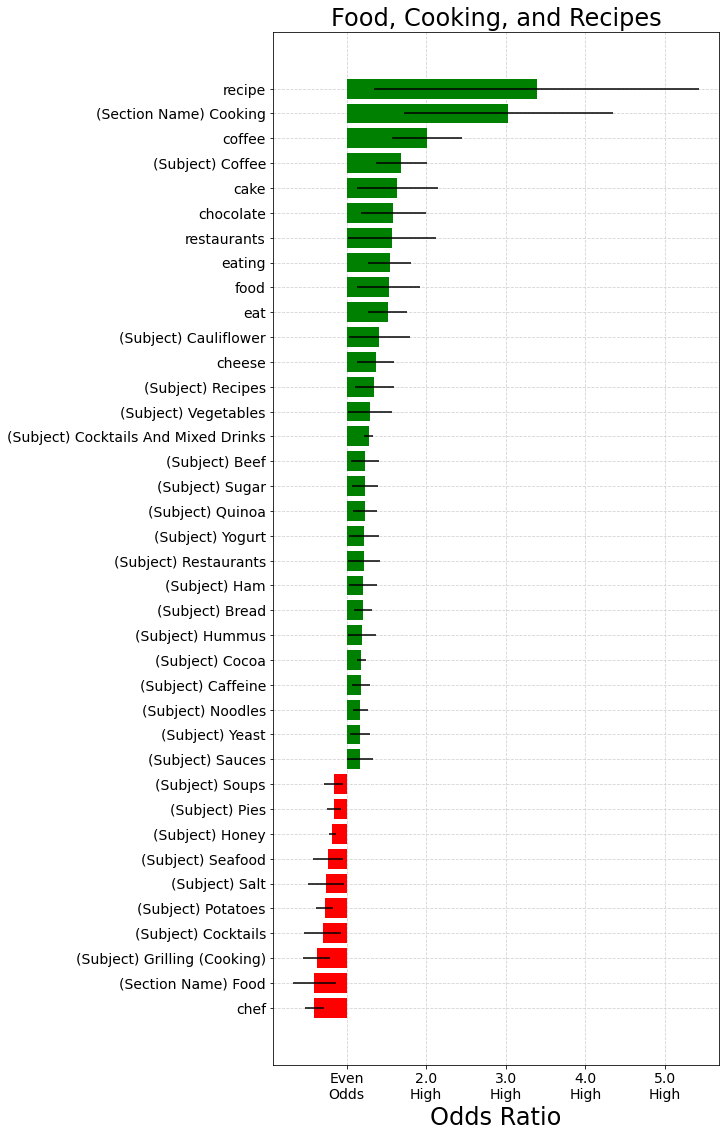

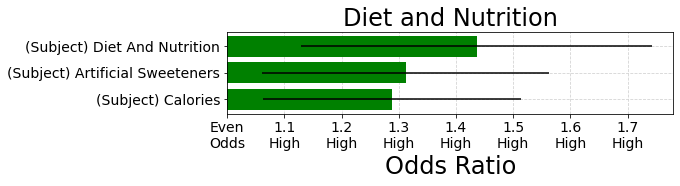

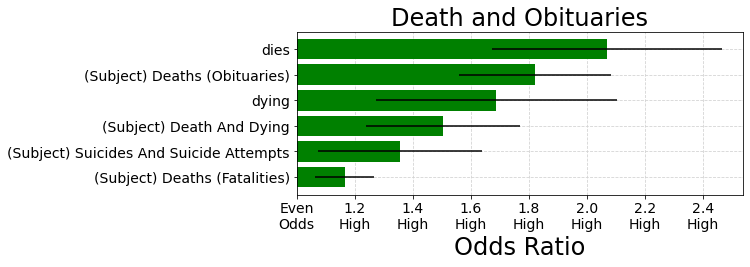

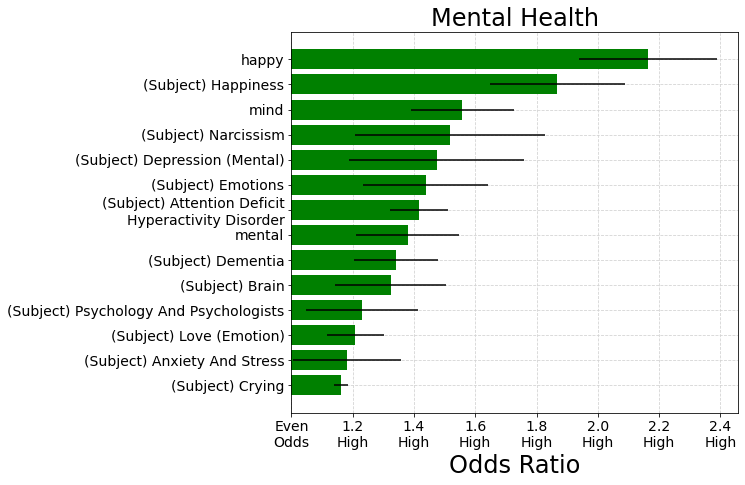

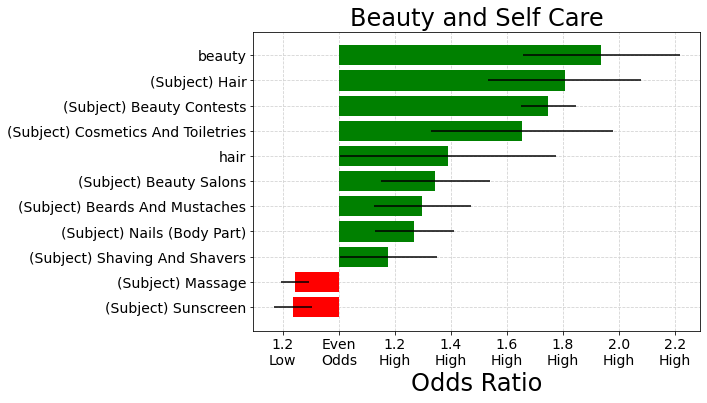

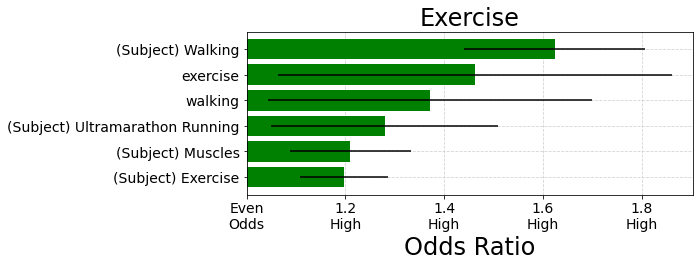

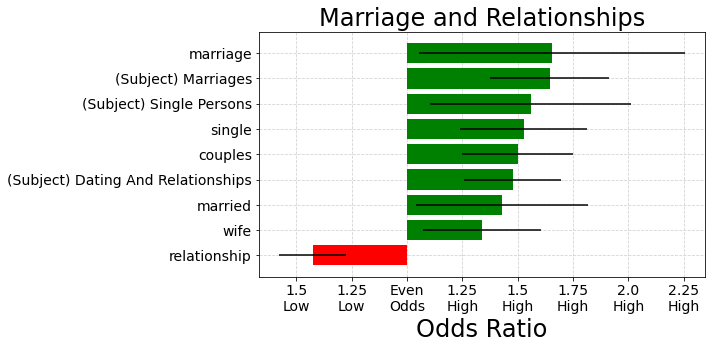

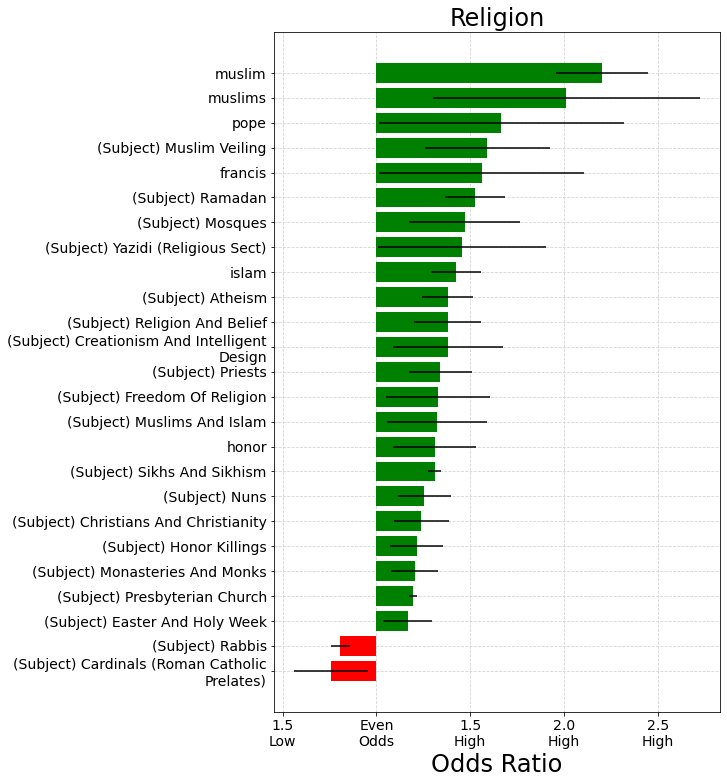

In [433]:
for cat in ['Opinion and Ethics', 'Parenting and Children', 'Food, Cooking, and Recipes', 
            'Diet and Nutrition', 'Death and Obituaries', 'Mental Health', 
            'Beauty and Self Care', 'Exercise', 'Marriage and Relationships',
            'Religion']:

    plot_topfeatures_w_conf(df_results.loc[(df_results['Category']==cat) & 
                (df_results['conf_min']>1) & (df_results['count']>1)], 
                            'Formatted Feature', high_label, 50, 
                   f"{cat}", 'conf', pos_neg=True)

## Less Popular Topics to Scale Back on:

- Business and Commerce
- Economics
- Surveillance, Privacy, and Security
- Fashion and Clothing
- General Sports (although some global sports events do pretty well)
- Holidays
- Miltary and Warfare
- Modern Tech

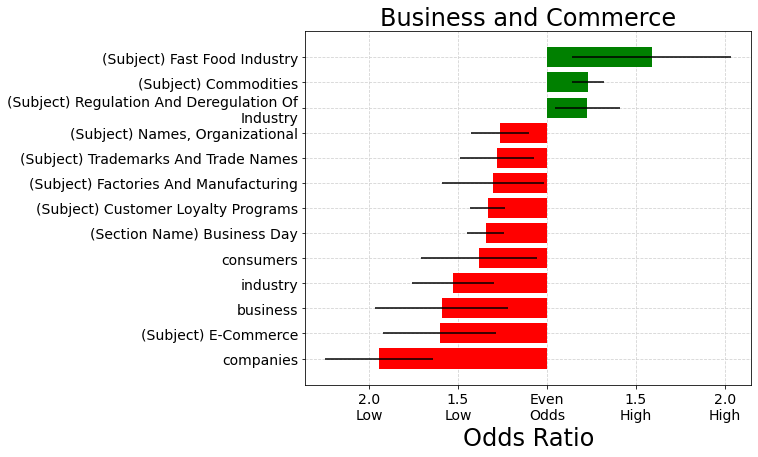

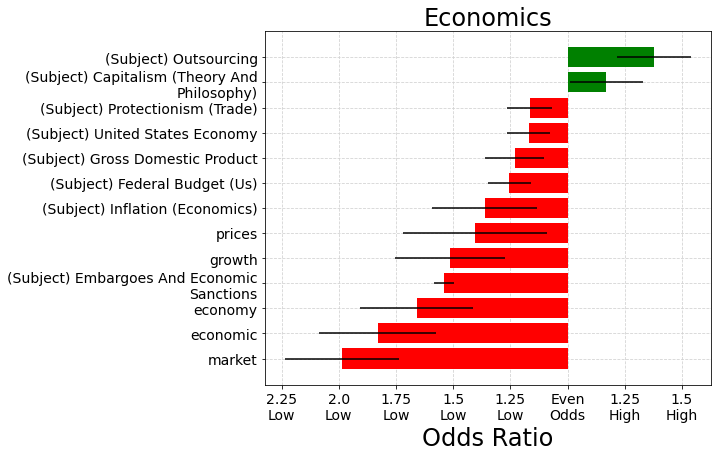

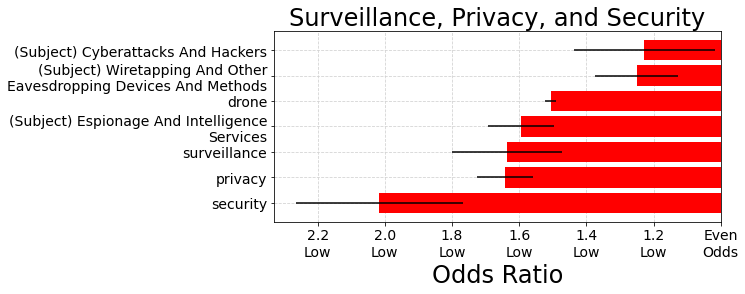

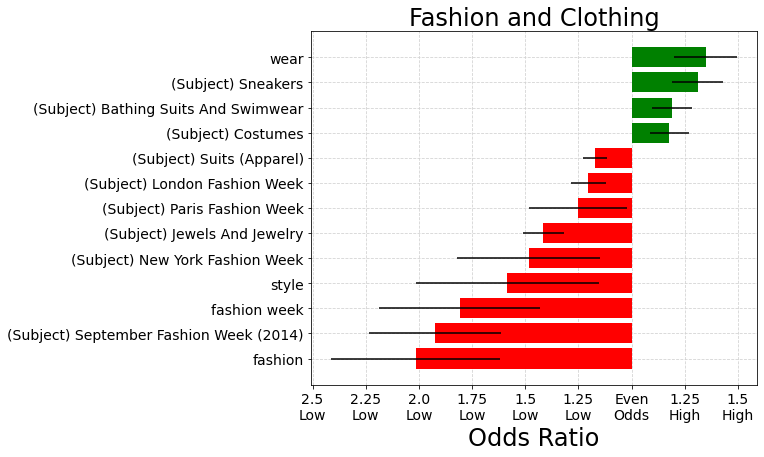

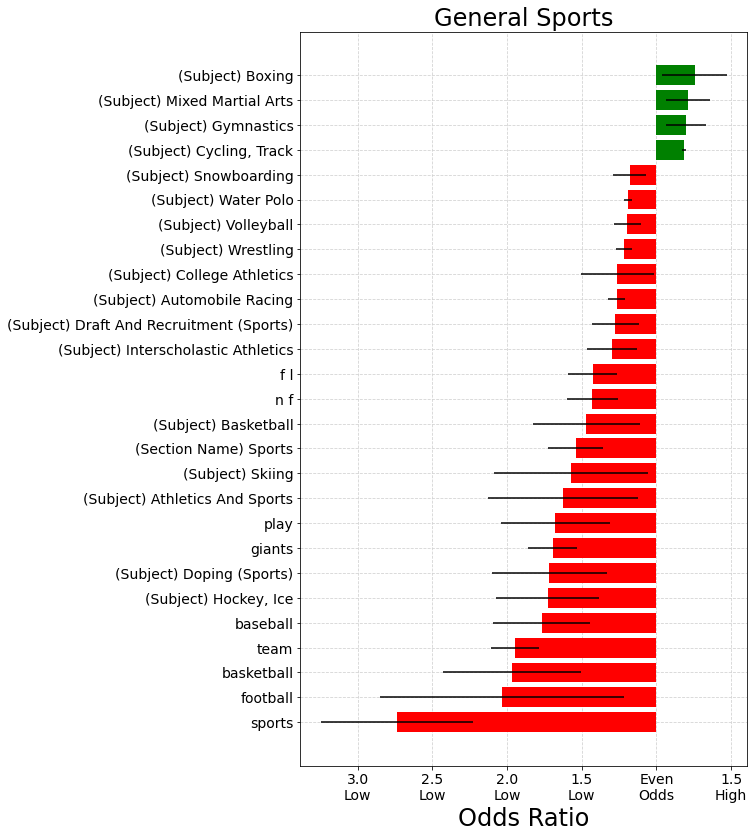

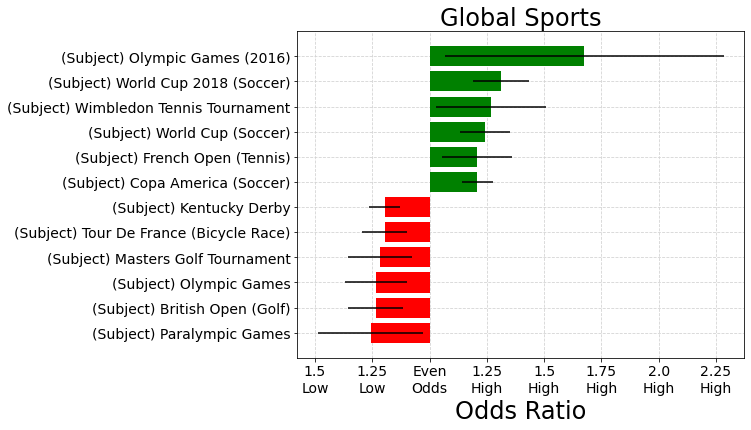

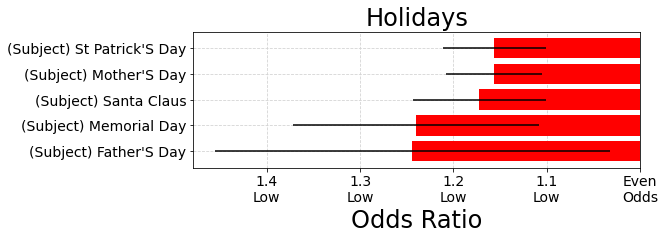

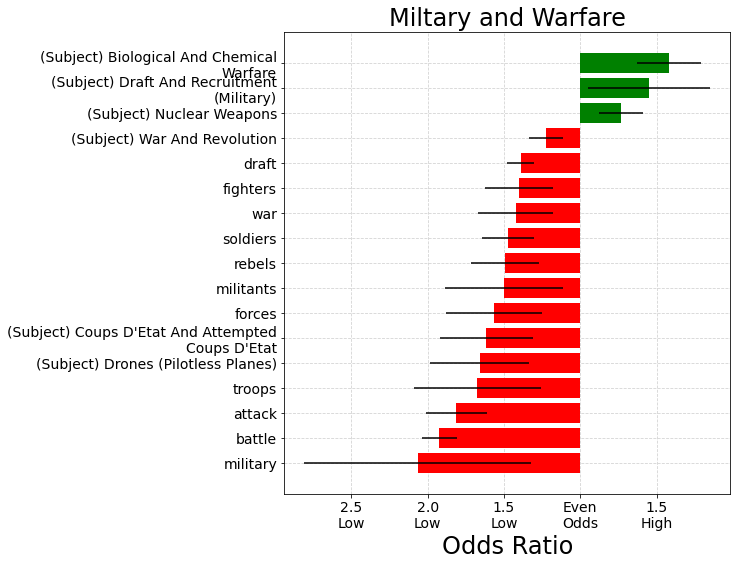

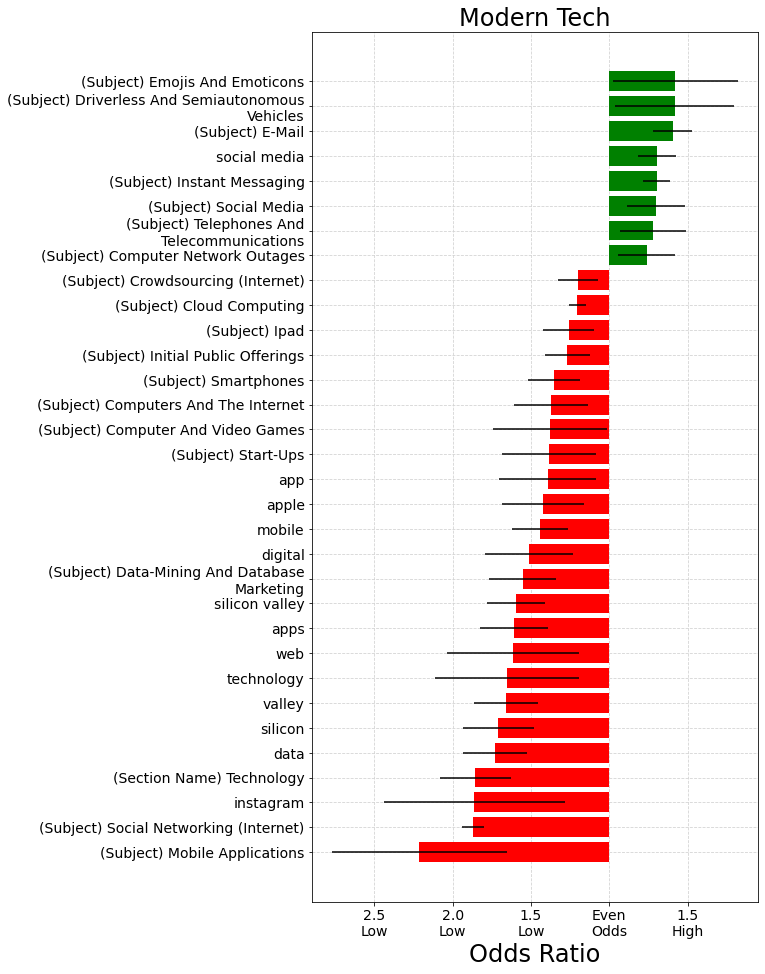

In [431]:
for cat in ['Business and Commerce', 'Economics','Surveillance, Privacy, and Security', 
            'Fashion and Clothing', 'General Sports', 'Global Sports', 
            'Holidays', 'Miltary and Warfare', 'Modern Tech']:

    plot_topfeatures_w_conf(df_results.loc[(df_results['Category']==cat) & 
                (df_results['conf_min']>1) & (df_results['count']>1)], 
                            'Formatted Feature', high_label, 50, 
                   f"{cat}", 'conf', pos_neg=True)

## Add Posts on the Weekends and in Evenings when Appropriate

- Posts have slightly higher odds of high engagement when added in the evening (from 7 - 11 PM Eastern) versus at other times of day.
- They also have slightly higher odds of high engagement if posted on the weekend versus on weekdays.
- This is likely because the News Feed algorithm prioritizes more recently added content, and people may tend to engage with Facebook more in evenings and on weekends.

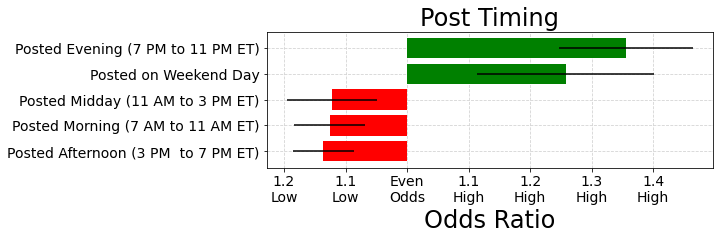

In [495]:
for cat in ['Post Timing']:

    plot_topfeatures_w_conf(df_results.loc[(df_results['Category']==cat) & 
                (df_results['conf_min']>1) & (df_results['count']>1)], 
                            'Formatted Feature', high_label, 50, 
                   f"{cat}", 'conf', pos_neg=True)

## Caveats

The model results are more useful to understand themes as opposed to making accurate predictions. Key terms and names will change, so a model trained to pick up on high engagement using the names of the 2016 presidential election candidates, for instance, would perform worse on the 2020 presidential election.

This analysis defines `high engagement` by taking the percentile for engagement in comments count, shares count and likes/loves count, and then getting the mean of those engagement percentiles. Anything over a mean percentile of 75 was considered high. 
-  Engagement went up over time, and this is not accounted for; all posts were considered as a single corpus and not normalized for level of engagement per year, for example.
- The 75th percentile was somewhat arbitrary, and a different choice may yield different results. The distributions did not have a clear change to indicate the most appropriate cutoff point.
- If the New York Times would benefit more from certain types of engagement (for example shares, which might spread content farther beyond direct followers) these models do not capture that. Modeling individual engagement metrics may provide different results.

The results were pulled from two slightly different populations, since I was not able to match up all of the Facebook posts to NYT articles to get the metadata such as subject keywords and section name. The posts that I could not match  tended to be more highly engaging than low.

Just because a certain type of content drives higher engagement doesn't necessarily mean The New York Times will want to post more of that. Divisive and controversial topics tend to receive more engagement, but focusing primarily on those topics would not necessarily be the right move from a journalistic perspective and may not be aligned with the Times' mission and values. 

## Future Steps

- Perform sentiment analysis on articles with different levels of engagement, to see if that plays a role.
- Compare Facebook engagement to NYT comment counts to see if there is a difference.
- Create an interactive dashboard to show engagement levels and top posts related to custom keywords and subjects.